# 1. Setup

### 1.1 Colab
The data folder is too large, so to be able to use it in Colab, first upload the .zip file to Google Drive, then mount Colab on Google Drive, and then extract the files.

In [25]:
'''
  from google.colab import drive
  drive.mount('/content/drive')

  import zipfile

  zip_path = '/content/drive/My Drive/archive.zip'
  extract_path = '/content/drive/My Drive/data'

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)


# !pip install git+https://github.com/tensorflow/examples.git
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix

tf.config.run_functions_eagerly(True)

DATA_PATH = "drive/MyDrive/data/BraTS2020_training_data/content/data/"
DATA_PATH2 = "drive/MyDrive/data/BraTS2020_training_data"
metadata = pd.read_csv("{}{}".format(DATA_PATH, "meta_data.csv"))
metadata["slice_path"] = metadata["slice_path"].apply(lambda x: x[56:])

BATCH_SIZE = 20
BUFFER_SIZE = 1000
ENCODER_IMG_DIM = 224
'''

'\n  from google.colab import drive\n  drive.mount(\'/content/drive\')\n\n  import zipfile\n\n  zip_path = \'/content/drive/My Drive/archive.zip\'\n  extract_path = \'/content/drive/My Drive/data\'\n\n  with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n      zip_ref.extractall(extract_path)\n\n\n# !pip install git+https://github.com/tensorflow/examples.git\nimport tensorflow as tf\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport h5py\nimport numpy as np\nfrom tensorflow_examples.models.pix2pix import pix2pix\n\ntf.config.run_functions_eagerly(True)\n\nDATA_PATH = "drive/MyDrive/data/BraTS2020_training_data/content/data/"\nDATA_PATH2 = "drive/MyDrive/data/BraTS2020_training_data"\nmetadata = pd.read_csv("{}{}".format(DATA_PATH, "meta_data.csv"))\nmetadata["slice_path"] = metadata["slice_path"].apply(lambda x: x[56:])\n\nBATCH_SIZE = 20\nBUFFER_SIZE = 1000\nENCODER_IMG_DIM = 224\n'

### 1.2
If running locally, run this.

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix

tf.config.run_functions_eagerly(True)

DATA_PATH = "../data/archive/BraTS2020_training_data/content/data/"
DATA_PATH2 = "../data/archive/BraTS2020_training_data"
metadata = pd.read_csv("{}{}".format(DATA_PATH, "meta_data.csv"))

# parameters
BATCH_SIZE = 20
BUFFER_SIZE = 1000
ENCODER_IMG_DIM = 224

# 2. Preprocessing

### 2.1 Splitting the data.
Since we don't want leakage of unseen images to occur, we perform a structured split on the dataset taking into account each slice's volume. Thus, all volumes on each set (train/val/dev) contains only slices from volumes that are not present in the other sets.

In [27]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.8)
gss.split(metadata["slice_path"], metadata["slice_path"], metadata["volume"])
for dev_idxs, test_idxs in gss.split(
    metadata, 
    metadata["slice_path"], 
    metadata["volume"]
    ):
    pass
metadata_dev = metadata.iloc[dev_idxs]
metadata_test = metadata.iloc[test_idxs]
gss = GroupShuffleSplit(n_splits=1, test_size=0.25)
for train_idxs, val_idxs in gss.split(
    metadata_dev, 
    metadata_dev["slice_path"], 
    metadata_dev["volume"]):
    pass
metadata_train = metadata_dev.iloc[train_idxs]
metadata_val = metadata_dev.iloc[val_idxs]

### 2.2 Load datasets.
Since the datasets are large, we use the Tensorflow Datasets class to load and use the dataset in a streaming fashion.

In [53]:
tf.config.run_functions_eagerly(True)
def load_datapoint(datapoint):
    with h5py.File(f"{ DATA_PATH2 }{ datapoint.numpy().decode('utf-8') }",'r') as f:
        image = np.array(f["image"])[:, :, :3]
        mask = np.array(f["mask"])
        mask = mask[:, :, 0] + 2 * mask[:, :, 1] + 3 * mask[:, :, 2]
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        mask = tf.convert_to_tensor(mask, dtype=tf.int8)
        mask = tf.expand_dims(mask, axis=-1)
        print(image.shape)

        # Resize to sizes supported by pretrained encoder
        image = tf.image.resize(image, (ENCODER_IMG_DIM, ENCODER_IMG_DIM))
        mask = tf.image.resize(
            mask, 
            (ENCODER_IMG_DIM, ENCODER_IMG_DIM),
            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
            )
    
    return image, mask 

def load_datapoint_tf(datapoint):
    image, mask = tf.py_function(load_datapoint, [datapoint], [tf.float32, tf.int8])
    return image, mask

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([0.25, 35.0, 127.0, 95.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [54]:
# Create datasets
train_df = tf.data.Dataset.from_tensor_slices(metadata_train["slice_path"].to_numpy())
train_df = train_df.map(load_datapoint_tf)

val_df = tf.data.Dataset.from_tensor_slices(metadata_val["slice_path"].to_numpy())
val_df = val_df.map(load_datapoint_tf)

test_df = tf.data.Dataset.from_tensor_slices(metadata_test["slice_path"].to_numpy())
test_df = test_df.map(load_datapoint_tf)

c:\Users\Heichous\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [55]:
# Data loaders
train_batches = (
    train_df
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
    )

val_batches = (
    val_df
        .cache()
        .batch(BATCH_SIZE)
)
test_batches = test_df.batch(BATCH_SIZE)

train_batches = train_batches.map(add_sample_weights)
val_batches = val_batches.map(add_sample_weights)
test_batches = test_batches.map(add_sample_weights)

# 3. Model

### 3.1 Encoder
For the encoder model, we have two strategies:
1. The first possibility is to use a pre-trained encoder model (and potentially fine-tune it).
2. The second possibility is to try to train an encoder model from scratch.

In [56]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

### 3.2 Decoder

In [57]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

### 3.3 Piercing the model together

In [58]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [59]:
OUTPUT_CLASSES = 4

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              weighted_metrics=tf.keras.metrics.SparseCategoricalAccuracy()
              )

In [60]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
EPOCHS = 2
STEPS_PER_EPOCH = len(train_df)//BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(val_df)//BATCH_SIZE

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          verbose=1)

In [44]:
def show_predictions(dataset=None, num=1):
  i = 0
  for sample_image, sample_mask in test_df.take(num):
    display([sample_image, sample_mask,
              create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    i += 1
    if i > num: break 

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 75ms/step


c:\Users\Heichous\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


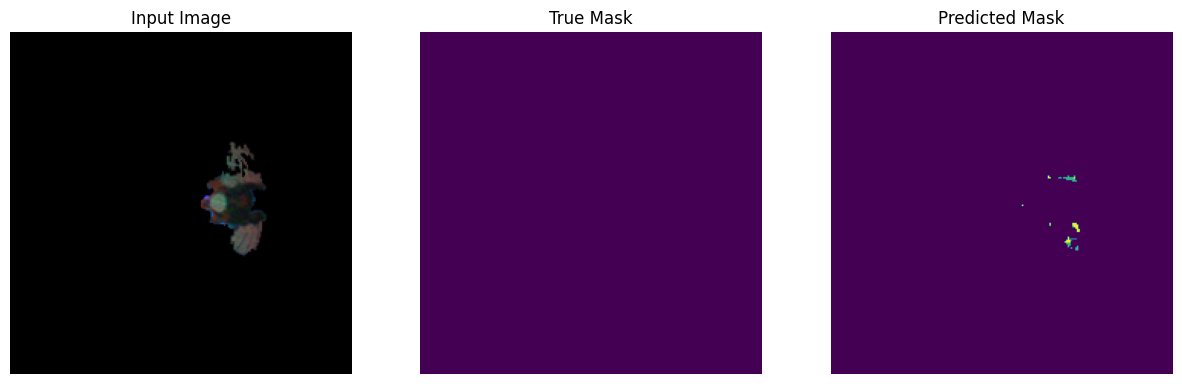

1/1 [==============================] - 0s 73ms/step


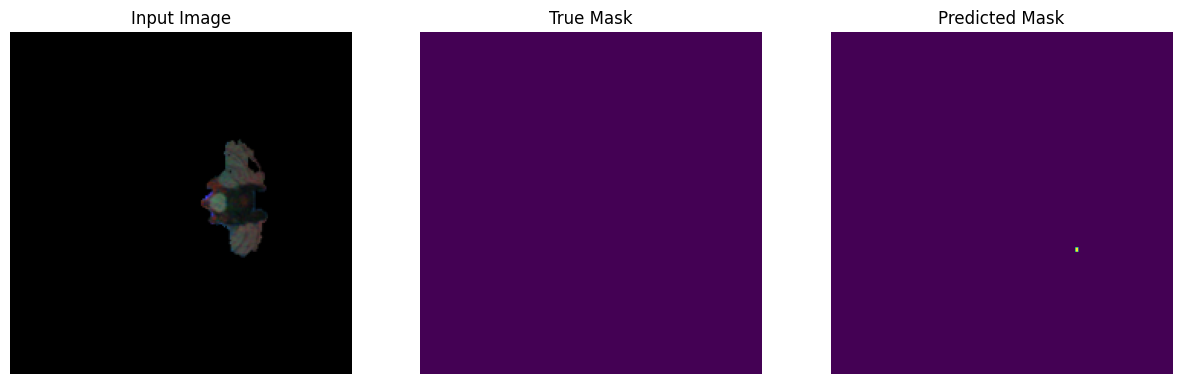

1/1 [==============================] - 0s 74ms/step


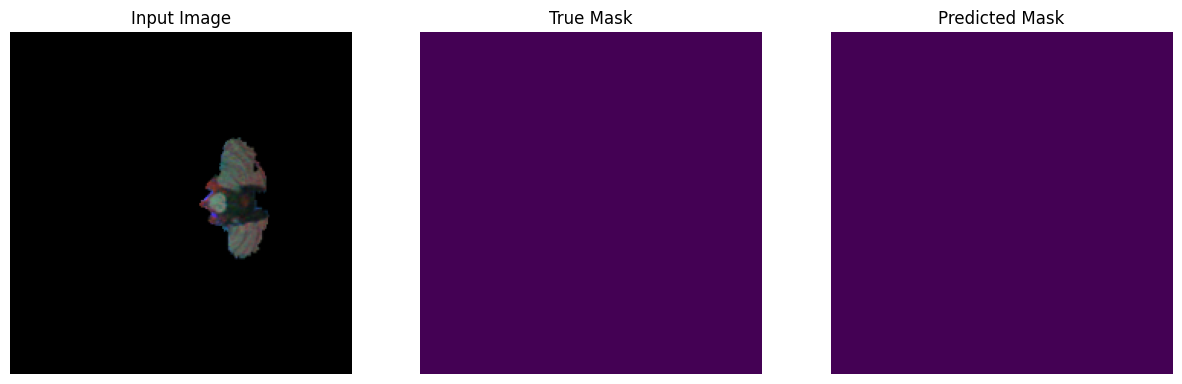

1/1 [==============================] - 0s 69ms/step


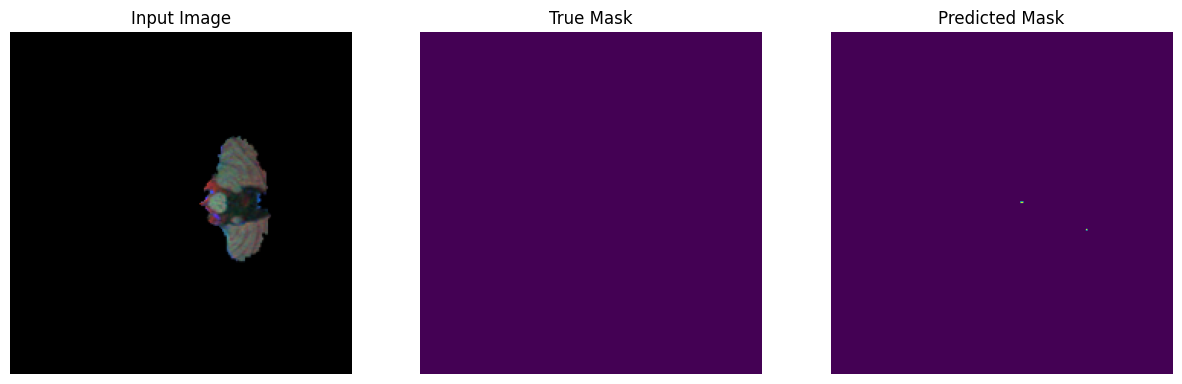

1/1 [==============================] - 0s 71ms/step


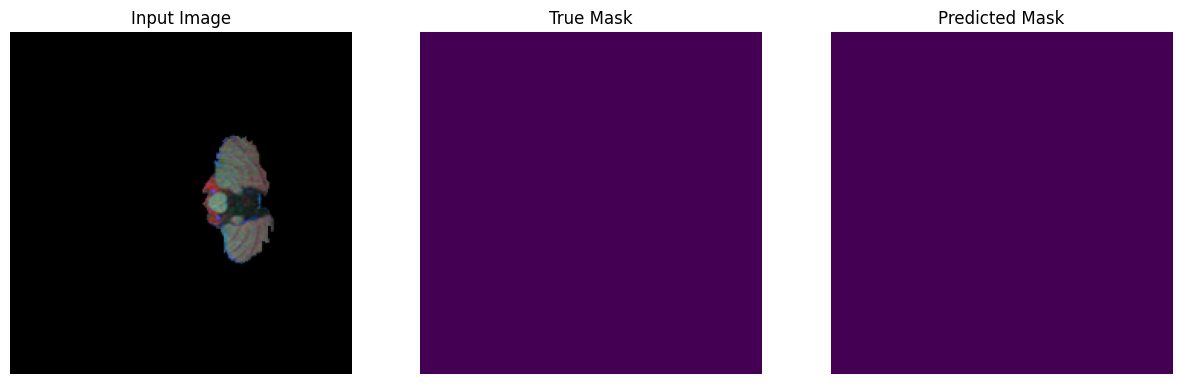

1/1 [==============================] - 0s 72ms/step


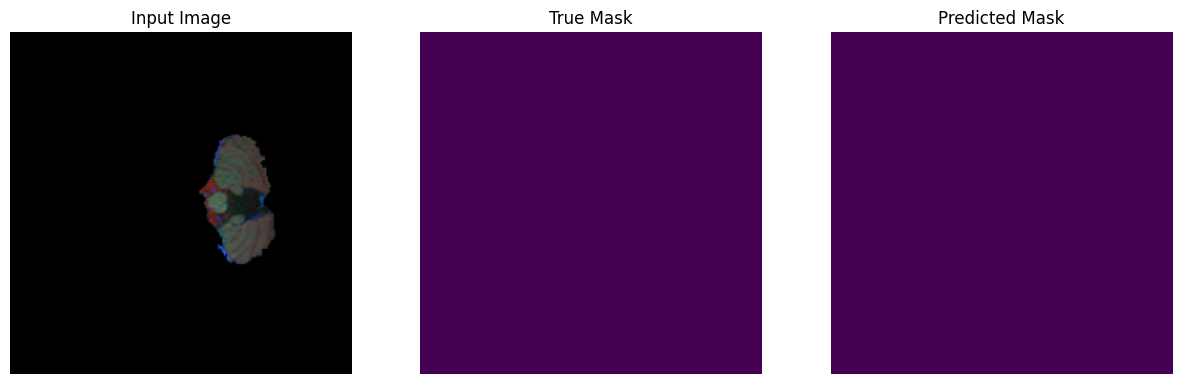

1/1 [==============================] - 0s 73ms/step


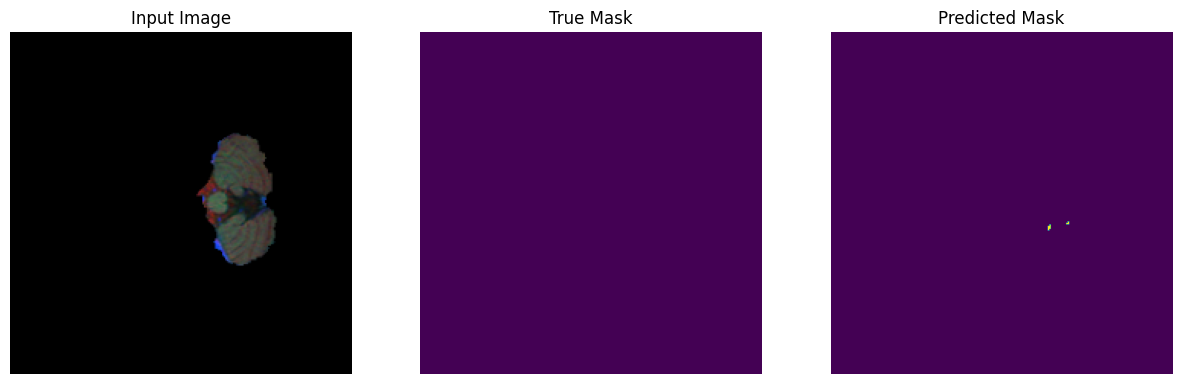

1/1 [==============================] - 0s 71ms/step


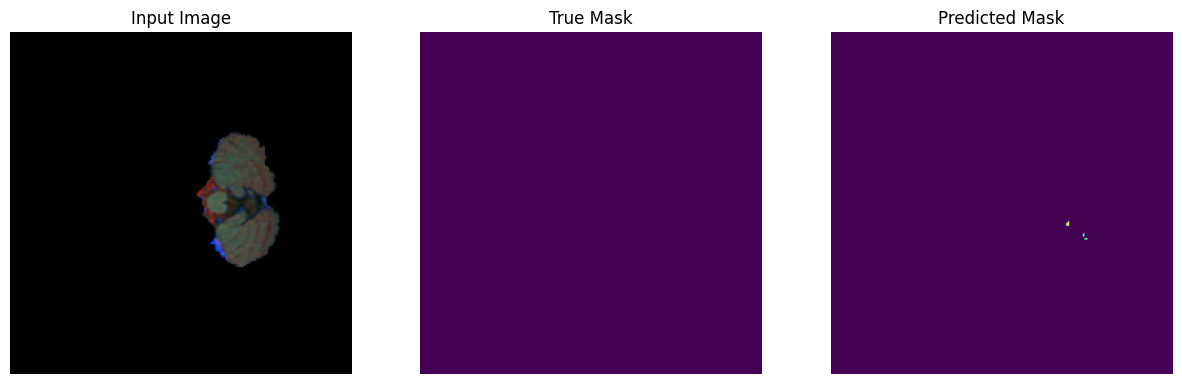

1/1 [==============================] - 0s 70ms/step


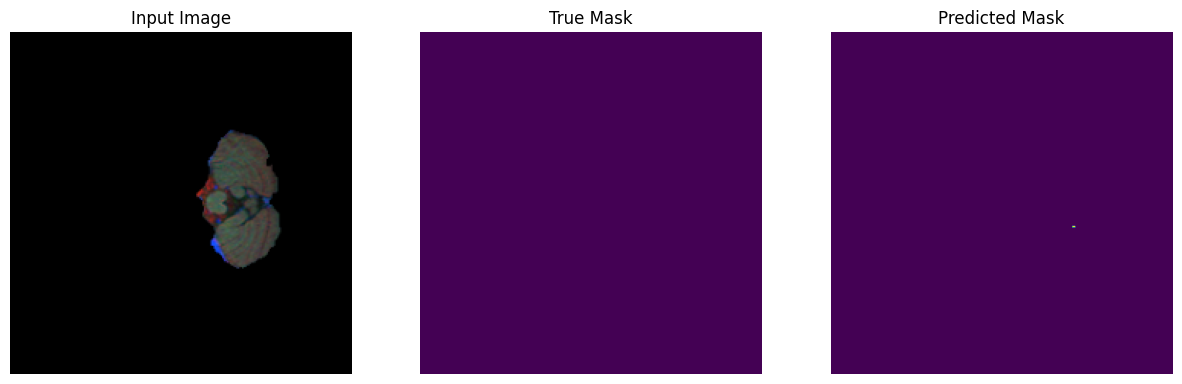

1/1 [==============================] - 0s 72ms/step


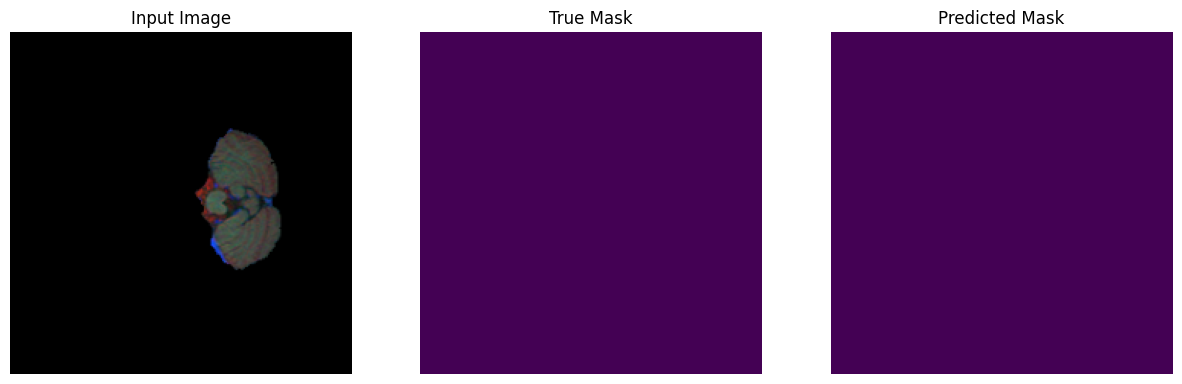

1/1 [==============================] - 0s 73ms/step


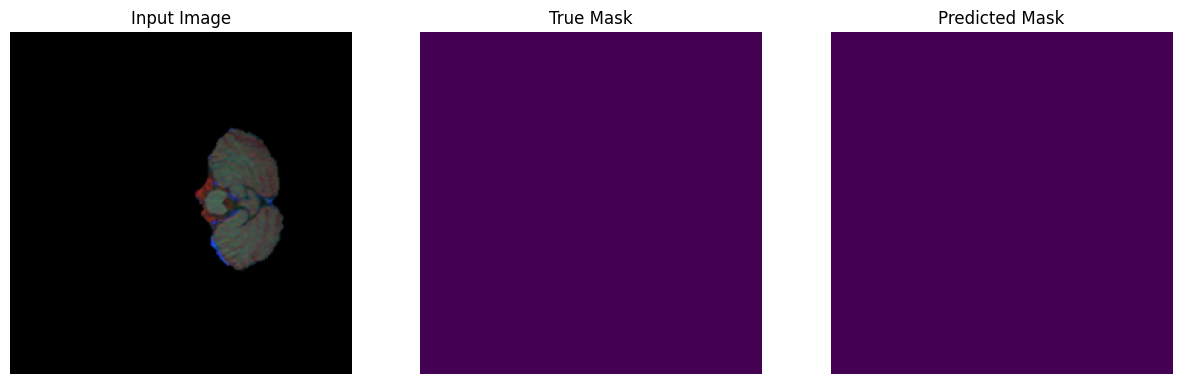

1/1 [==============================] - 0s 76ms/step


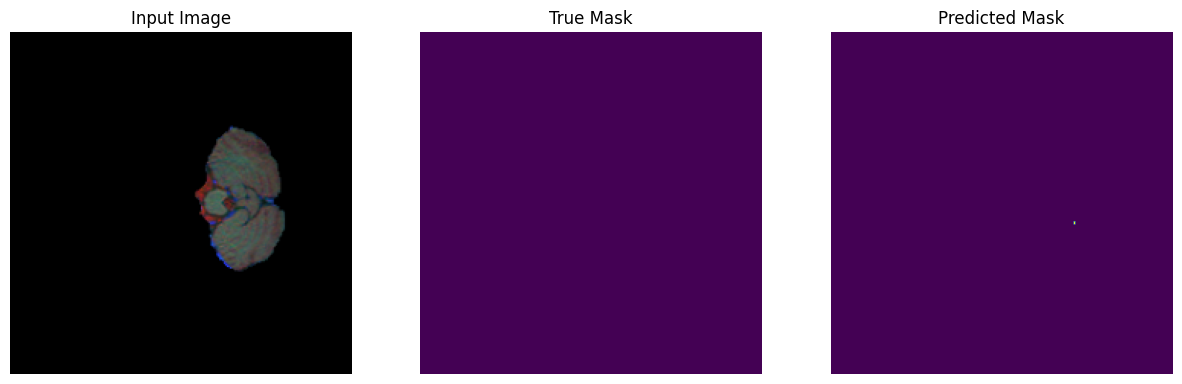

1/1 [==============================] - 0s 73ms/step


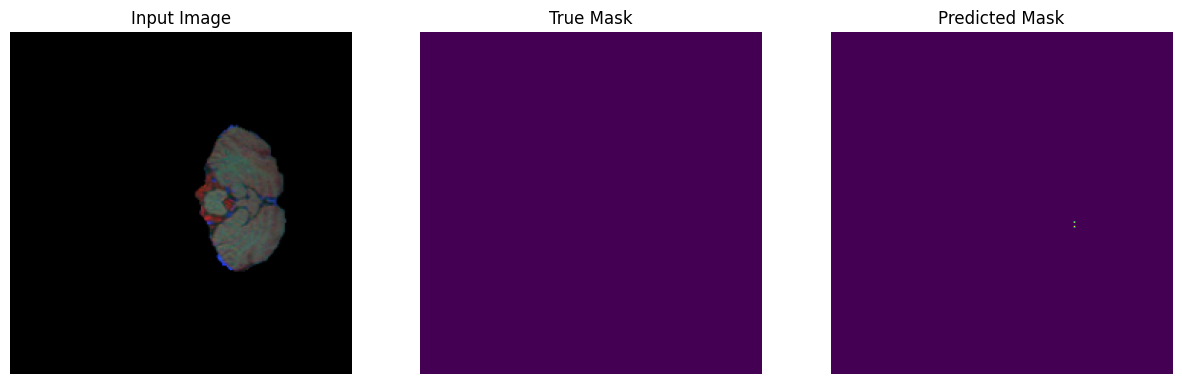

1/1 [==============================] - 0s 84ms/step


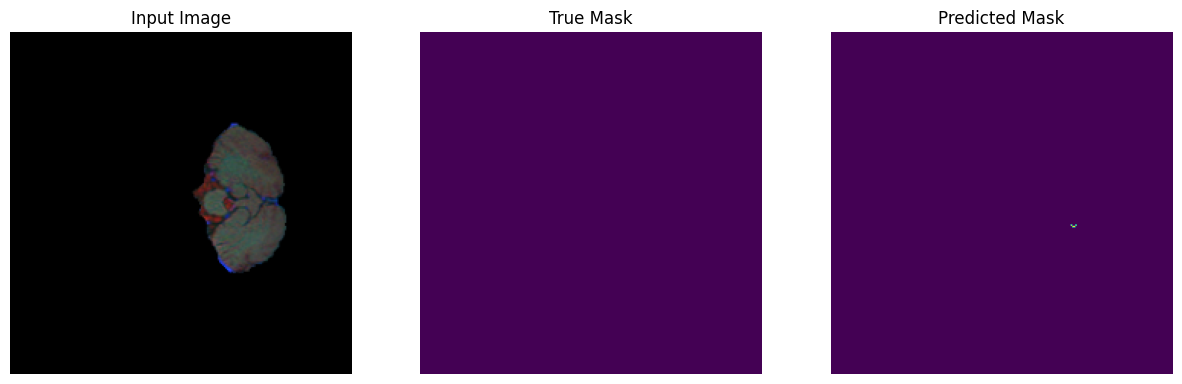

1/1 [==============================] - 0s 74ms/step


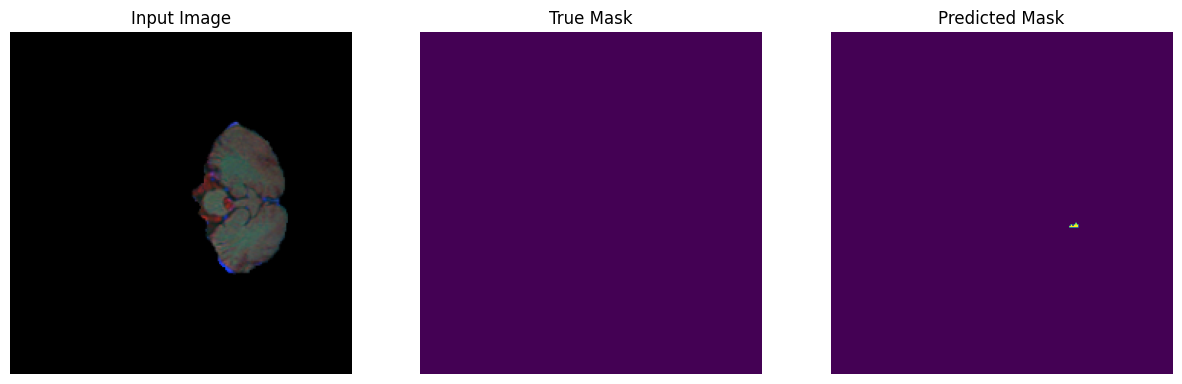

1/1 [==============================] - 0s 76ms/step


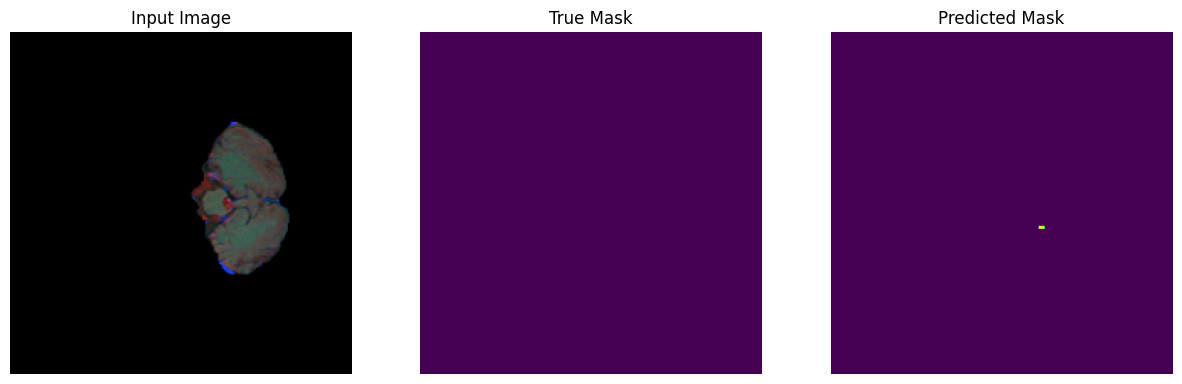

1/1 [==============================] - 0s 76ms/step


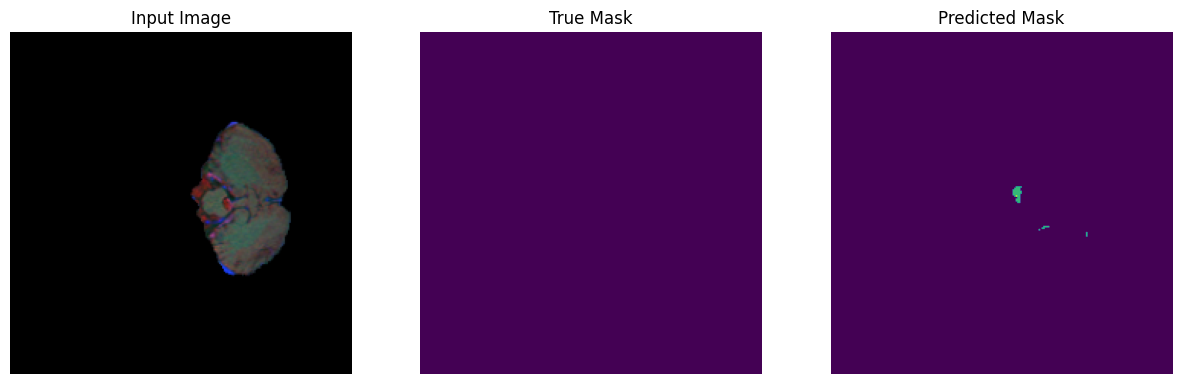

1/1 [==============================] - 0s 71ms/step


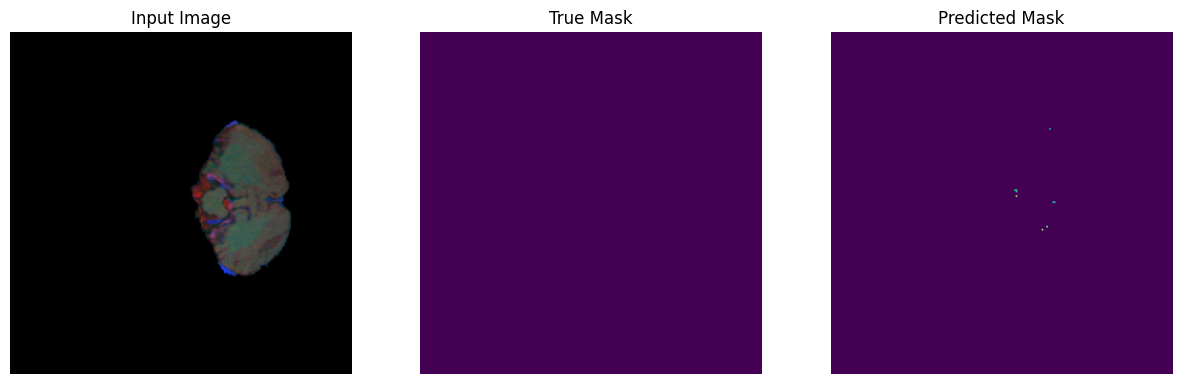

1/1 [==============================] - 0s 71ms/step


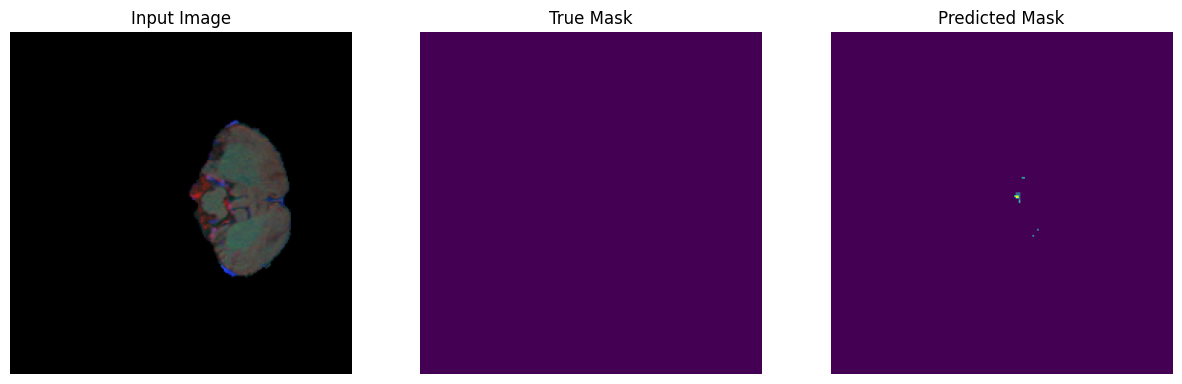

1/1 [==============================] - 0s 80ms/step


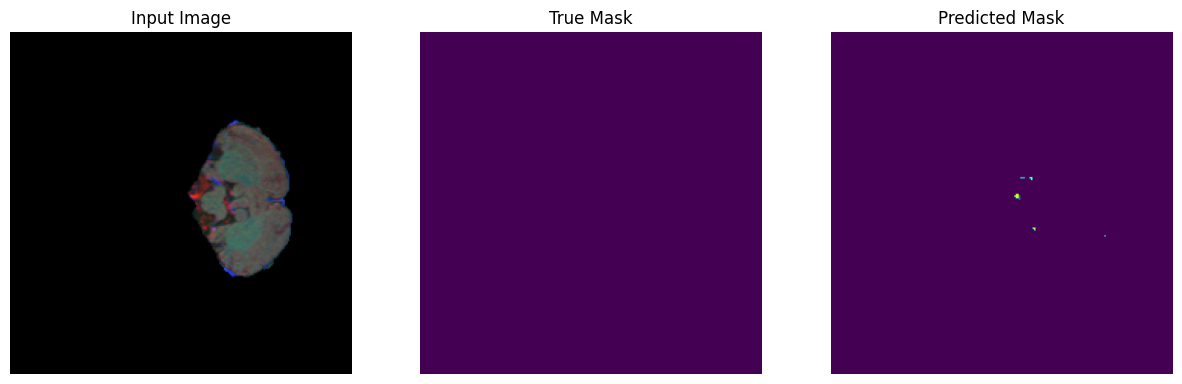

1/1 [==============================] - 0s 70ms/step


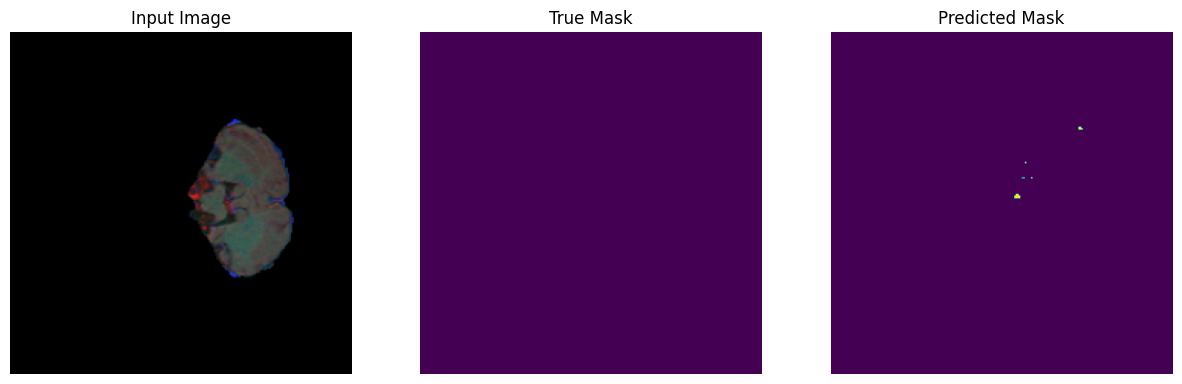

1/1 [==============================] - 0s 75ms/step


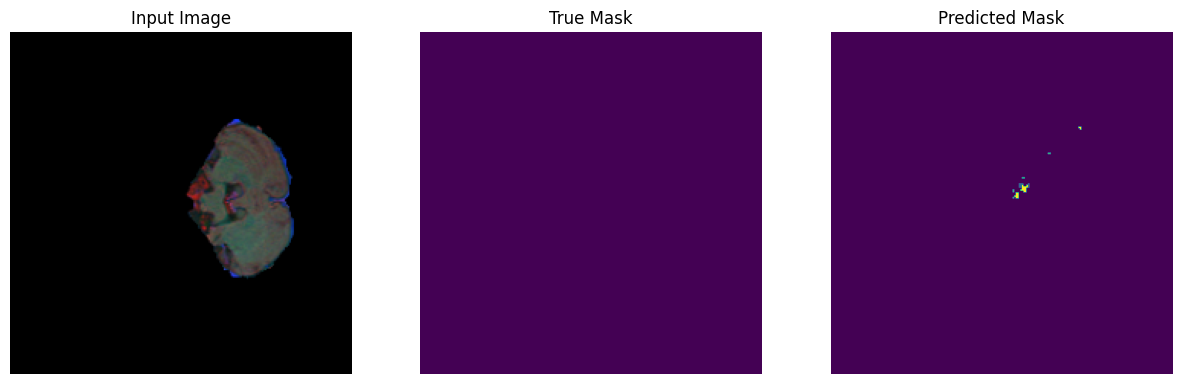

1/1 [==============================] - 0s 73ms/step


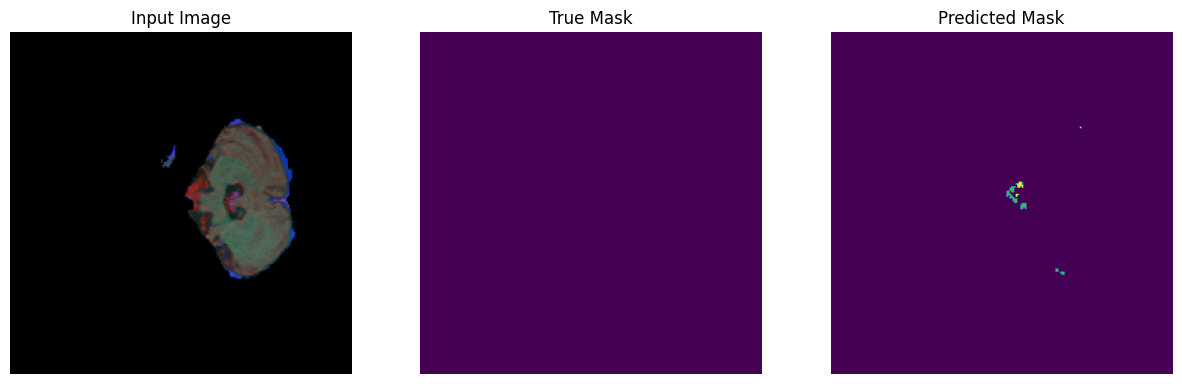

1/1 [==============================] - 0s 77ms/step


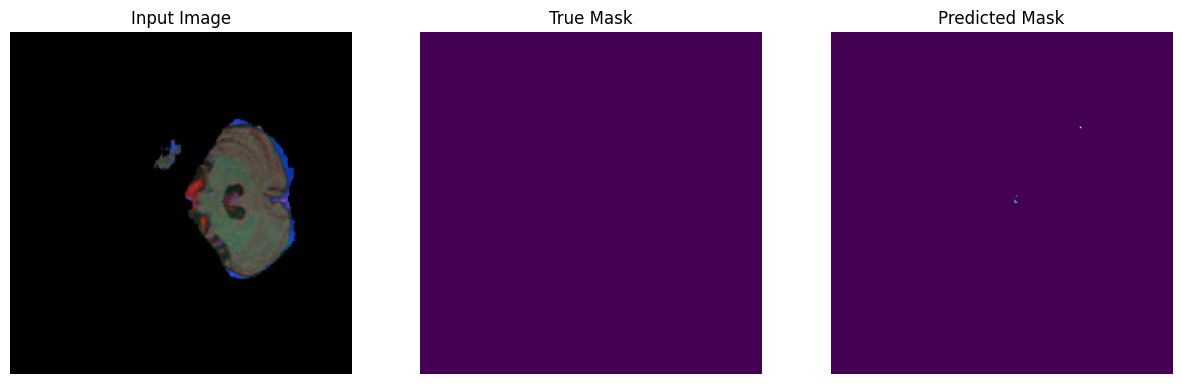

1/1 [==============================] - 0s 74ms/step


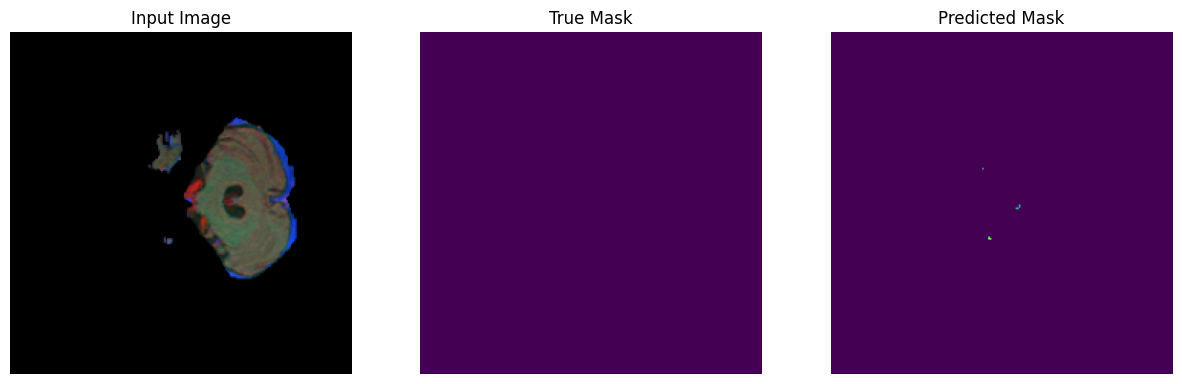

1/1 [==============================] - 0s 74ms/step


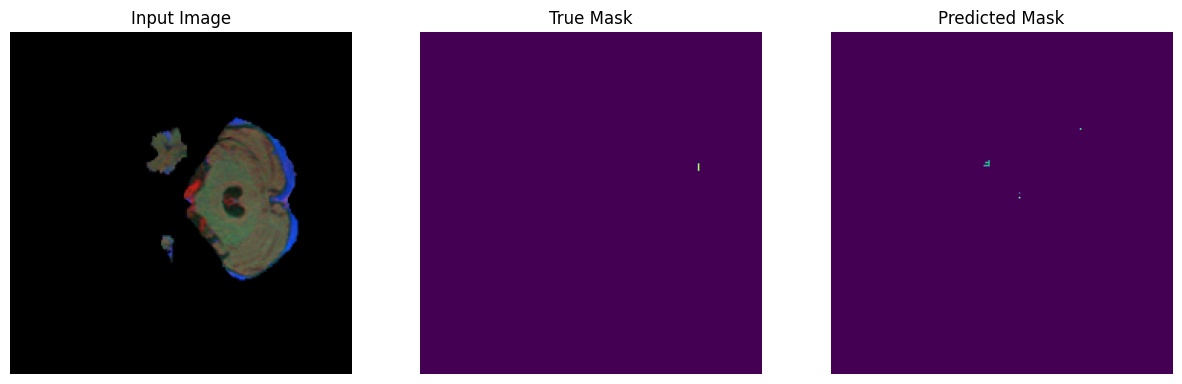

1/1 [==============================] - 0s 73ms/step


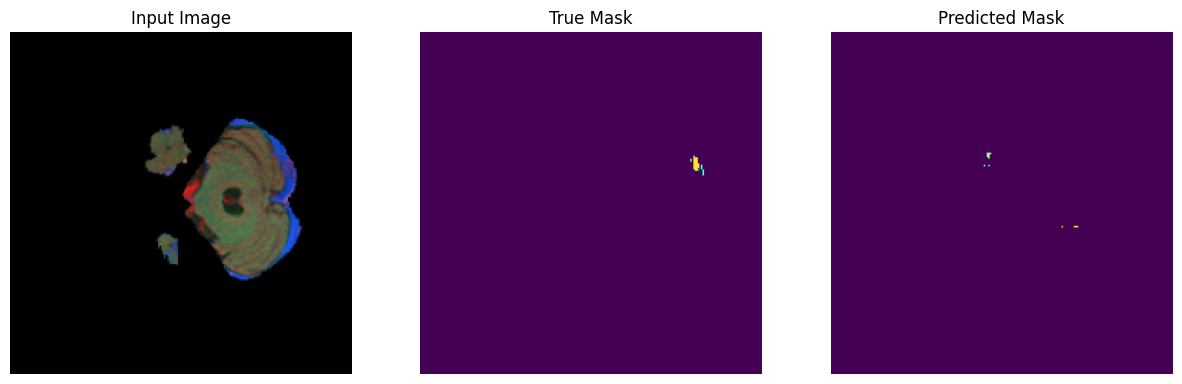

1/1 [==============================] - 0s 71ms/step


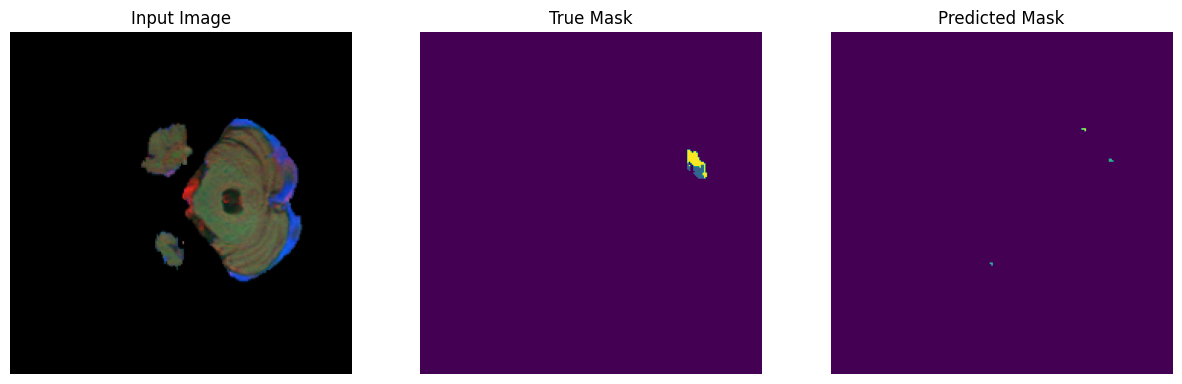

1/1 [==============================] - 0s 72ms/step


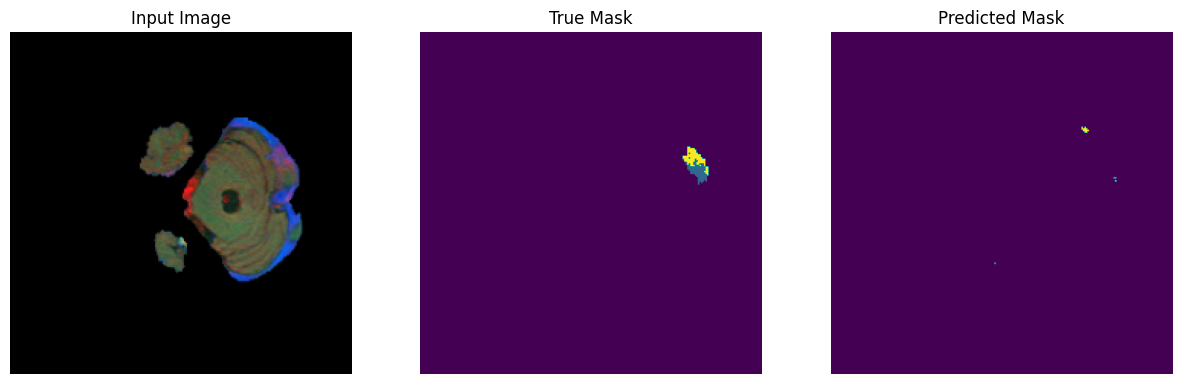

1/1 [==============================] - 0s 71ms/step


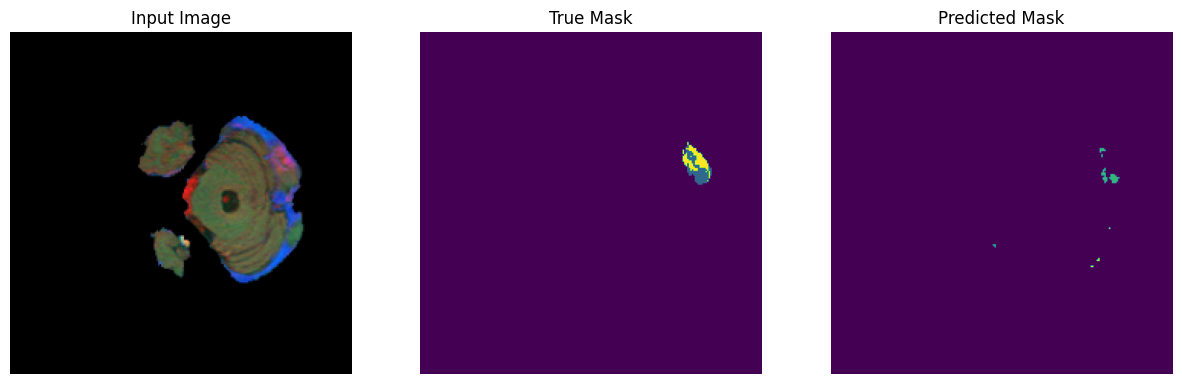

1/1 [==============================] - 0s 72ms/step


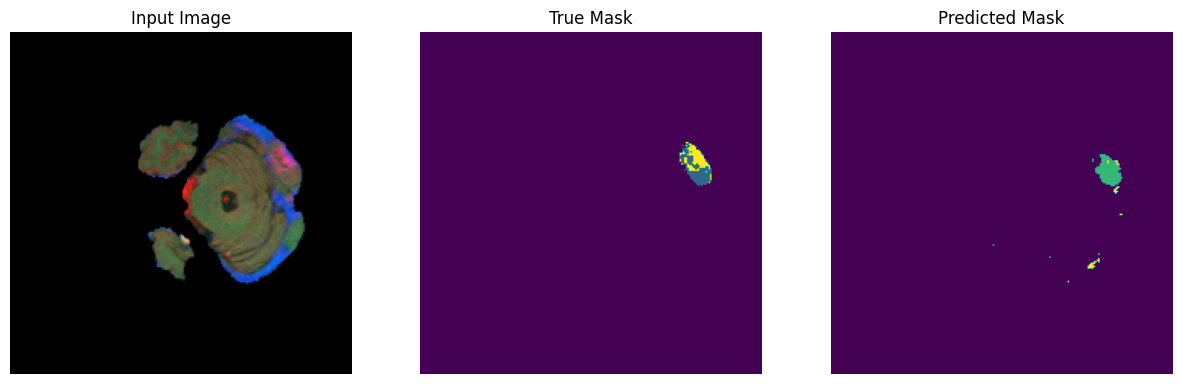

1/1 [==============================] - 0s 75ms/step


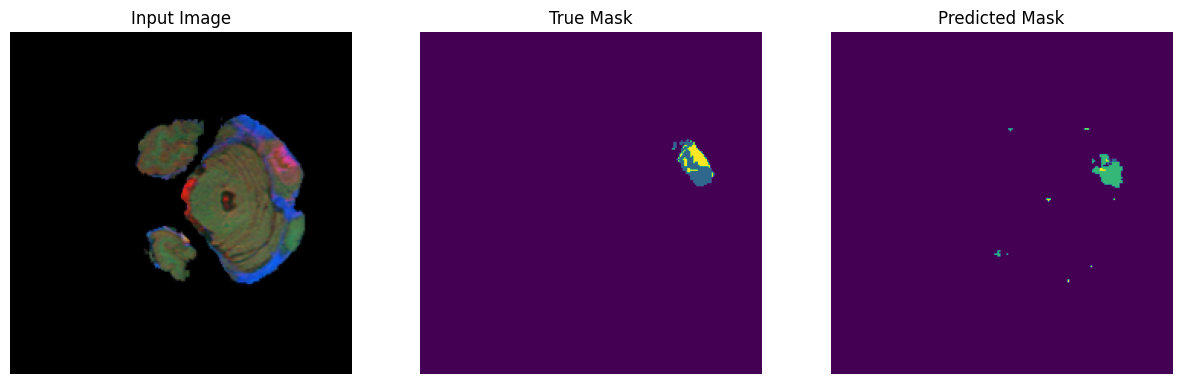

1/1 [==============================] - 0s 70ms/step


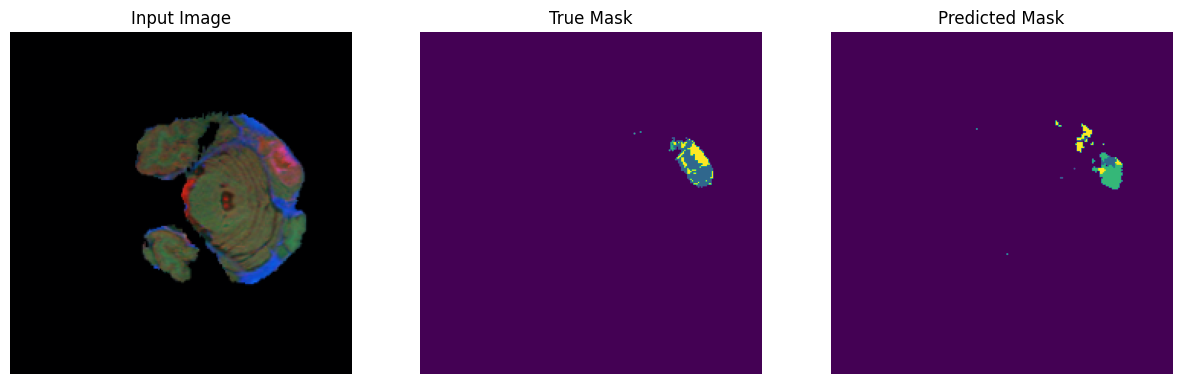

1/1 [==============================] - 0s 81ms/step


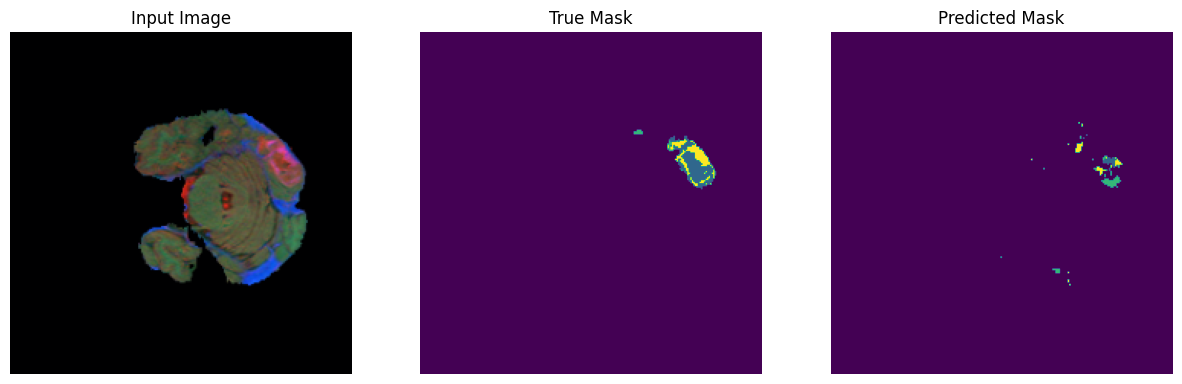

1/1 [==============================] - 0s 70ms/step


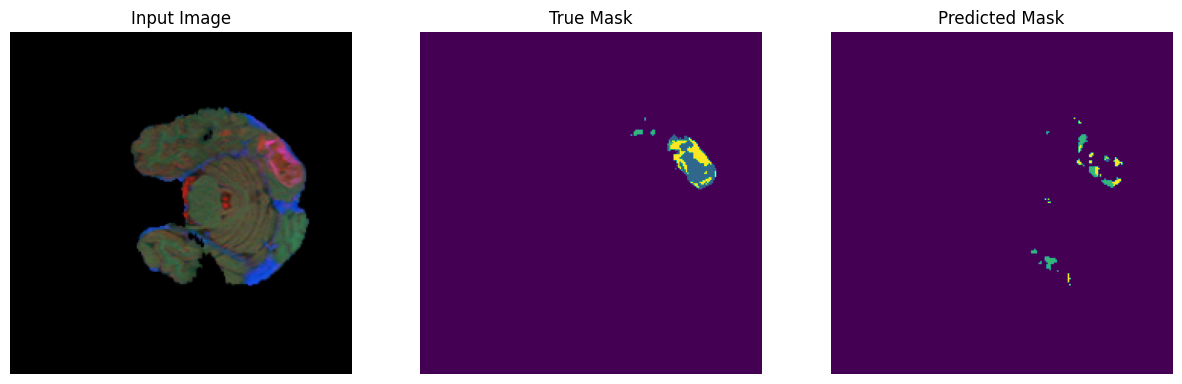

1/1 [==============================] - 0s 81ms/step


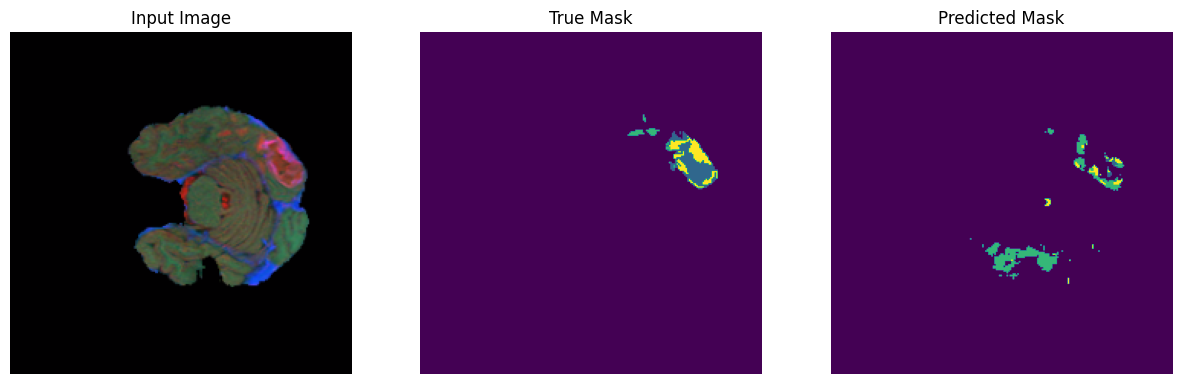

1/1 [==============================] - 0s 72ms/step


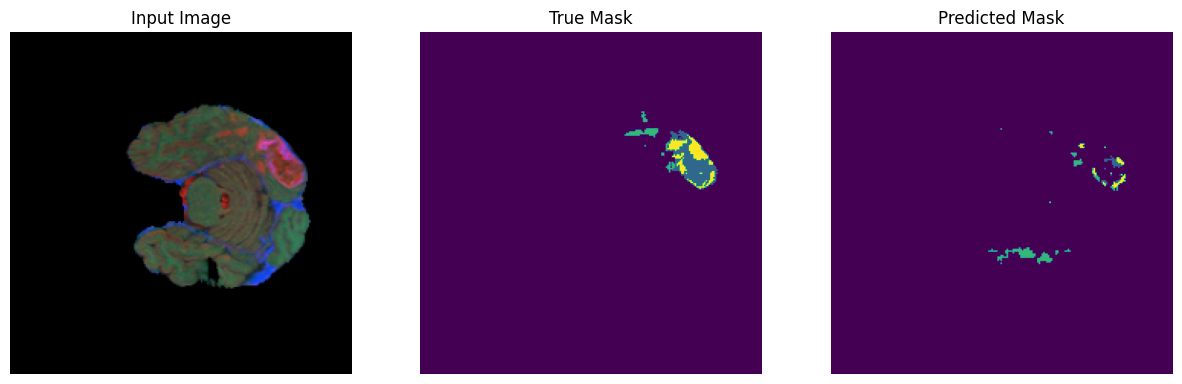

1/1 [==============================] - 0s 74ms/step


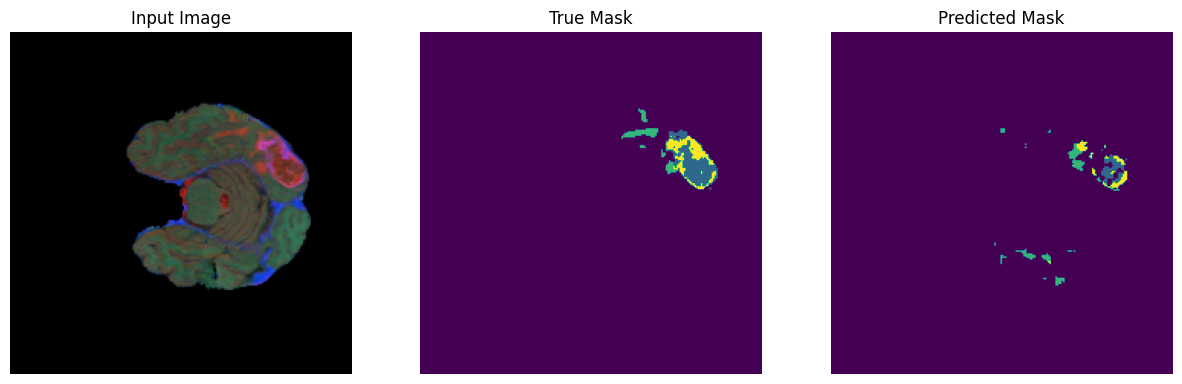

1/1 [==============================] - 0s 75ms/step


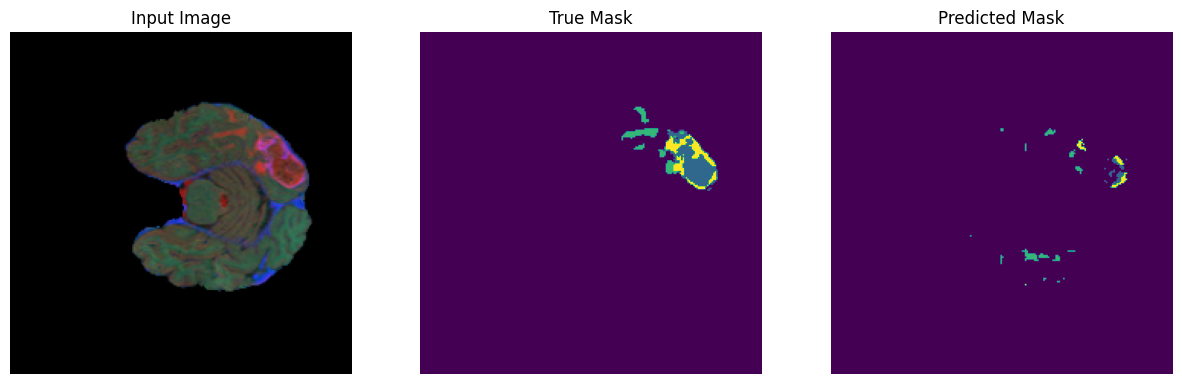

1/1 [==============================] - 0s 71ms/step


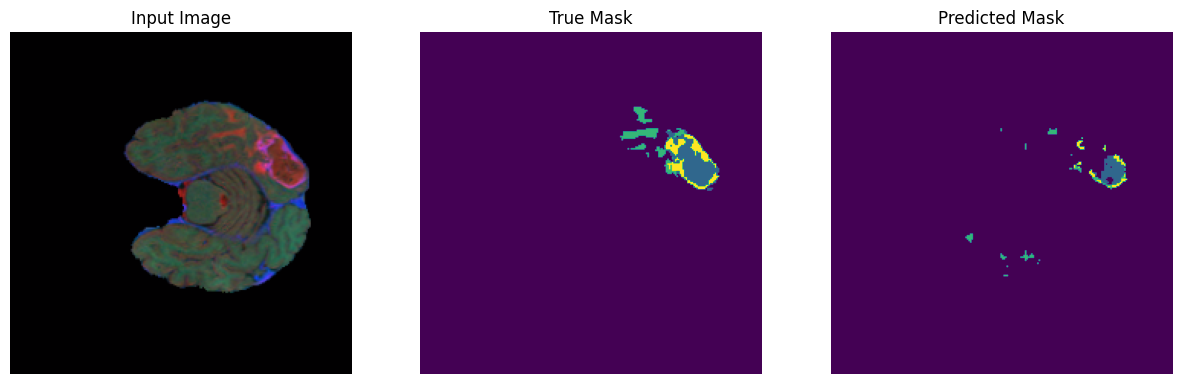

1/1 [==============================] - 0s 81ms/step


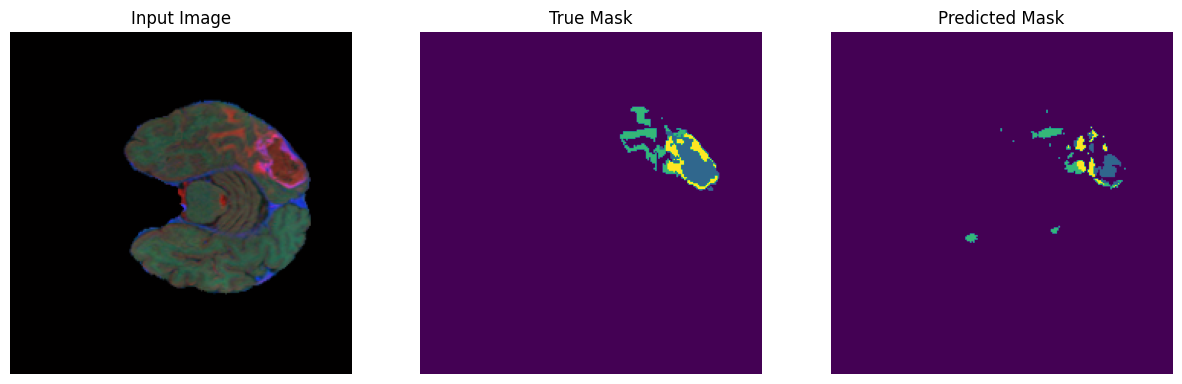

1/1 [==============================] - 0s 72ms/step


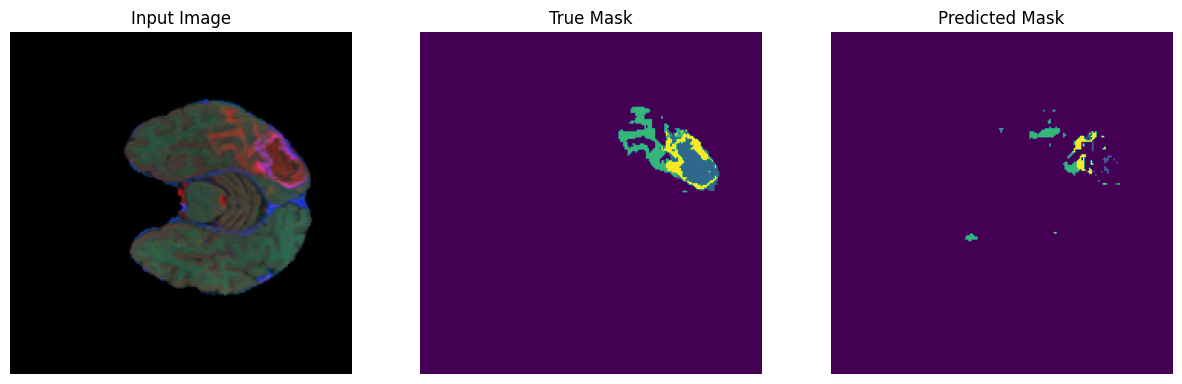

1/1 [==============================] - 0s 72ms/step


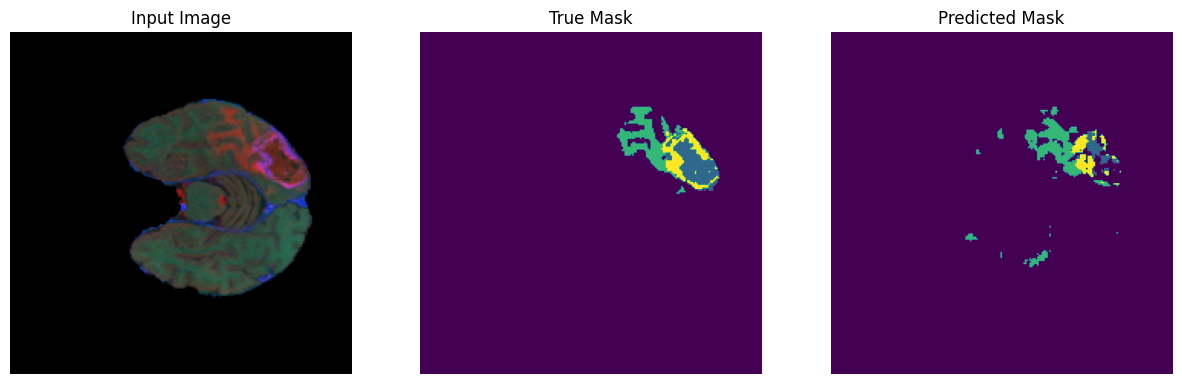

1/1 [==============================] - 0s 75ms/step


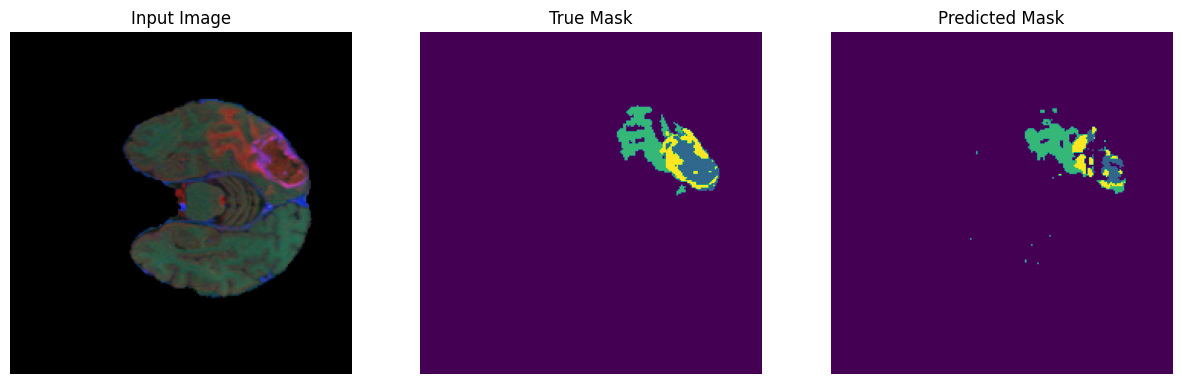

1/1 [==============================] - 0s 71ms/step


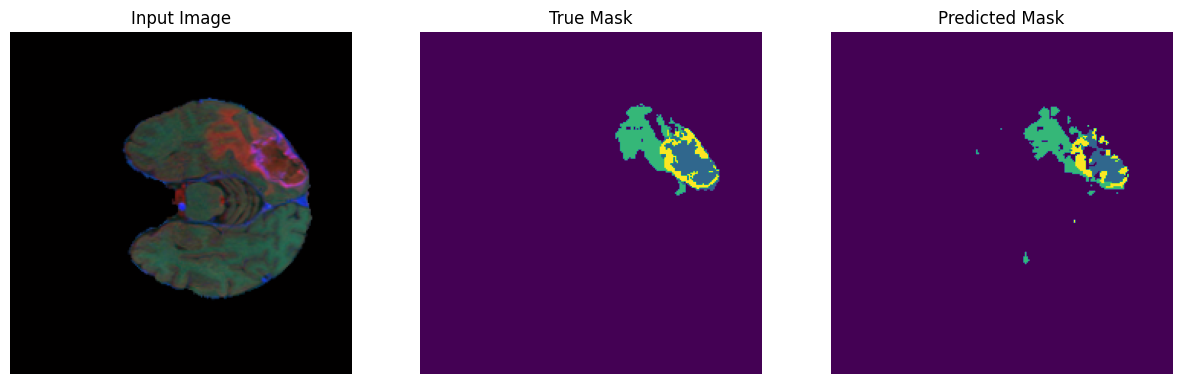

1/1 [==============================] - 0s 71ms/step


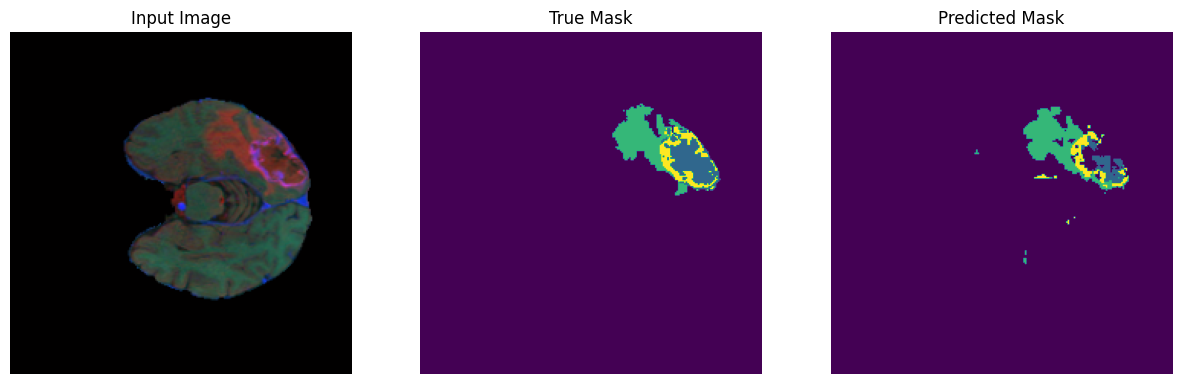

1/1 [==============================] - 0s 72ms/step


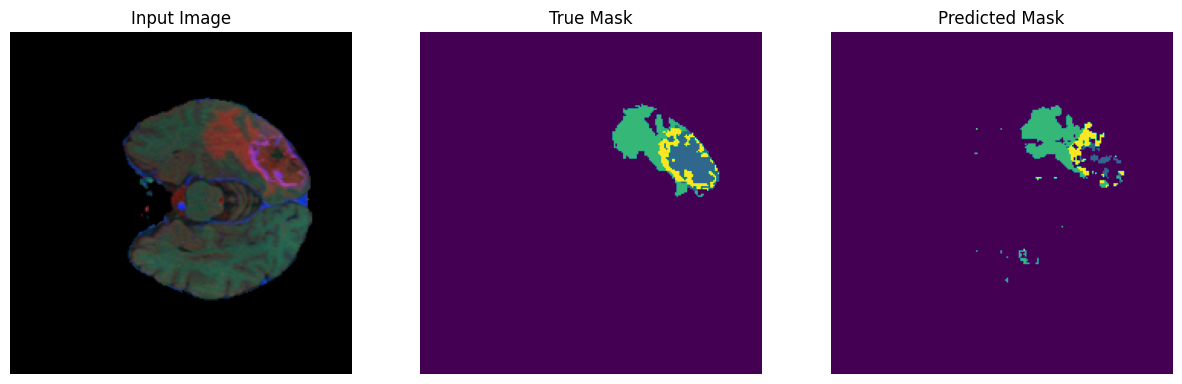

1/1 [==============================] - 0s 76ms/step


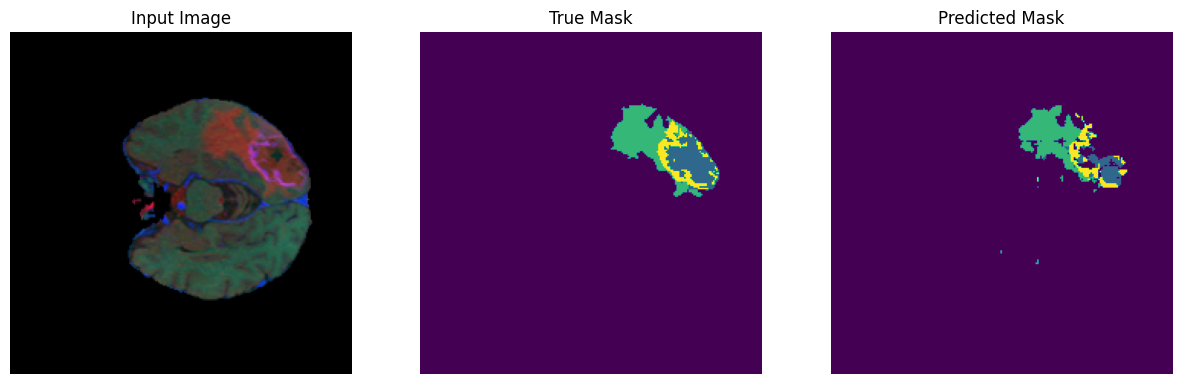

1/1 [==============================] - 0s 71ms/step


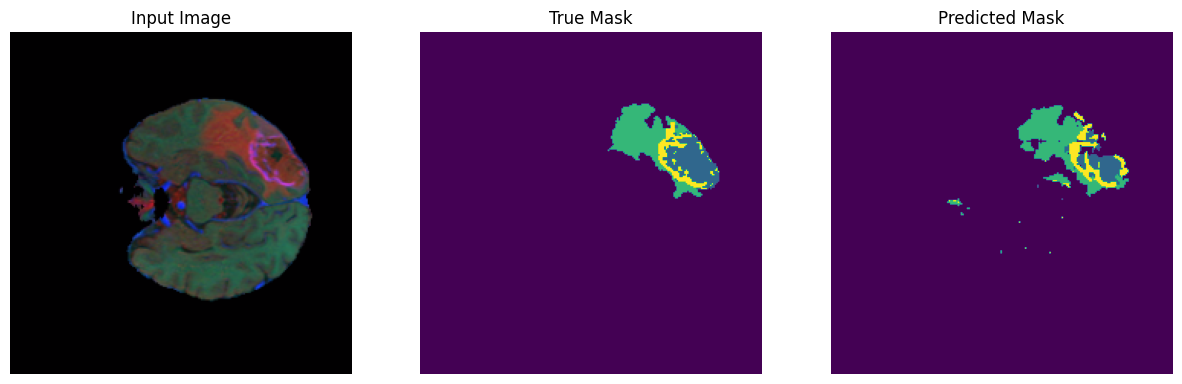

1/1 [==============================] - 0s 75ms/step


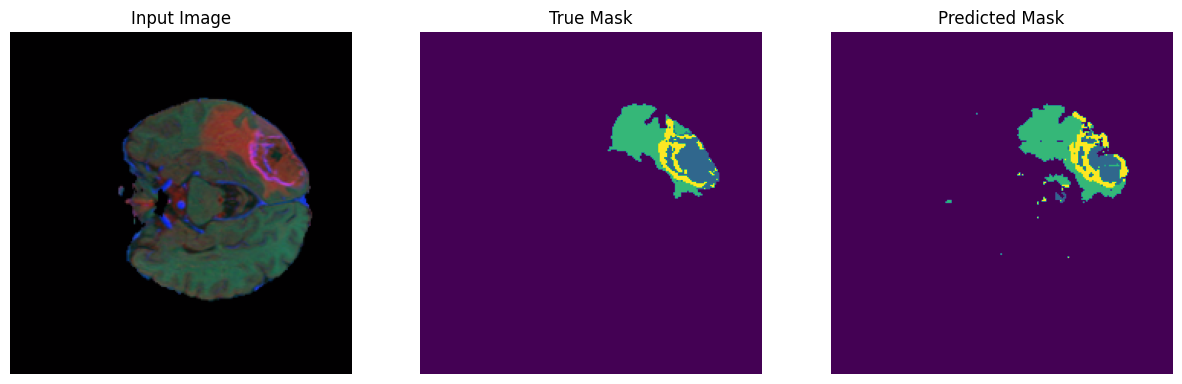

In [45]:
show_predictions(num=50)

In [16]:
image.shape

TensorShape([224, 224, 3])

In [45]:
mask

<tf.Tensor: shape=(224, 224, 1), dtype=int8, numpy=
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=int8)>

In [47]:
OUTPUT_CLASSES = 4

model2 = unet_model(output_channels=OUTPUT_CLASSES)
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              weighted_metrics=tf.keras.metrics.SparseCategoricalAccuracy()
              )

In [48]:
EPOCHS = 2
STEPS_PER_EPOCH = len(train_df)//BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(val_df)//BATCH_SIZE

model_history = model2.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          verbose=1)

Epoch 1/2
418/418 [==============================] - 133s 319ms/step - loss: 5.7445e-04 - accuracy: 0.9659 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.0044 - val_accuracy: 0.9881 - val_sparse_categorical_accuracy: 0.8096
Epoch 2/2
418/418 [==============================] - 135s 323ms/step - loss: 3.2522e-04 - accuracy: 0.9920 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.0046 - val_accuracy: 0.9882 - val_sparse_categorical_accuracy: 0.8159


In [49]:
def show_predictions2(dataset=None, num=1):
  i = 0
  for sample_image, sample_mask in test_df.take(num):
    display([sample_image, sample_mask,
              create_mask(model2.predict(sample_image[tf.newaxis, ...]))])
    i += 1
    if i > num: break 

1/1 [==============================] - 0s 80ms/step


c:\Users\Heichous\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


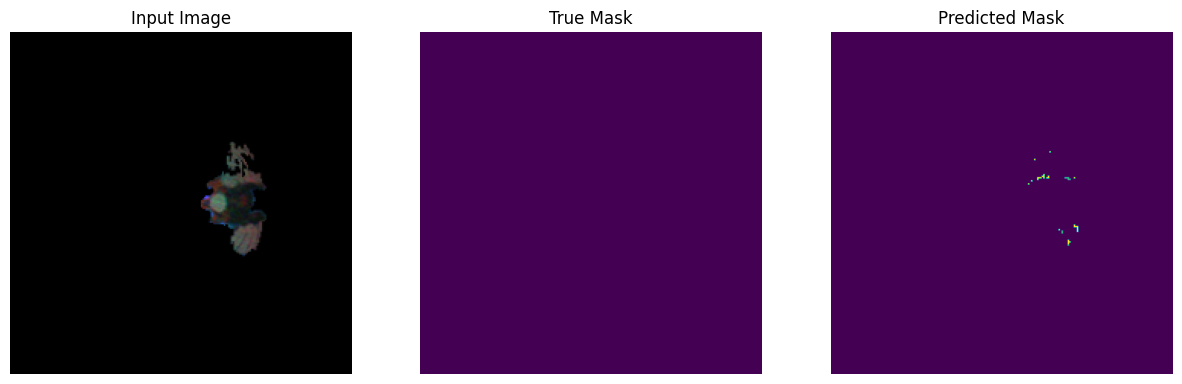

1/1 [==============================] - 0s 81ms/step


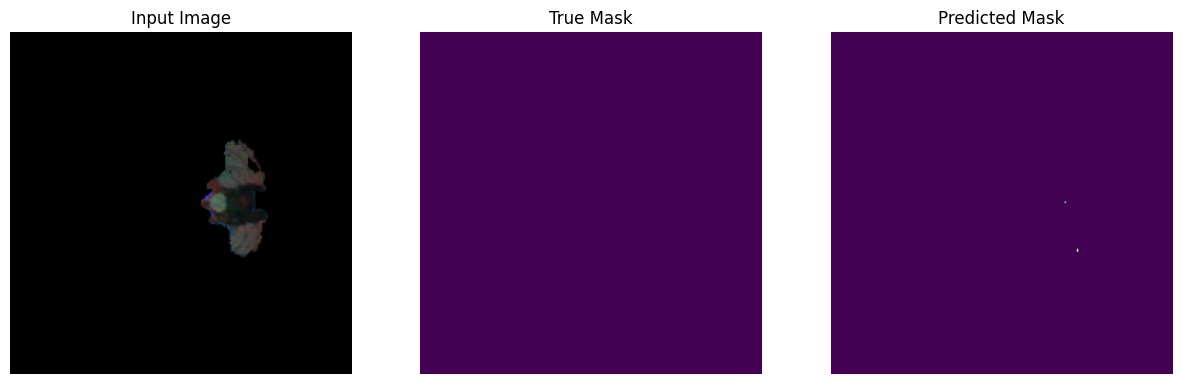

1/1 [==============================] - 0s 83ms/step


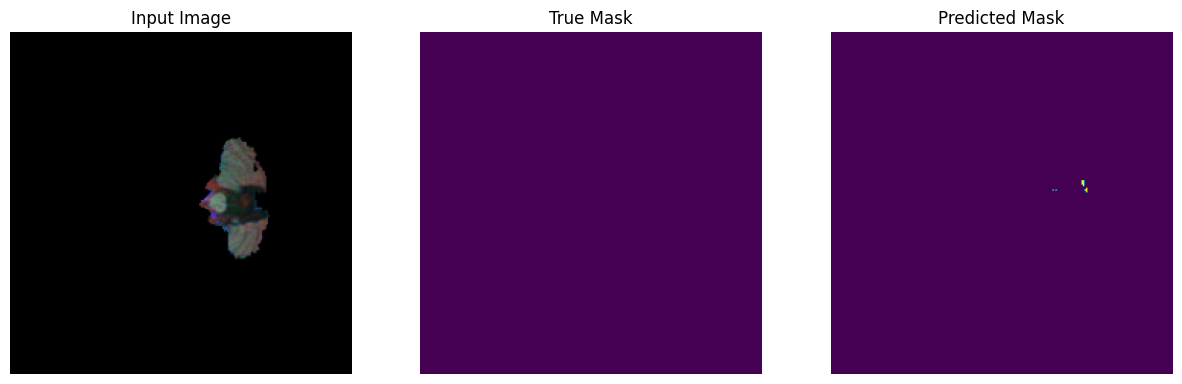

1/1 [==============================] - 0s 80ms/step


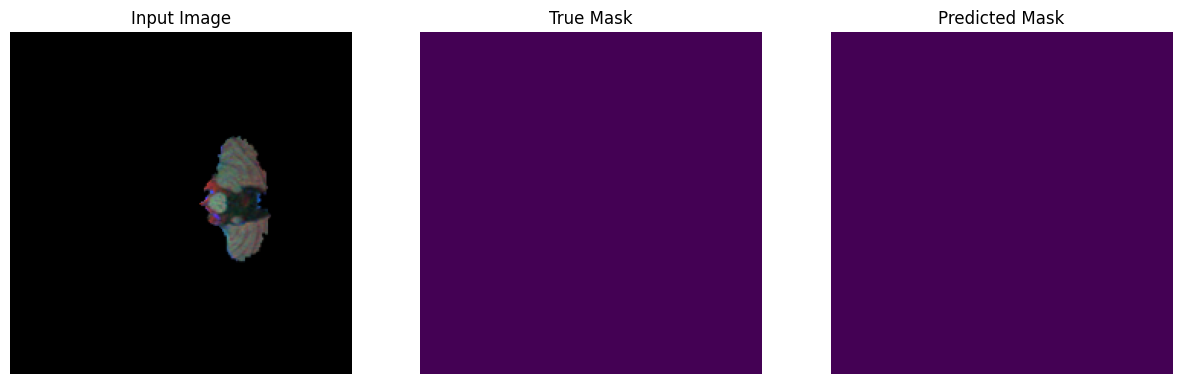

1/1 [==============================] - 0s 76ms/step


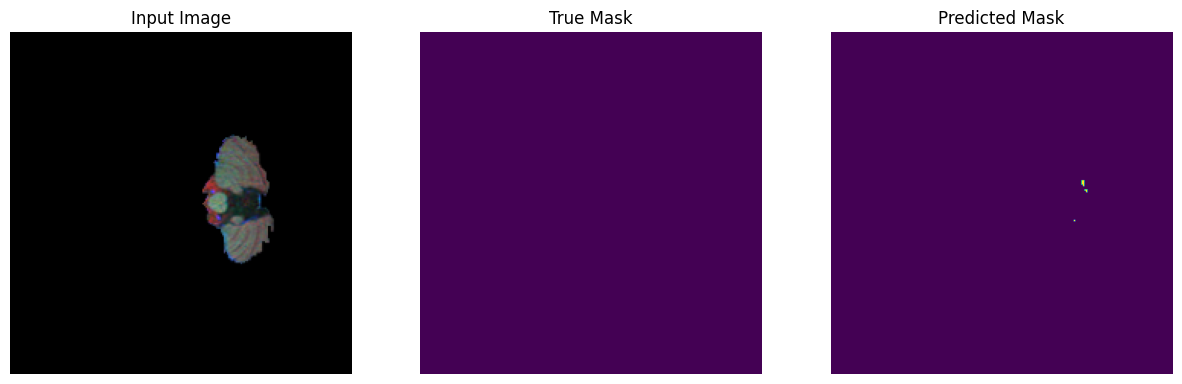

1/1 [==============================] - 0s 87ms/step


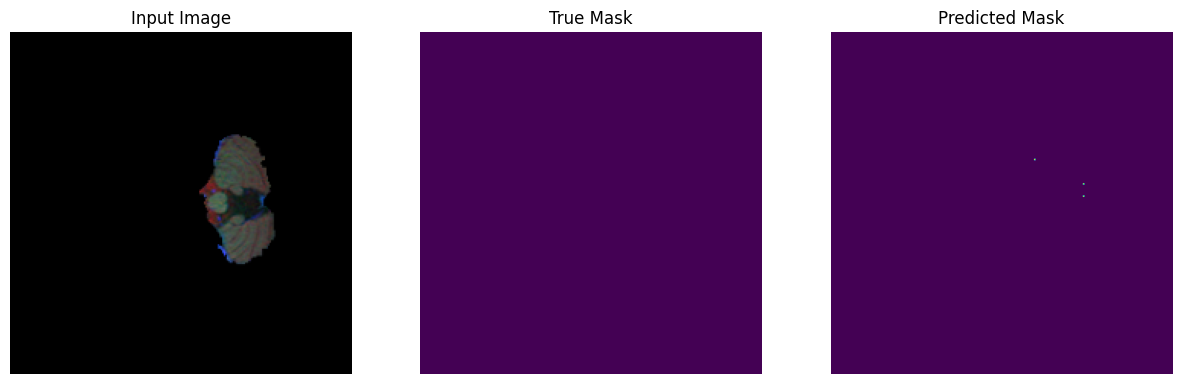

1/1 [==============================] - 0s 75ms/step


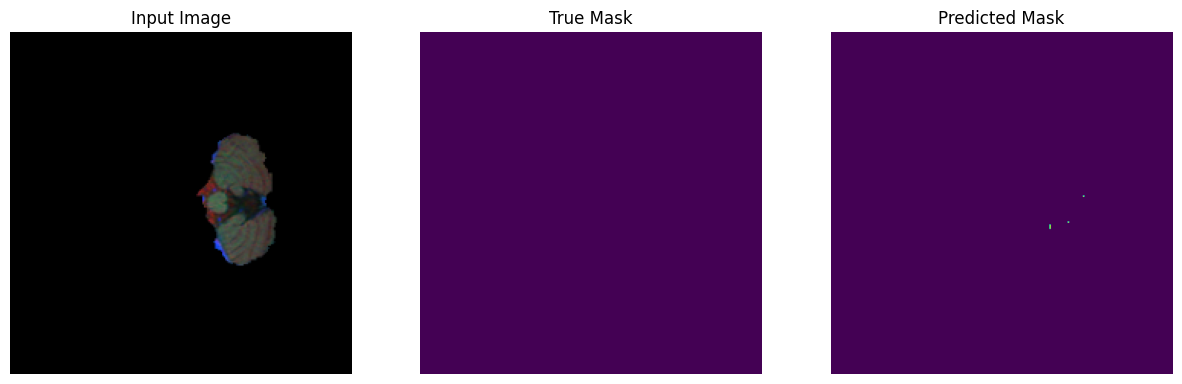

1/1 [==============================] - 0s 77ms/step


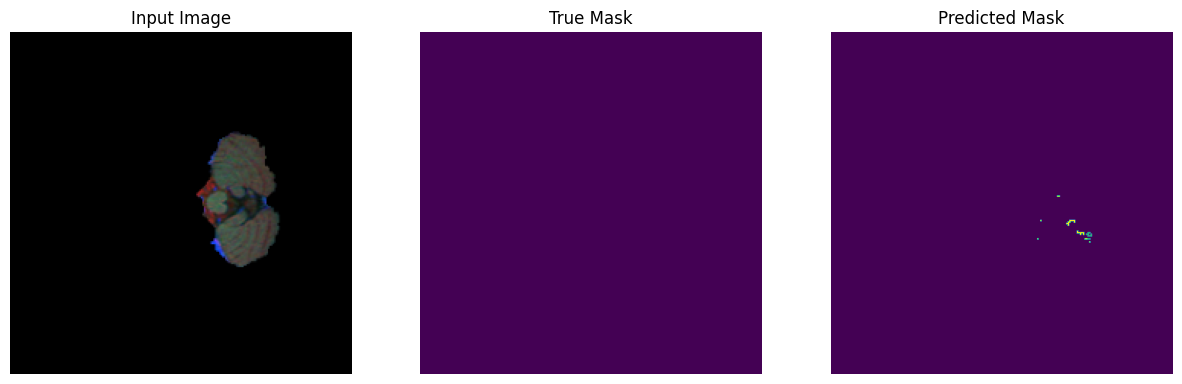

1/1 [==============================] - 0s 74ms/step


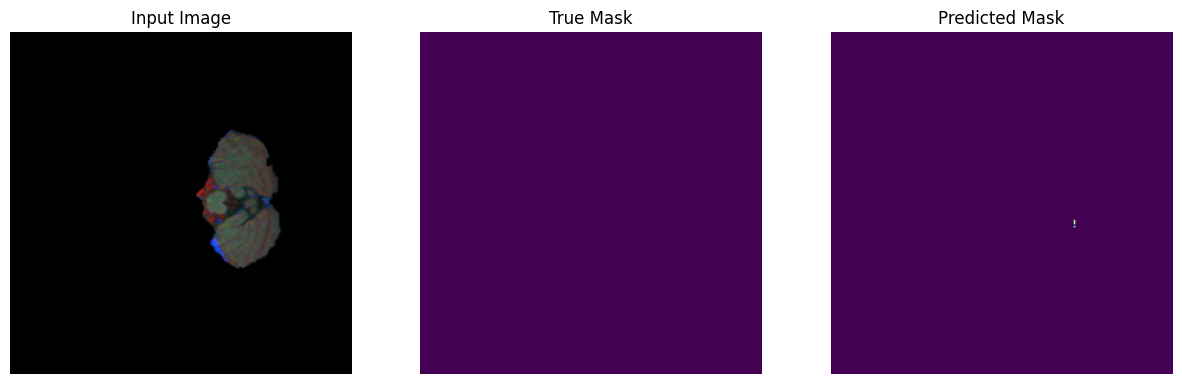

1/1 [==============================] - 0s 73ms/step


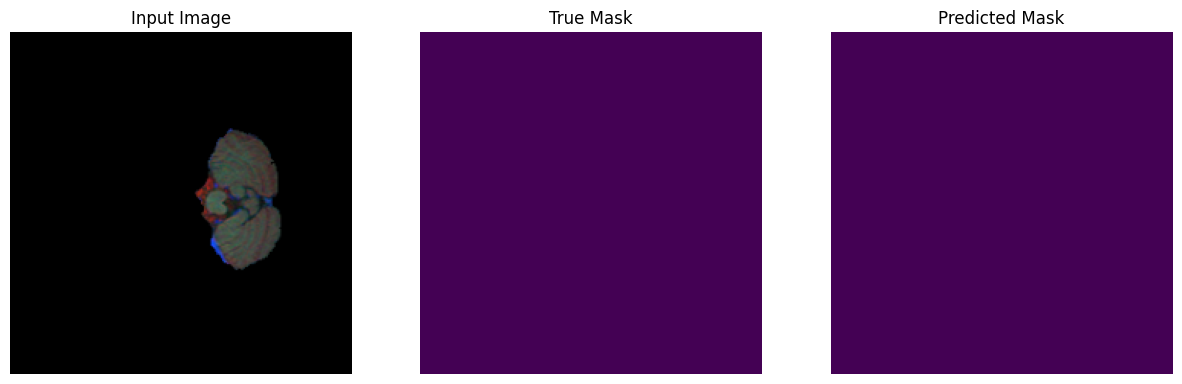

1/1 [==============================] - 0s 73ms/step


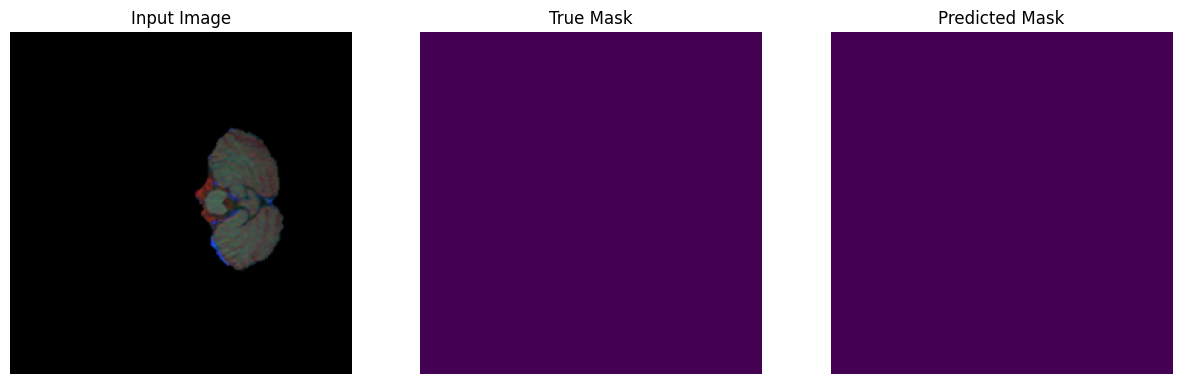

1/1 [==============================] - 0s 71ms/step


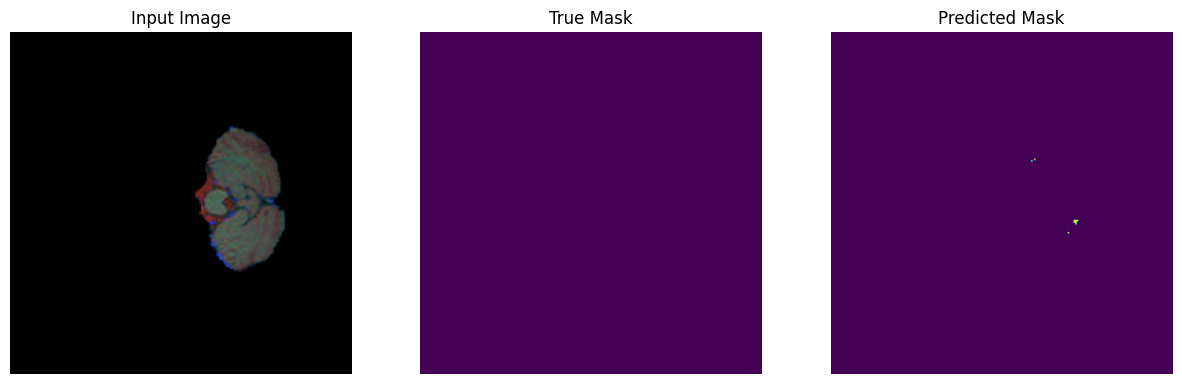

1/1 [==============================] - 0s 77ms/step


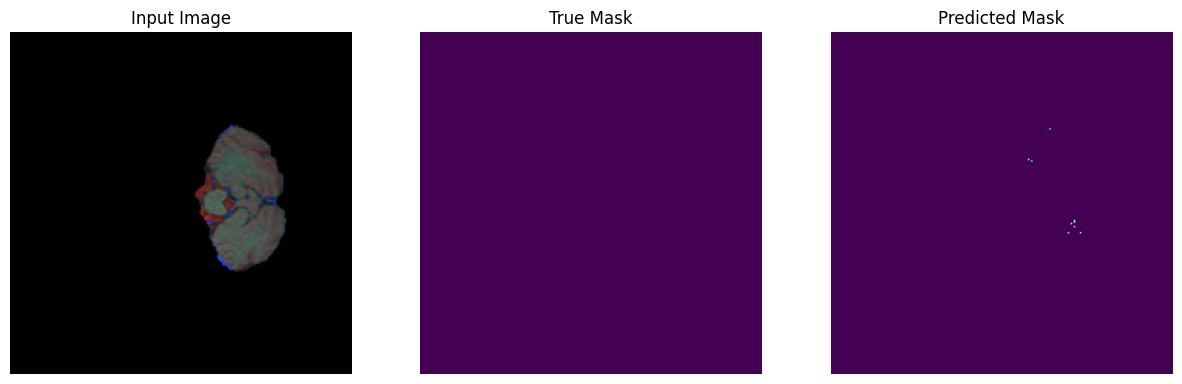

1/1 [==============================] - 0s 72ms/step


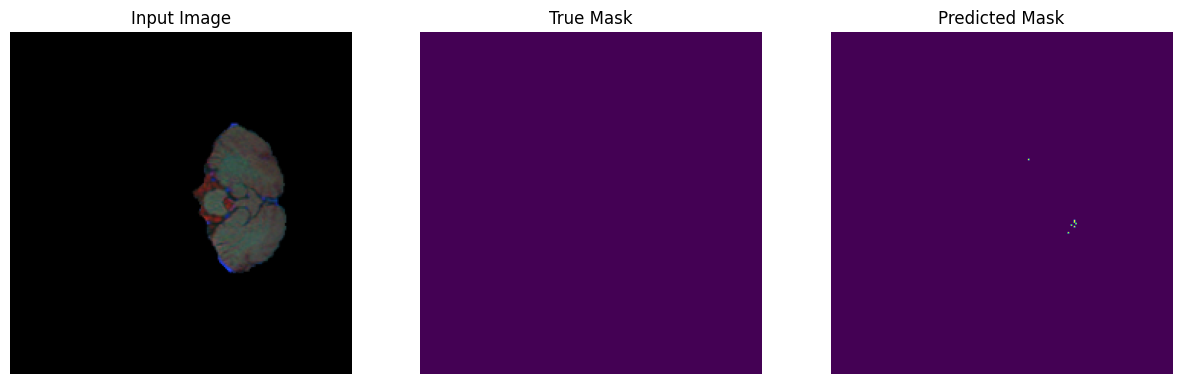

1/1 [==============================] - 0s 72ms/step


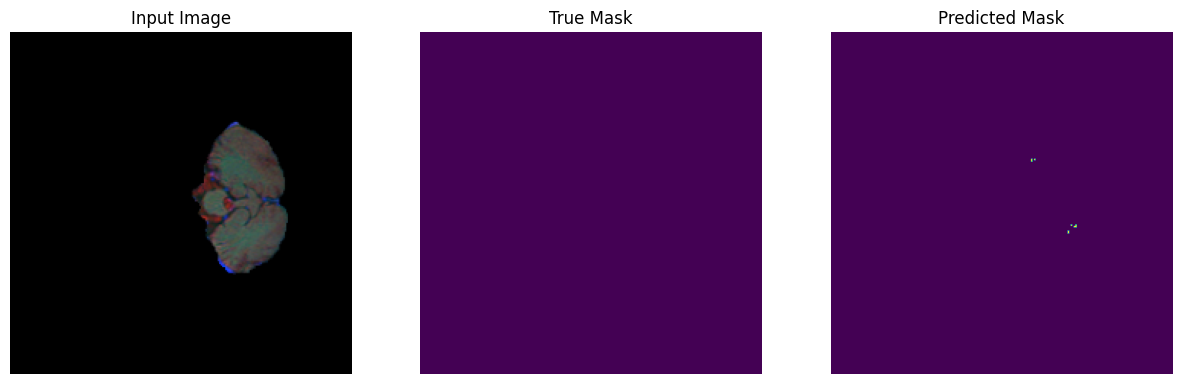

1/1 [==============================] - 0s 75ms/step


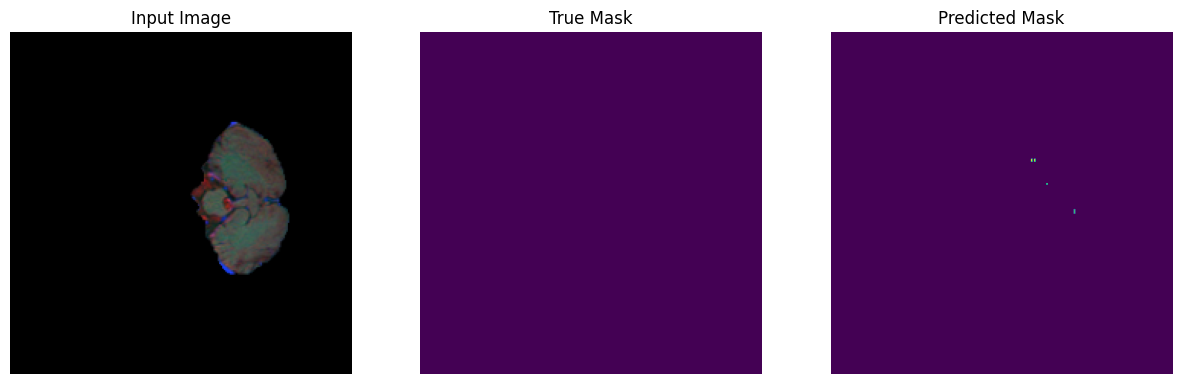

1/1 [==============================] - 0s 74ms/step


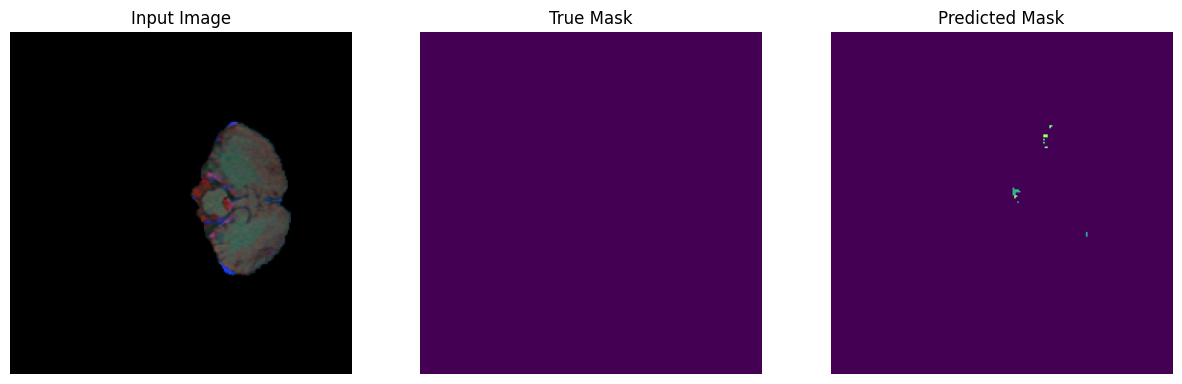

1/1 [==============================] - 0s 70ms/step


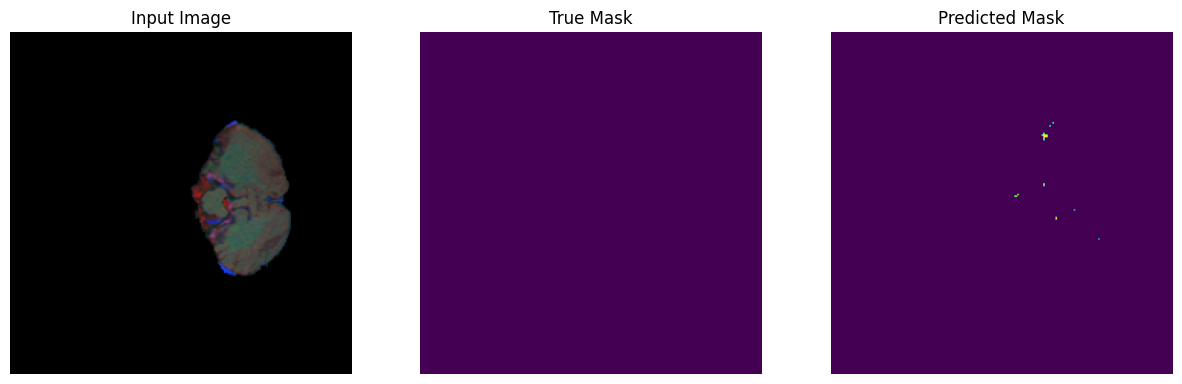

1/1 [==============================] - 0s 70ms/step


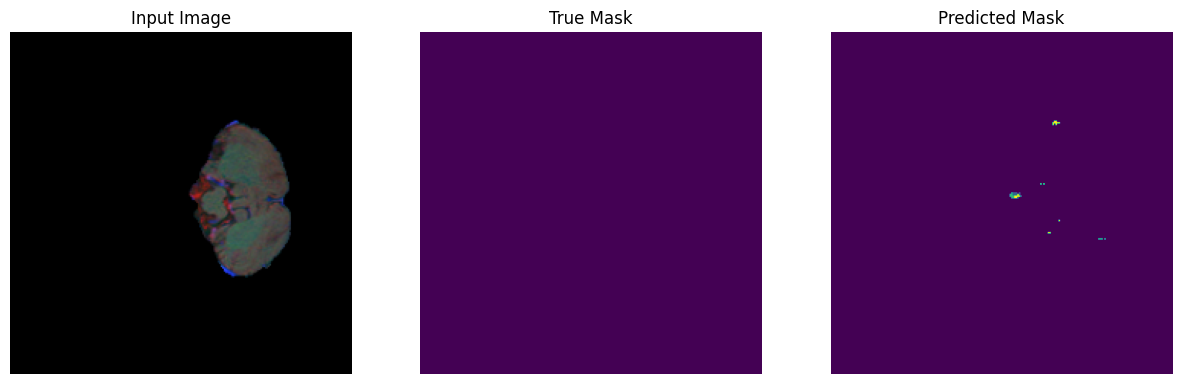

1/1 [==============================] - 0s 71ms/step


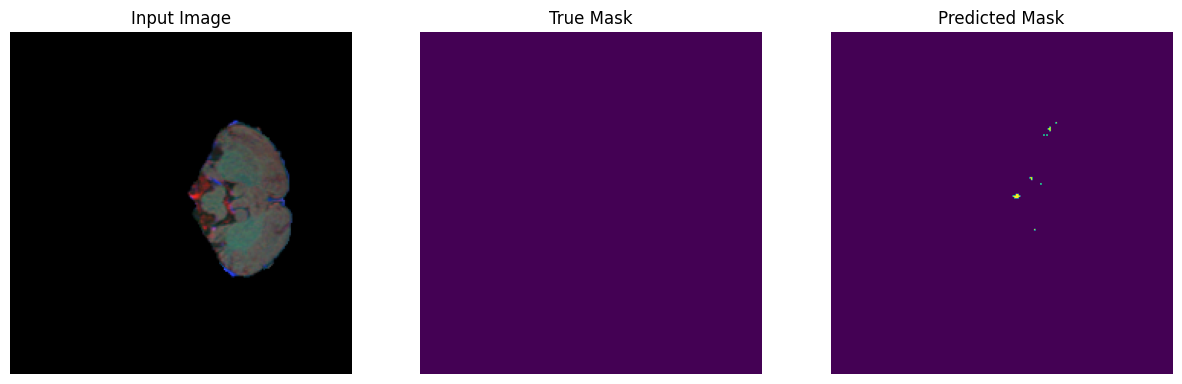

1/1 [==============================] - 0s 74ms/step


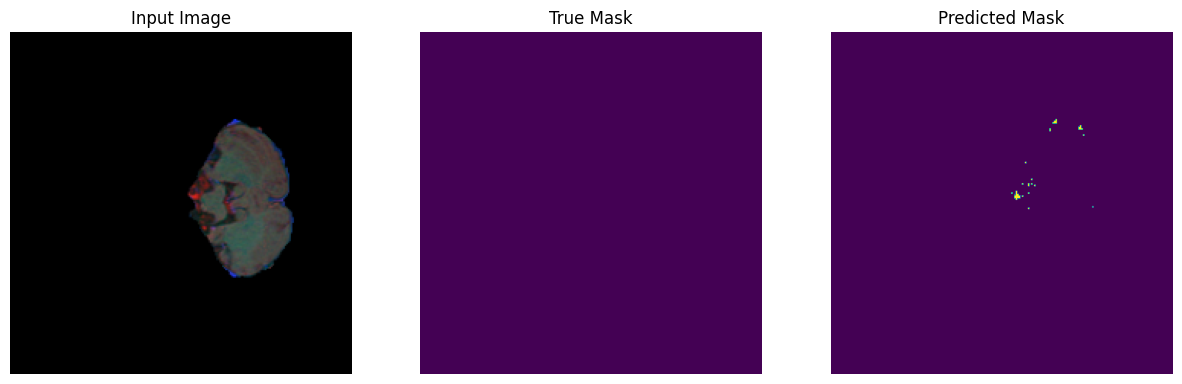

1/1 [==============================] - 0s 71ms/step


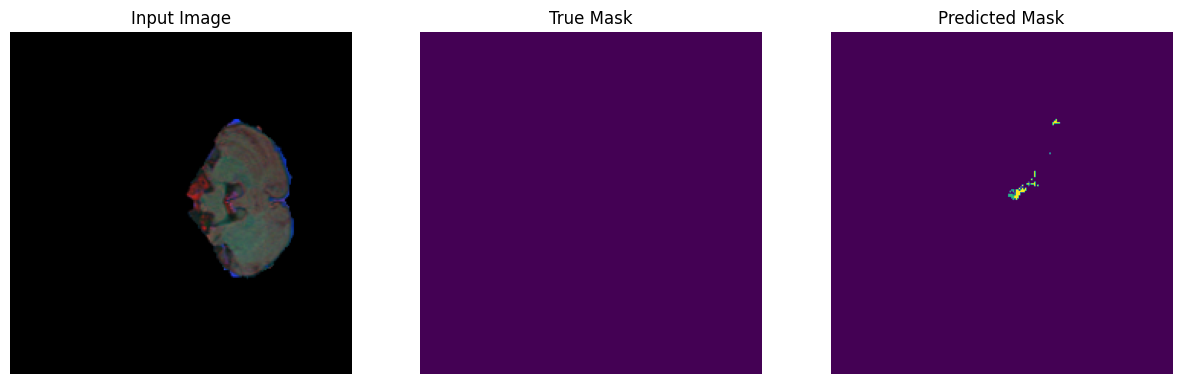

1/1 [==============================] - 0s 71ms/step


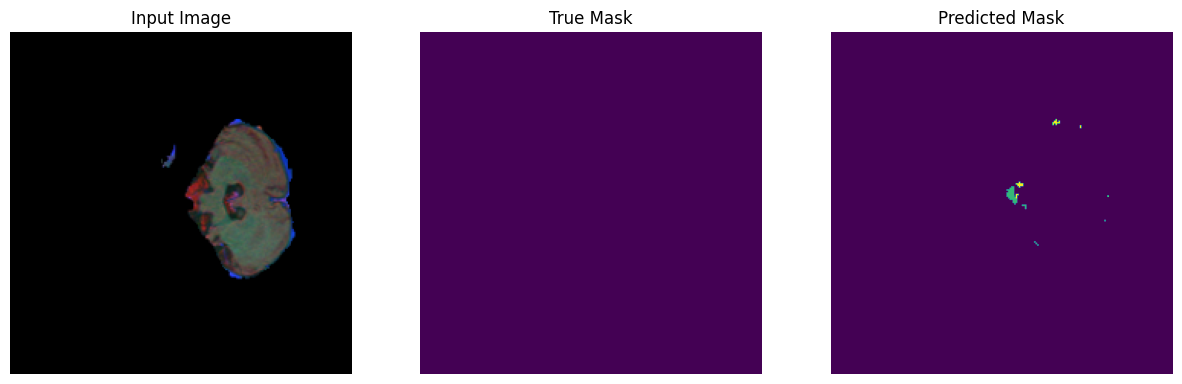

1/1 [==============================] - 0s 72ms/step


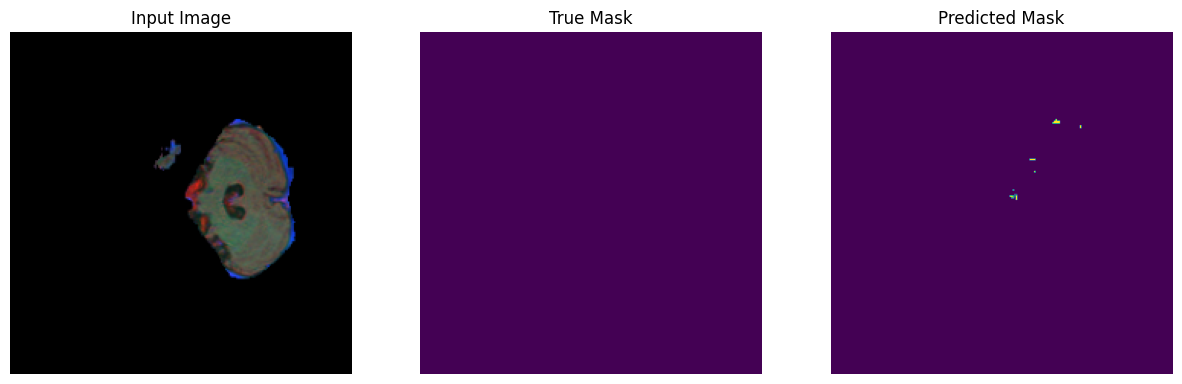

1/1 [==============================] - 0s 73ms/step


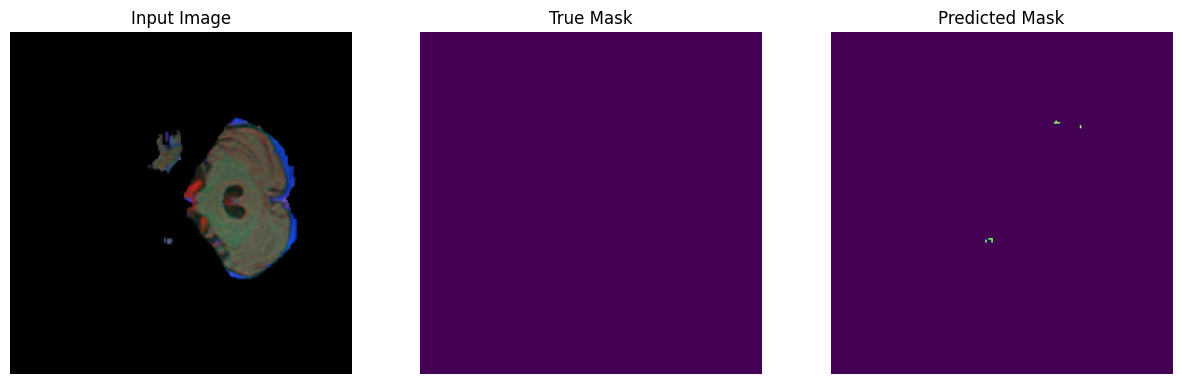

1/1 [==============================] - 0s 72ms/step


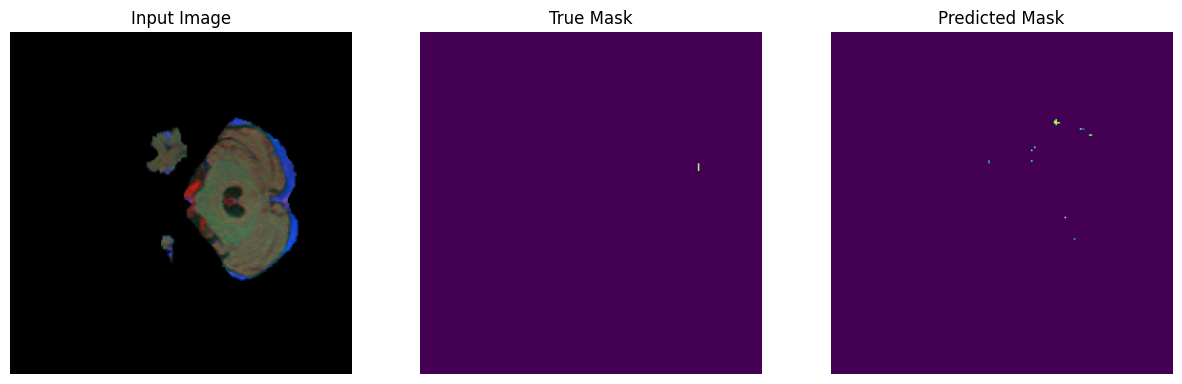

1/1 [==============================] - 0s 72ms/step


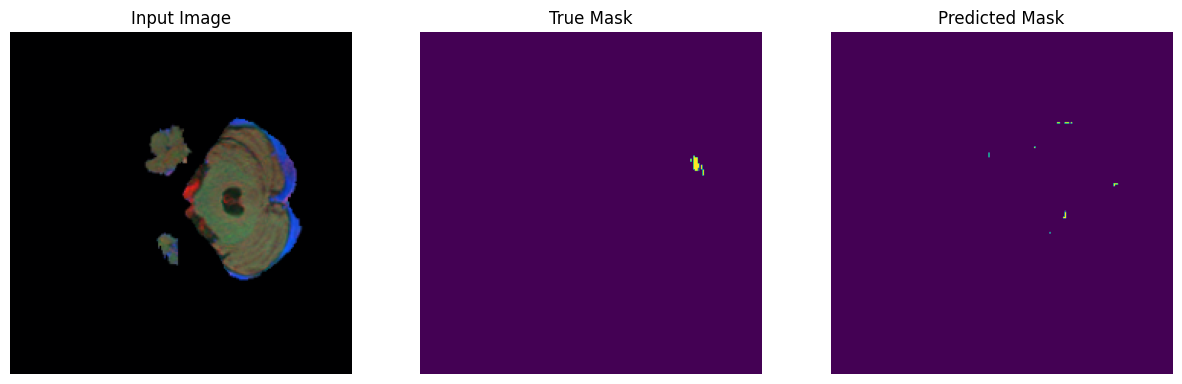

1/1 [==============================] - 0s 70ms/step


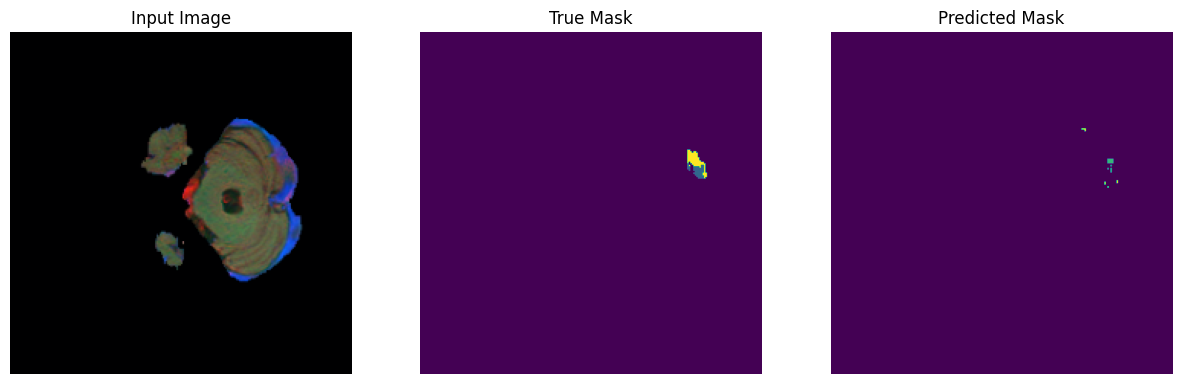

1/1 [==============================] - 0s 79ms/step


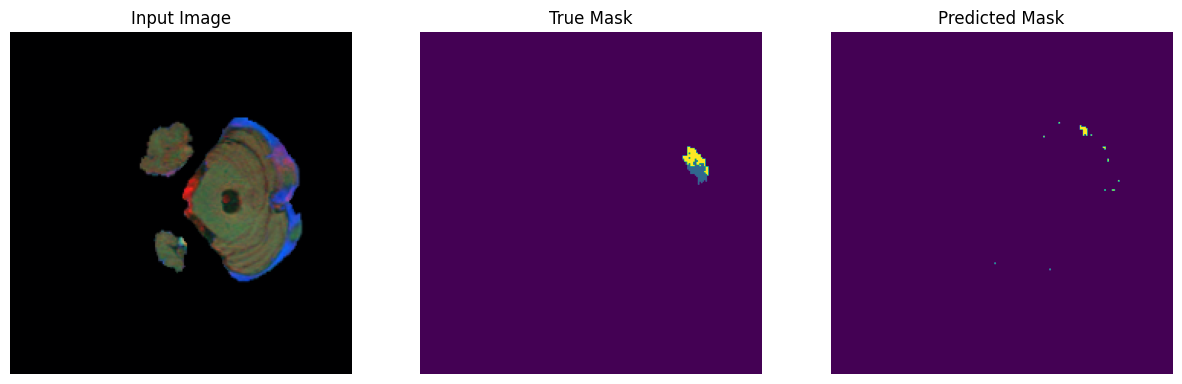

1/1 [==============================] - 0s 75ms/step


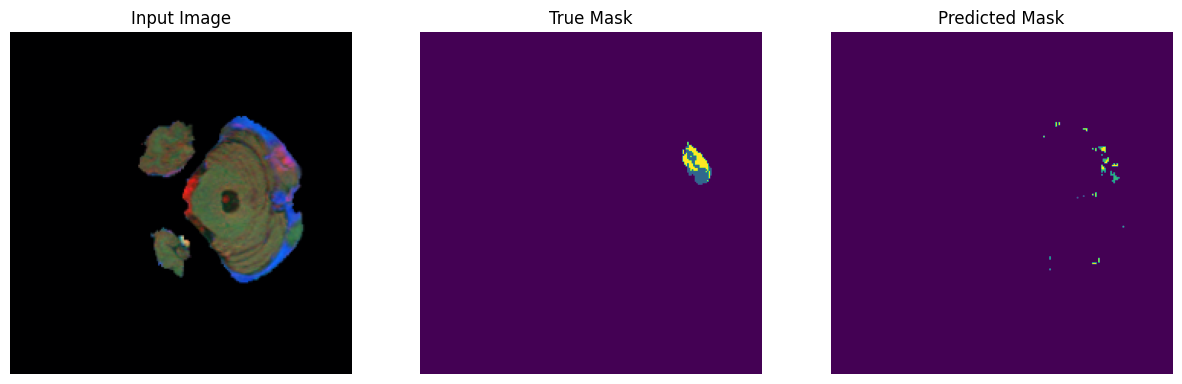

1/1 [==============================] - 0s 74ms/step


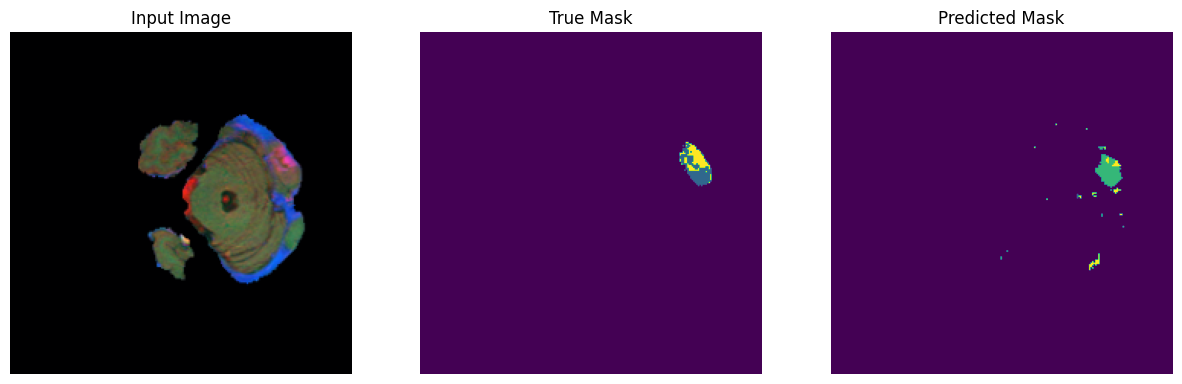

1/1 [==============================] - 0s 75ms/step


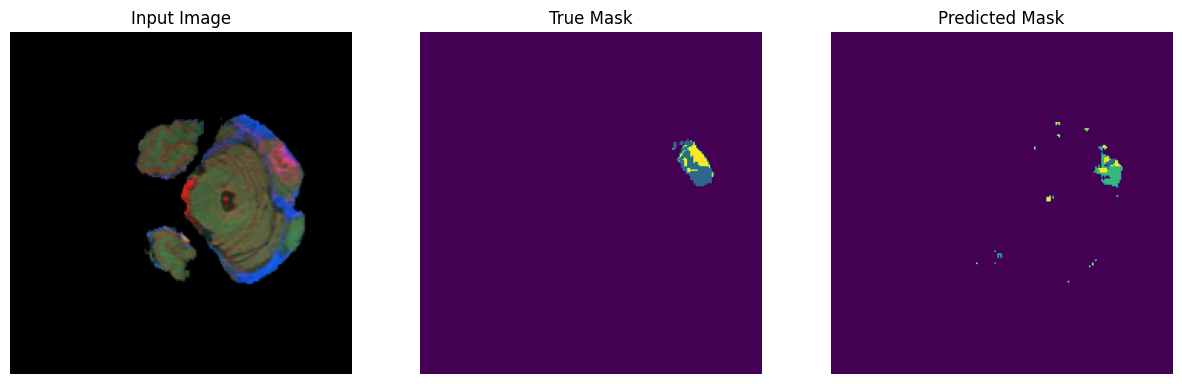

1/1 [==============================] - 0s 72ms/step


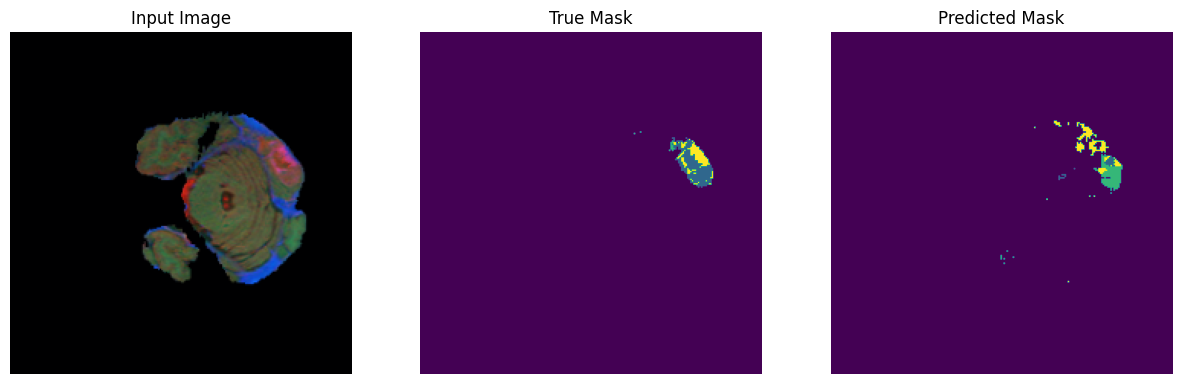

1/1 [==============================] - 0s 73ms/step


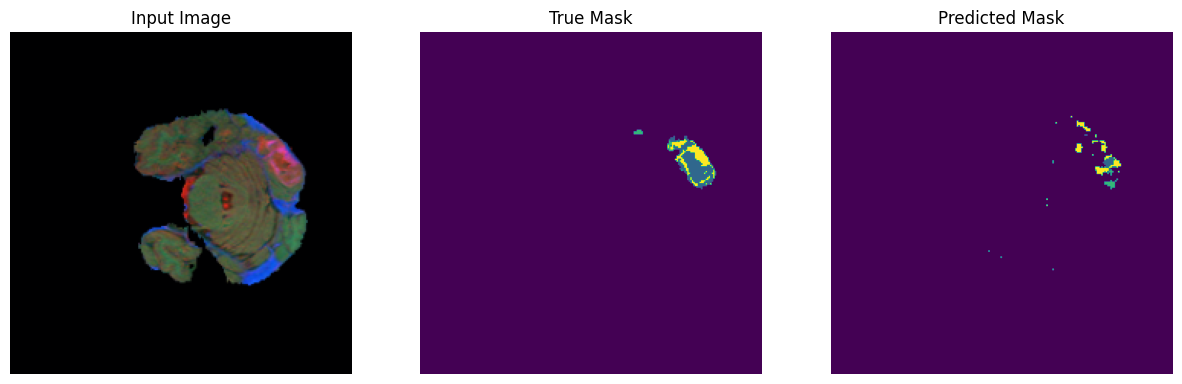

1/1 [==============================] - 0s 87ms/step


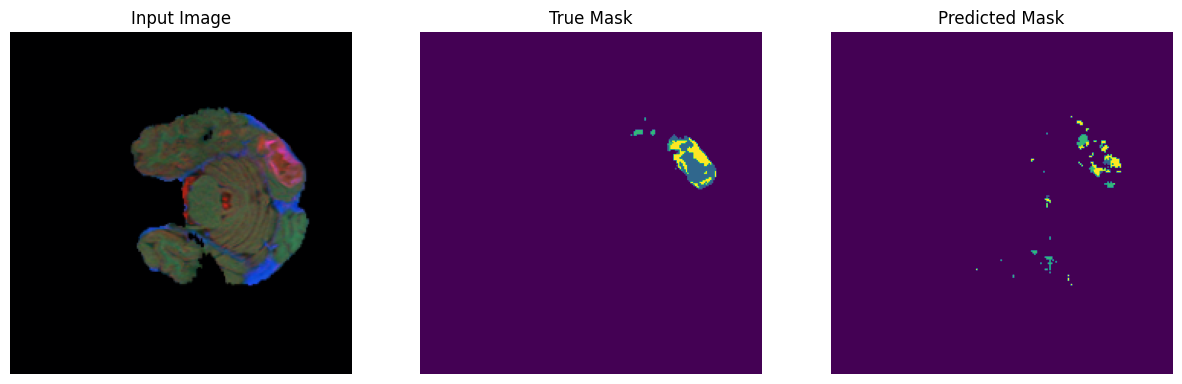

1/1 [==============================] - 0s 71ms/step


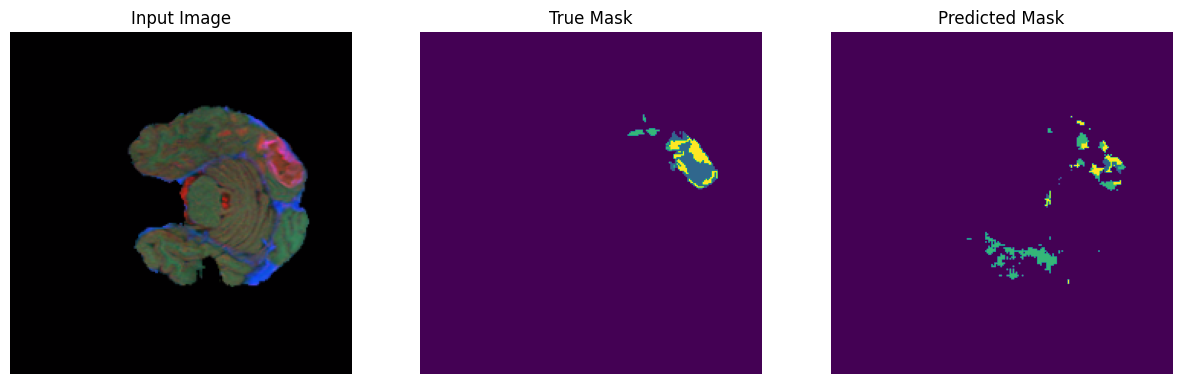

1/1 [==============================] - 0s 80ms/step


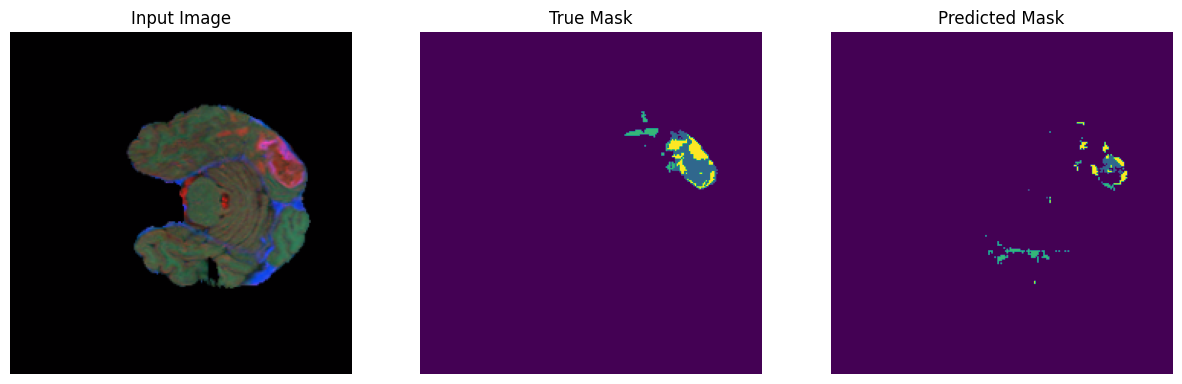

1/1 [==============================] - 0s 72ms/step


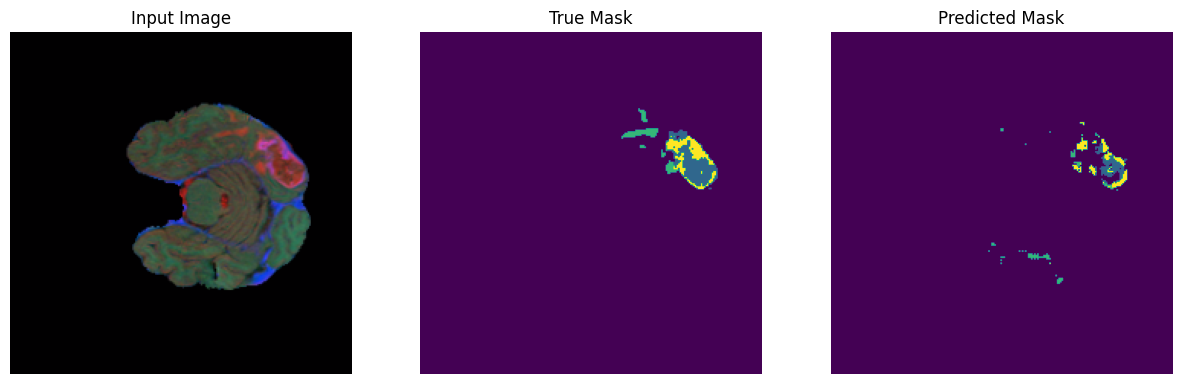

1/1 [==============================] - 0s 72ms/step


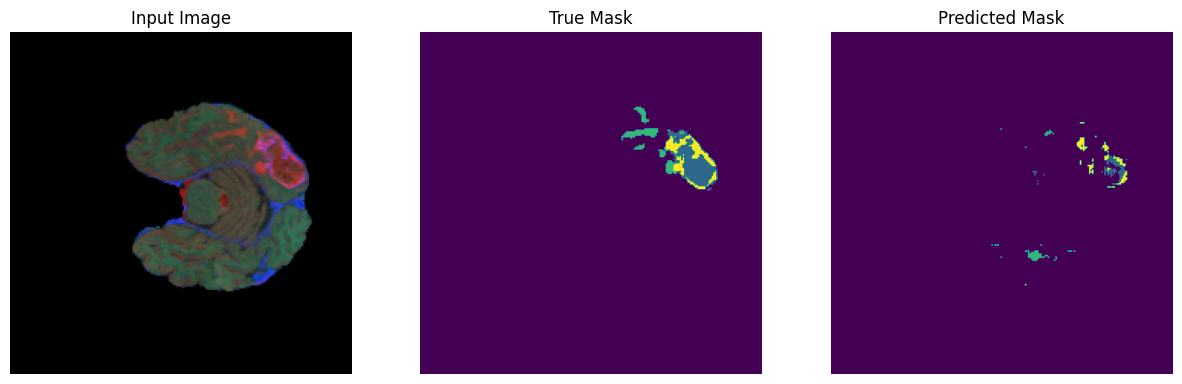

1/1 [==============================] - 0s 74ms/step


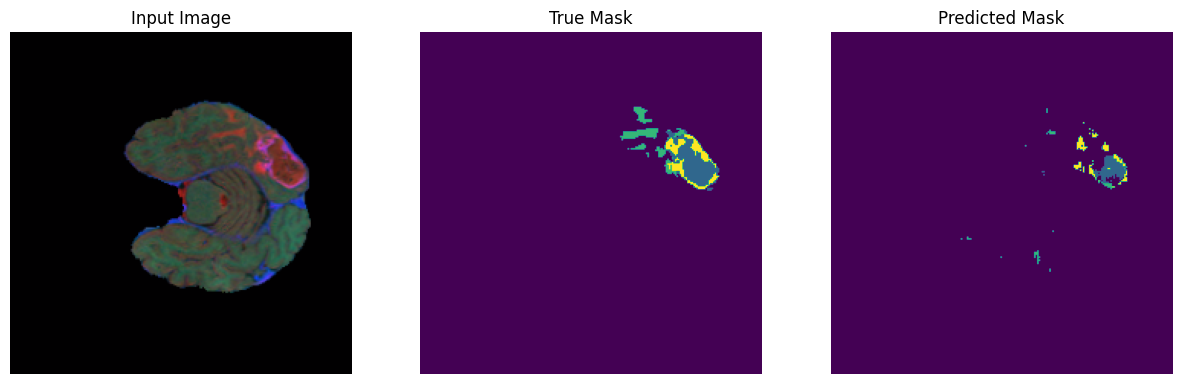

1/1 [==============================] - 0s 72ms/step


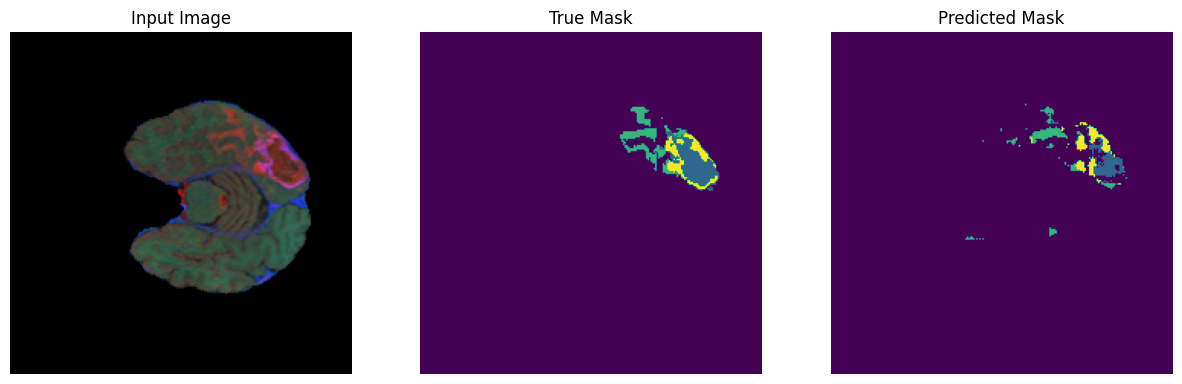

1/1 [==============================] - 0s 71ms/step


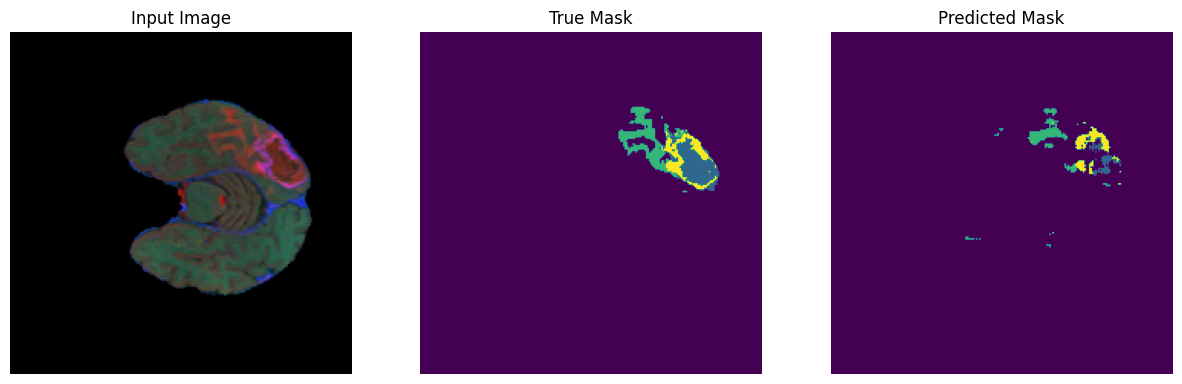

1/1 [==============================] - 0s 74ms/step


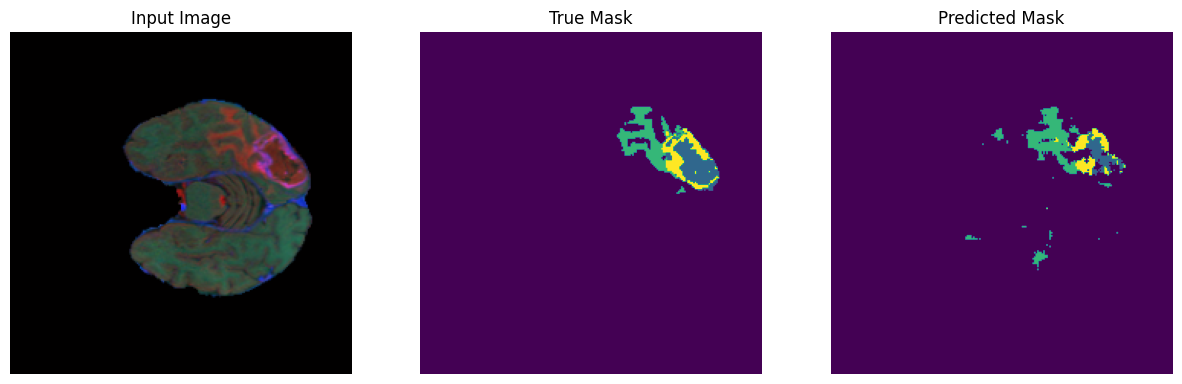

1/1 [==============================] - 0s 72ms/step


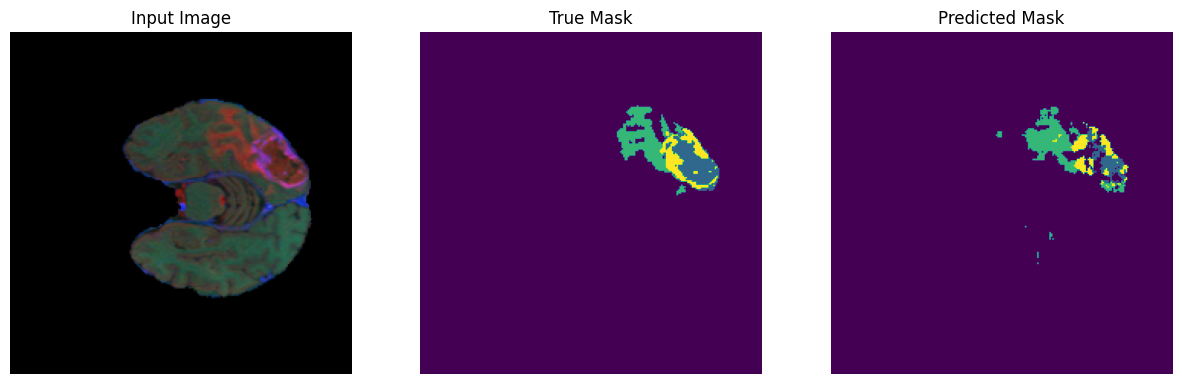

1/1 [==============================] - 0s 71ms/step


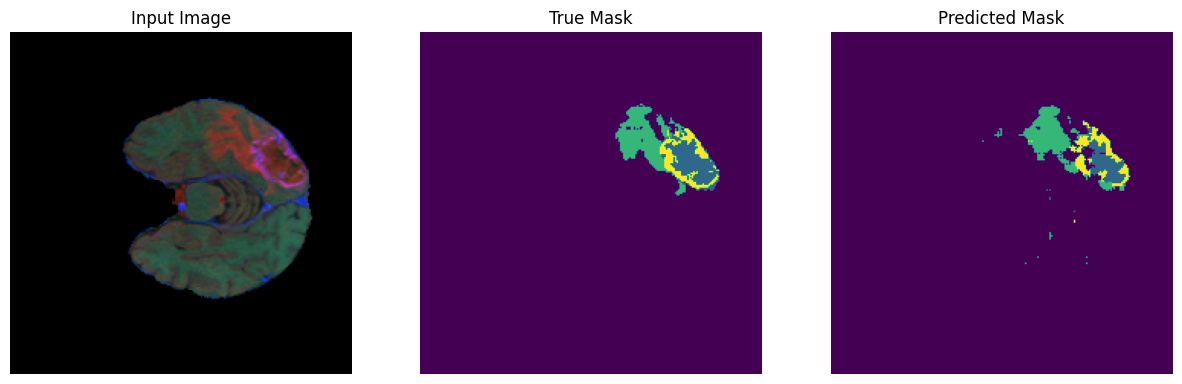

1/1 [==============================] - 0s 74ms/step


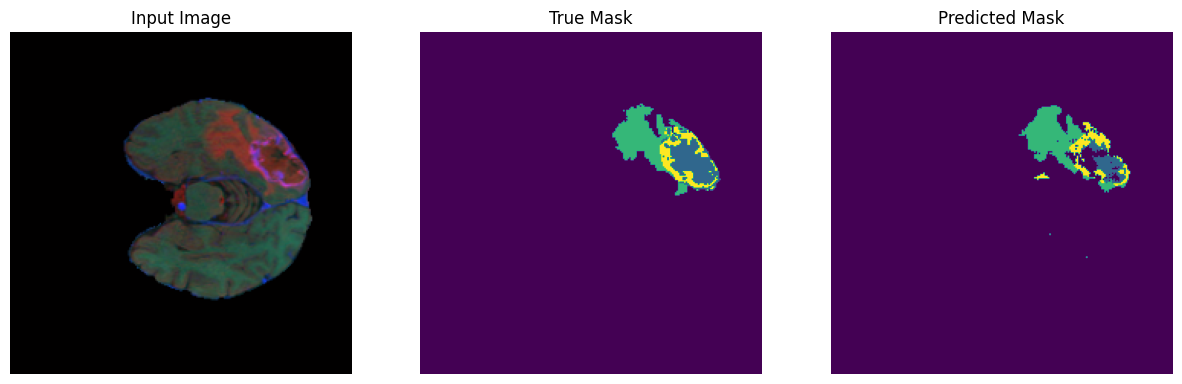

1/1 [==============================] - 0s 79ms/step


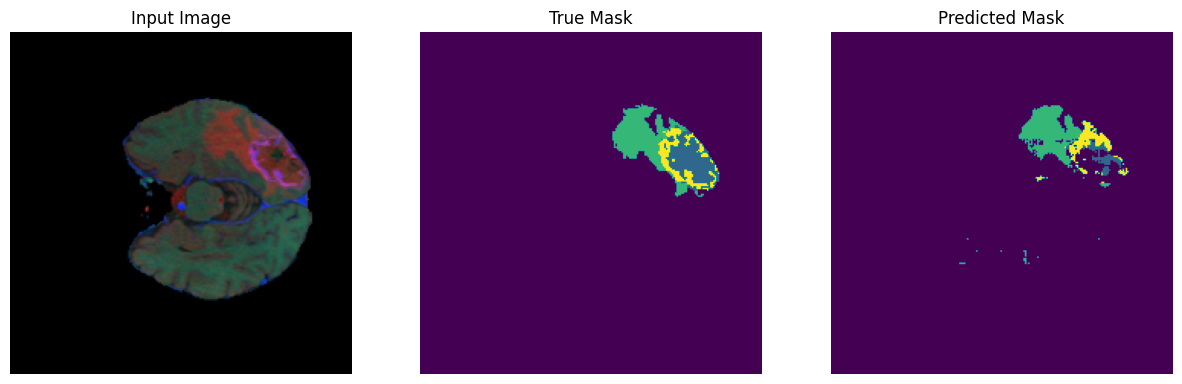

1/1 [==============================] - 0s 74ms/step


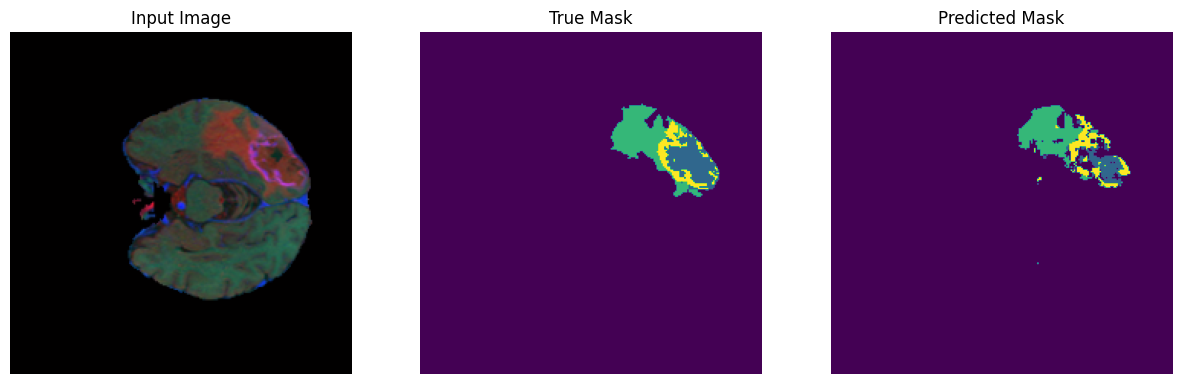

1/1 [==============================] - 0s 74ms/step


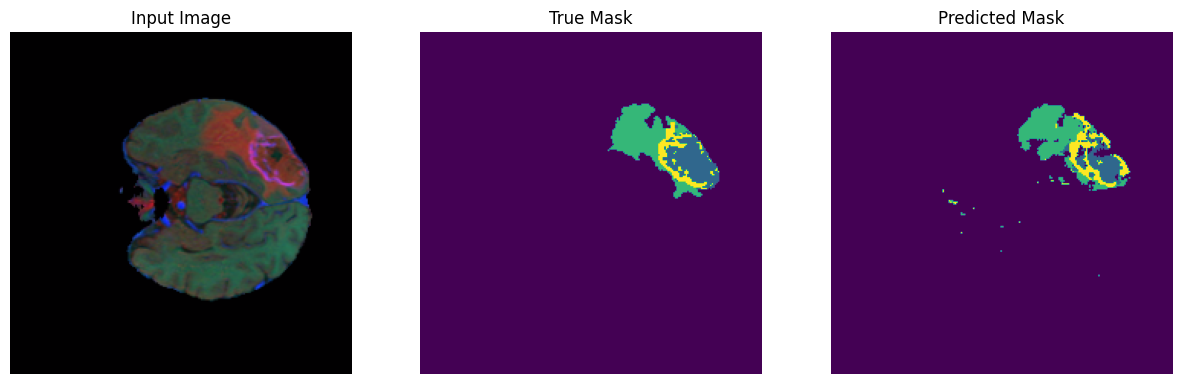

1/1 [==============================] - 0s 72ms/step


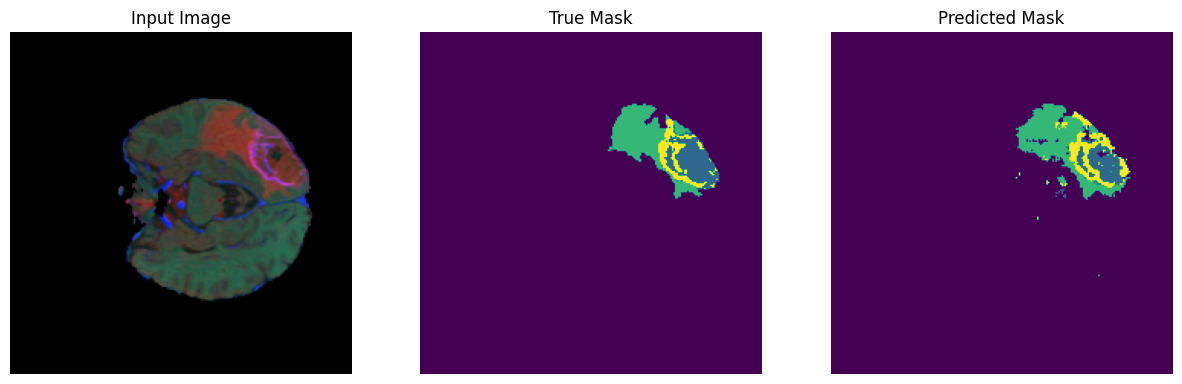

In [52]:
show_predictions2(num=50)

In [ ]:
weights = {}
for l in c.keys():
    weights[l] = len(labels) / (len(c.keys())*c[l])

In [32]:
weights 

{0.0: 0.2529521239613546,
 2.0: 35.27676392588986,
 3.0: 127.19027186540713,
 1.0: 95.48159451736876}

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Conv2DTranspose, UpSampling2D
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

In [139]:
#Your code here
base_model = Sequential([
    Conv2D(32, (5, 5), activation="relu", strides=1, padding="same", input_shape=(240, 240, 4, )), # 240x240x1
    MaxPool2D(name="1"),
    Conv2D(64, (5, 5), padding="same", activation="relu"), # 120x120x32
    MaxPool2D(name="2"),
    Conv2D(128, (5, 5), padding="same", activation="relu"), # 60x60x64
    MaxPool2D(name="3"),
    Conv2D(256, (5, 5), padding="same", activation="relu", name="4"), # 30x30x128
                                                                        
                                                                      # 30x30x256
    ])

# Use the activations of these layers
layer_names = [
    '1',
    '2',
    '3',
    '4',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = True

In [129]:
up_stack = [
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.Sequential([
        UpSampling2D(size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    ]), # 60x60
    tf.keras.Sequential([
        UpSampling2D(size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    ]), # 60x60
    tf.keras.Sequential([
        UpSampling2D(size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    ]), # 60x60
]

In [130]:
def unet_model_from_scratch(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[240, 240, 4])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    print("hey")
    print(skip.shape)
    x = up(x)
    print(x.shape)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [140]:
tf.config.run_functions_eagerly(True)
def load_datapoint(datapoint):
    with h5py.File(f"{ DATA_PATH2 }{ datapoint.numpy().decode('utf-8') }",'r') as f:
        image = np.array(f["image"])[:, :, :4]
        mask = np.array(f["mask"])
        mask = mask[:, :, 0] + 2 * mask[:, :, 1] + 3 * mask[:, :, 2]
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        mask = tf.convert_to_tensor(mask, dtype=tf.int8)
        mask = tf.expand_dims(mask, axis=-1)

        # Resize to sizes supported by pretrained encoder
        #image = tf.image.resize(image, (ENCODER_IMG_DIM, ENCODER_IMG_DIM))
        #mask = tf.image.resize(
        #    mask, 
        #    (ENCODER_IMG_DIM, ENCODER_IMG_DIM),
        #    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
        #    )
    
    return image, mask 

def load_datapoint_tf(datapoint):
    image, mask = tf.py_function(load_datapoint, [datapoint], [tf.float32, tf.int8])
    return image, mask

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([0.25, 35.0, 127.0, 95.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [141]:
# Create datasets
train_df = tf.data.Dataset.from_tensor_slices(metadata_train["slice_path"].to_numpy())
train_df = train_df.map(load_datapoint_tf)

val_df = tf.data.Dataset.from_tensor_slices(metadata_val["slice_path"].to_numpy())
val_df = val_df.map(load_datapoint_tf)

test_df = tf.data.Dataset.from_tensor_slices(metadata_test["slice_path"].to_numpy())
test_df = test_df.map(load_datapoint_tf)

In [142]:
# Data loaders
train_batches = (
    train_df
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
    )

val_batches = (
    val_df
        .cache()
        .batch(BATCH_SIZE)
)
test_batches = test_df.batch(BATCH_SIZE)

train_batches = train_batches.map(add_sample_weights)
val_batches = val_batches.map(add_sample_weights)
test_batches = test_batches.map(add_sample_weights)

In [143]:
OUTPUT_CLASSES = 4

model_from_scratch = unet_model_from_scratch(output_channels=OUTPUT_CLASSES)
model_from_scratch.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              weighted_metrics=tf.keras.metrics.SparseCategoricalAccuracy()
              )

hey
(None, 30, 30, 128)
(None, 30, 30, 64)
hey
(None, 60, 60, 64)
(None, 60, 60, 64)
hey
(None, 120, 120, 32)
(None, 120, 120, 64)


In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_df)//BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(val_df)//BATCH_SIZE

model_history = model_from_scratch.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          verbose=1)

In [94]:
i = train_df.take(1)
down_stack

In [104]:
for el in i:
    print(tf.expand_dims(el[0], axis=0).shape)
    break

(240, 240, 4)
(1, 240, 240, 4)


In [109]:
down_stack(tf.expand_dims(el[0], axis=0))[3]

<tf.Tensor: shape=(1, 30, 30, 256), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ...,

In [146]:
def show_predictions_from_scratch(num):
  i = 0
  for sample_image, sample_mask in test_df.take(num):
    display([sample_image, sample_mask,
              create_mask(model_from_scratch.predict(sample_image[tf.newaxis, ...]))])
    i += 1
    if i > num: break 

c:\Users\Heichous\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 417ms/step


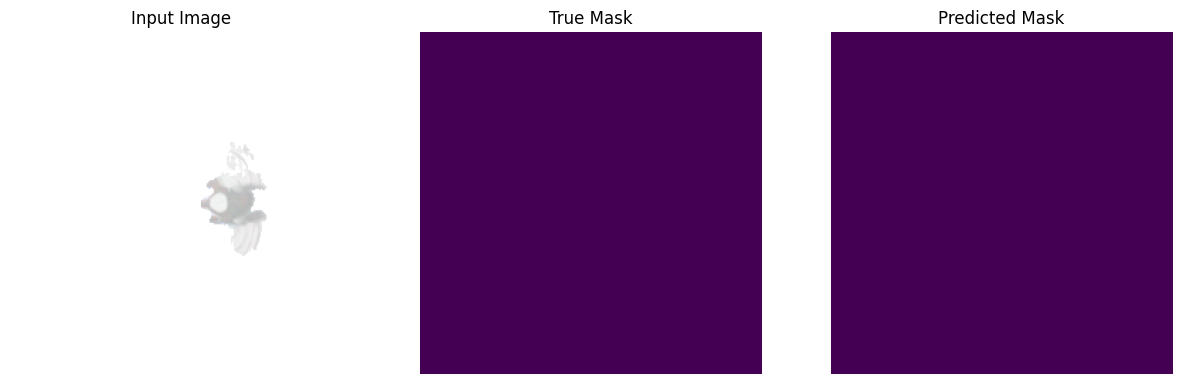

1/1 [==============================] - 0s 38ms/step


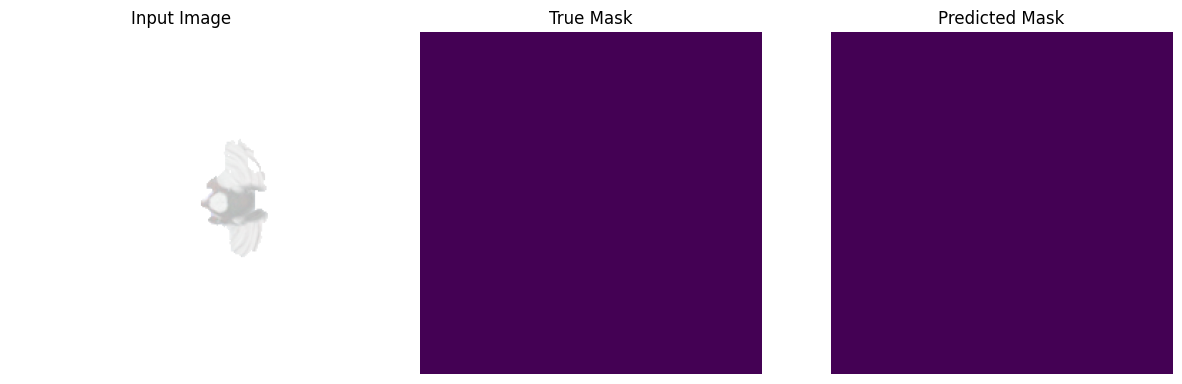

1/1 [==============================] - 0s 54ms/step


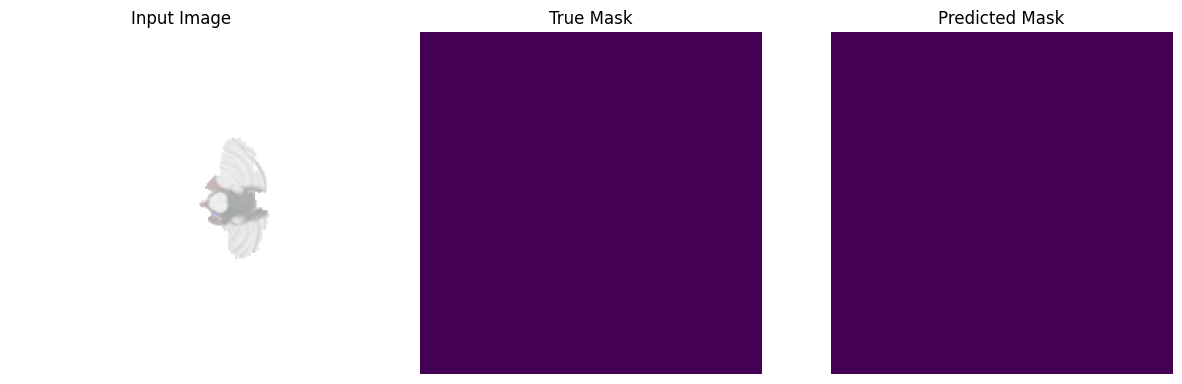

1/1 [==============================] - 0s 33ms/step


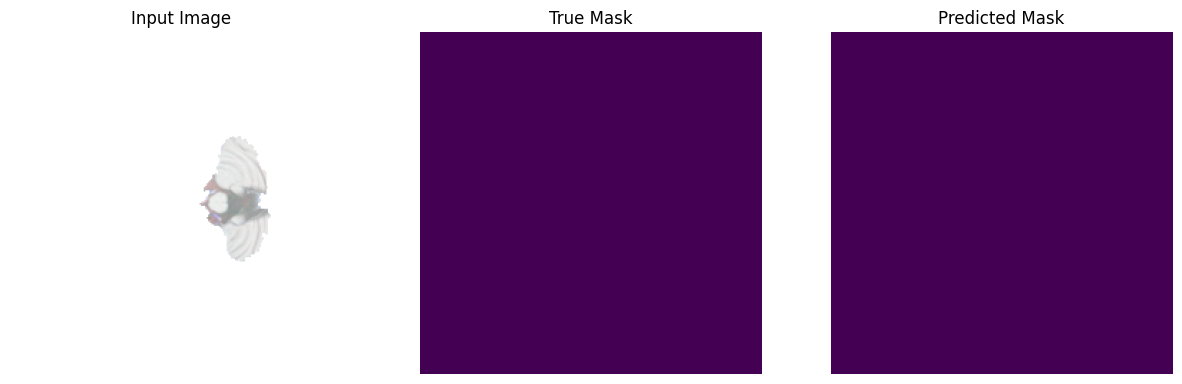

1/1 [==============================] - 0s 40ms/step


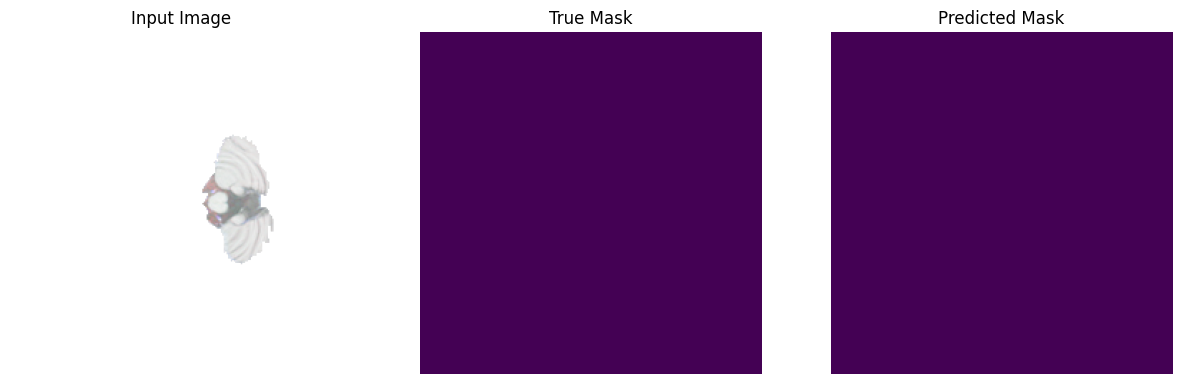

1/1 [==============================] - 0s 42ms/step


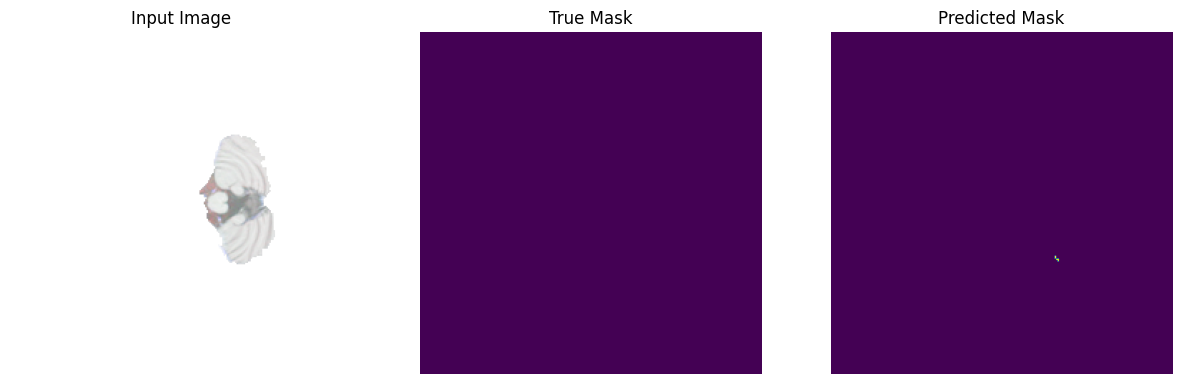

1/1 [==============================] - 0s 38ms/step


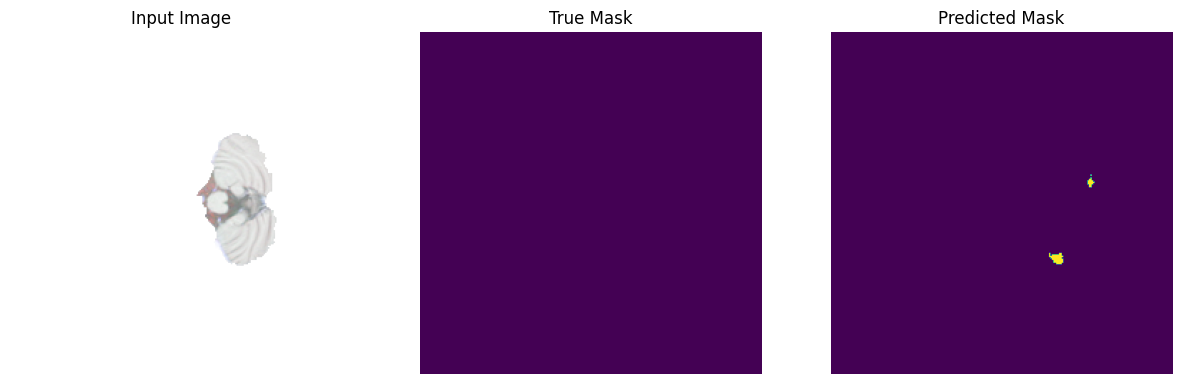

1/1 [==============================] - 0s 33ms/step


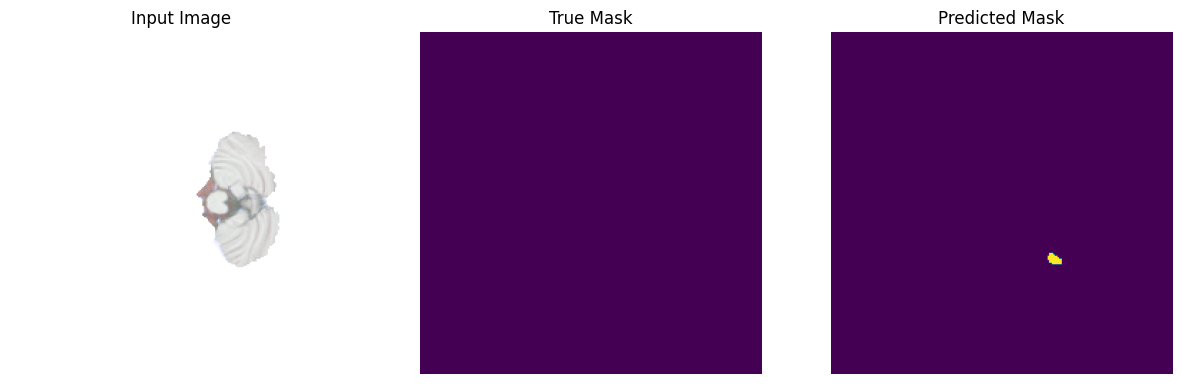

1/1 [==============================] - 0s 36ms/step


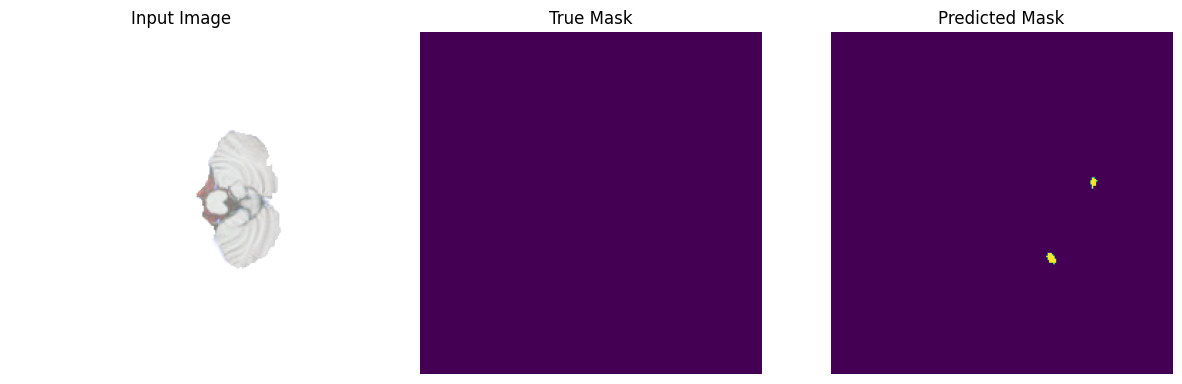

1/1 [==============================] - 0s 39ms/step


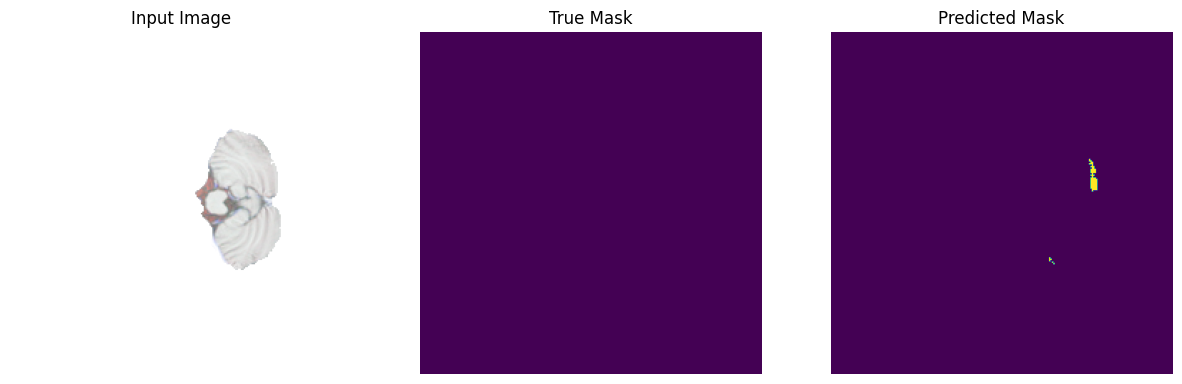

1/1 [==============================] - 0s 33ms/step


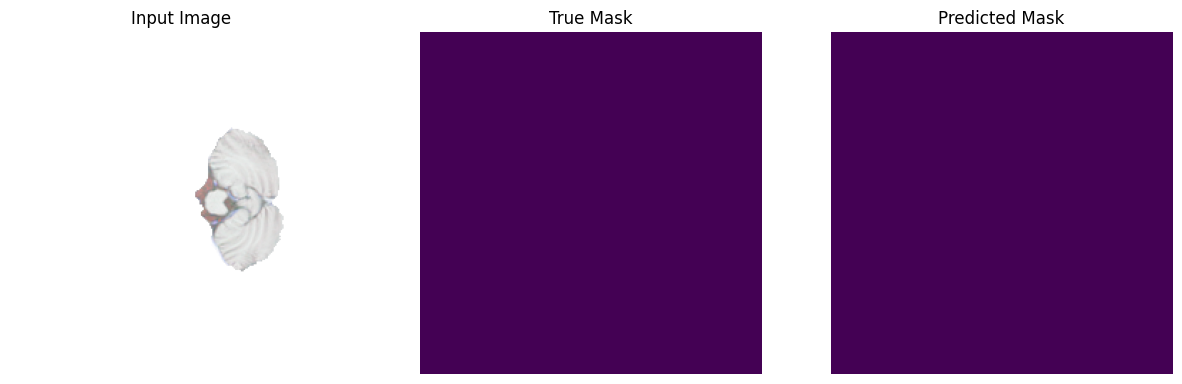

1/1 [==============================] - 0s 44ms/step


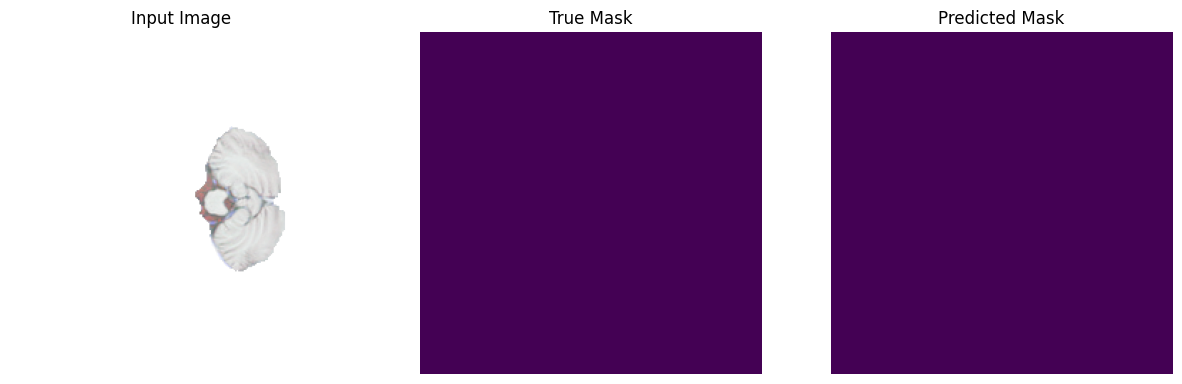

1/1 [==============================] - 0s 38ms/step


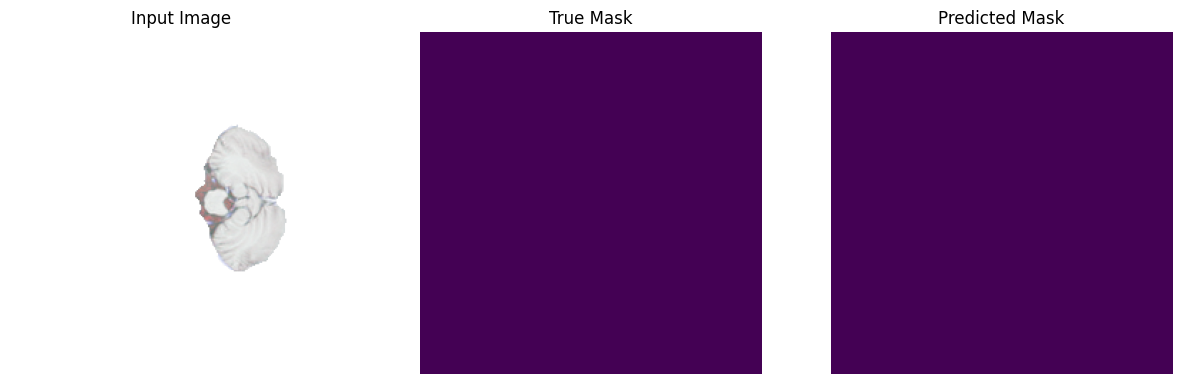

1/1 [==============================] - 0s 38ms/step


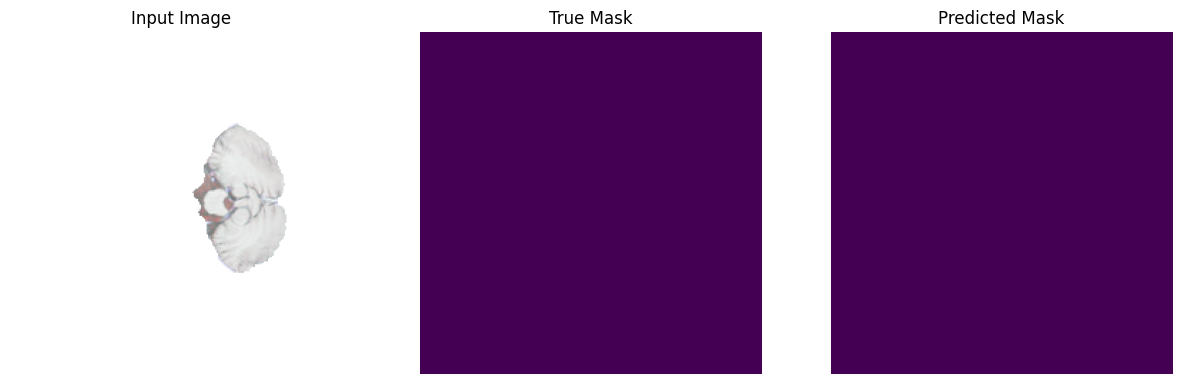

1/1 [==============================] - 0s 39ms/step


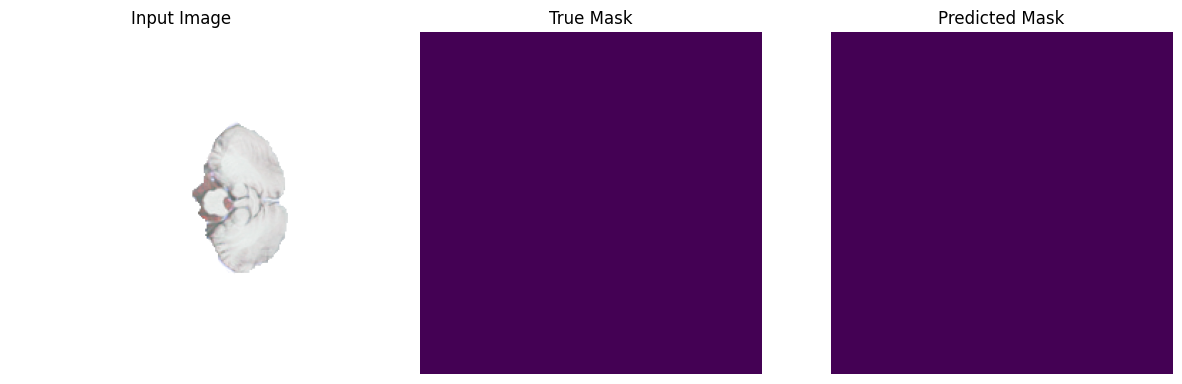

1/1 [==============================] - 0s 34ms/step


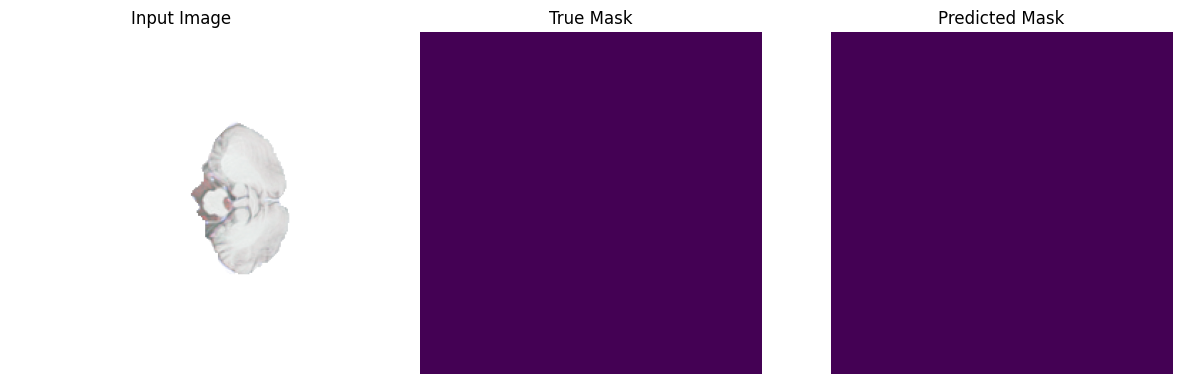

1/1 [==============================] - 0s 38ms/step


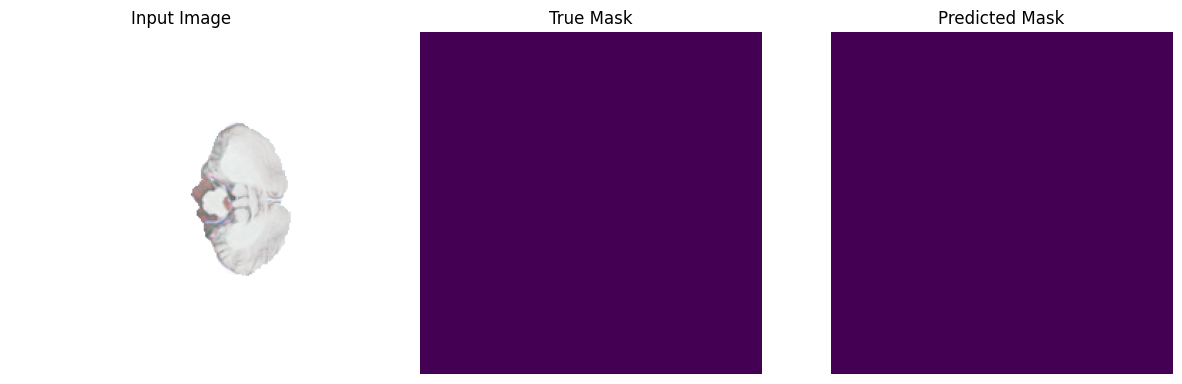

1/1 [==============================] - 0s 35ms/step


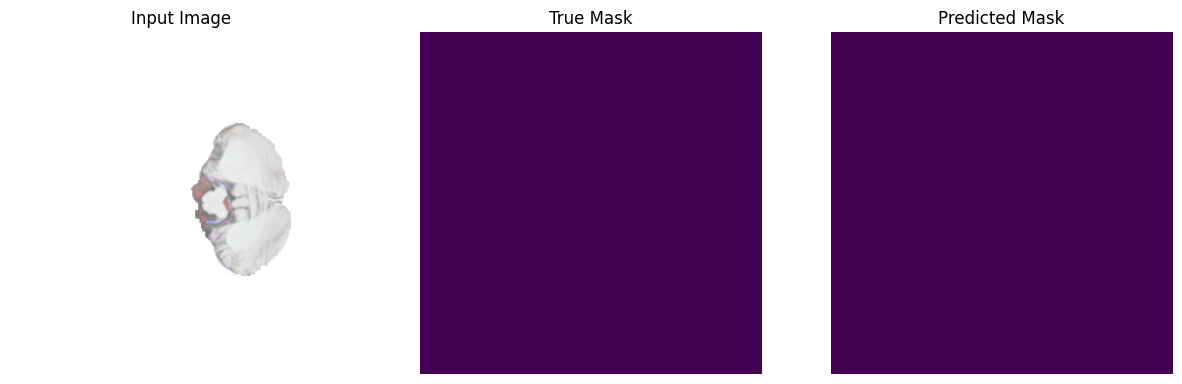

1/1 [==============================] - 0s 42ms/step


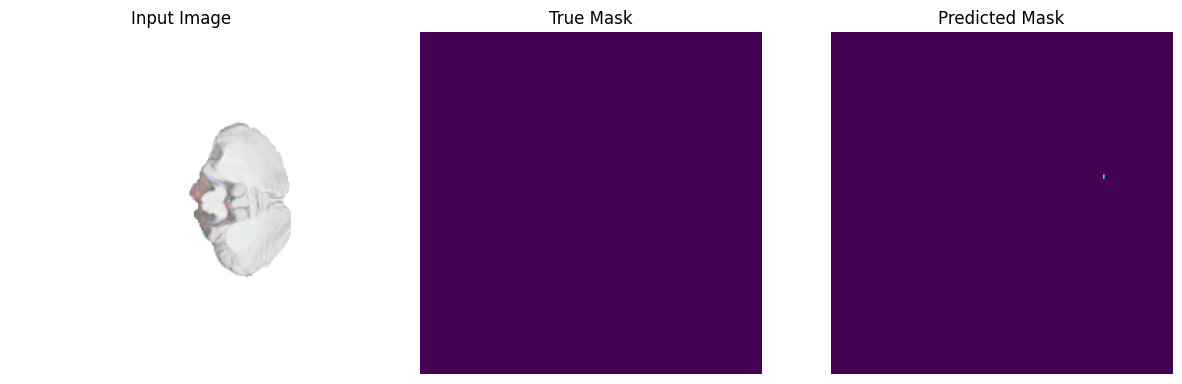

1/1 [==============================] - 0s 46ms/step


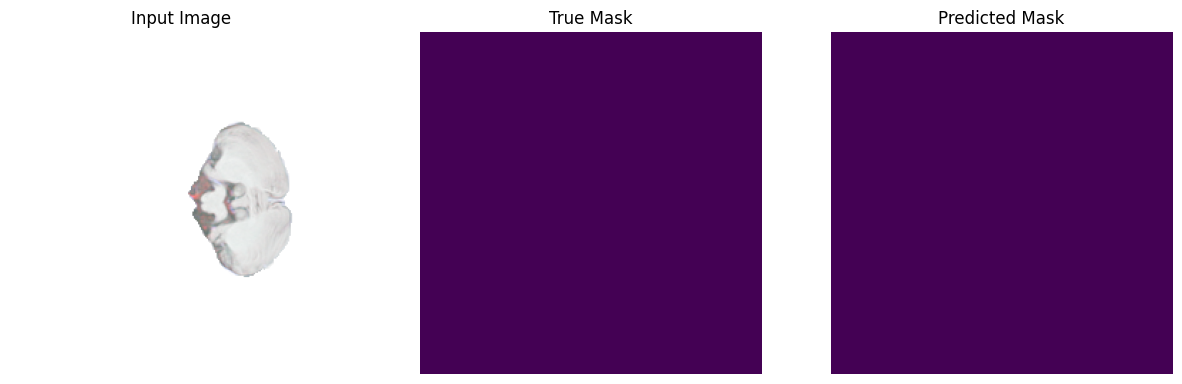

1/1 [==============================] - 0s 33ms/step


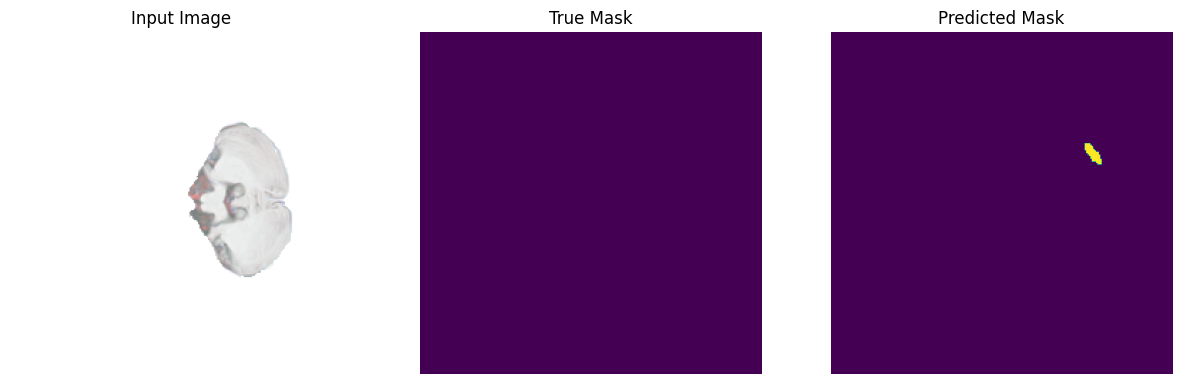

1/1 [==============================] - 0s 36ms/step


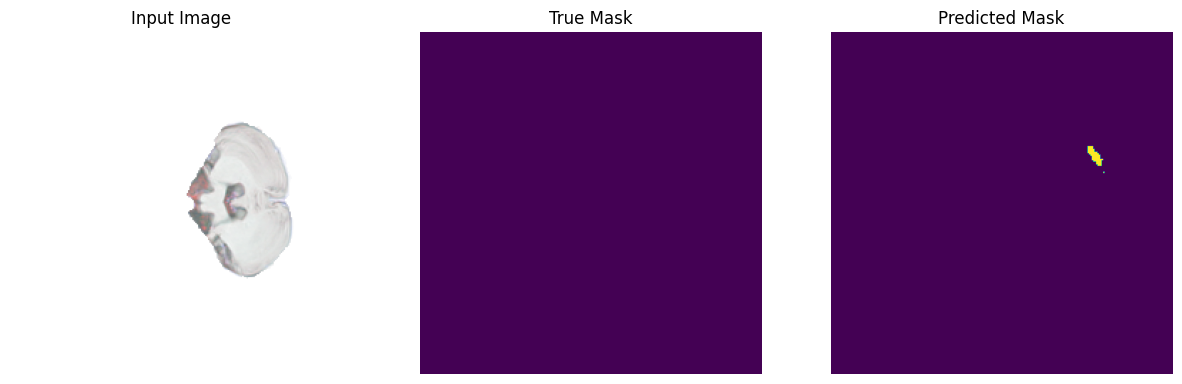

1/1 [==============================] - 0s 33ms/step


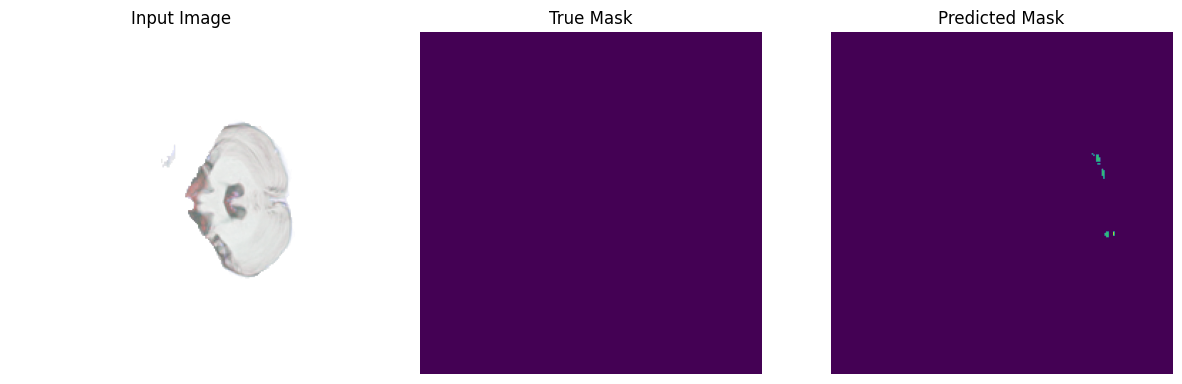

1/1 [==============================] - 0s 35ms/step


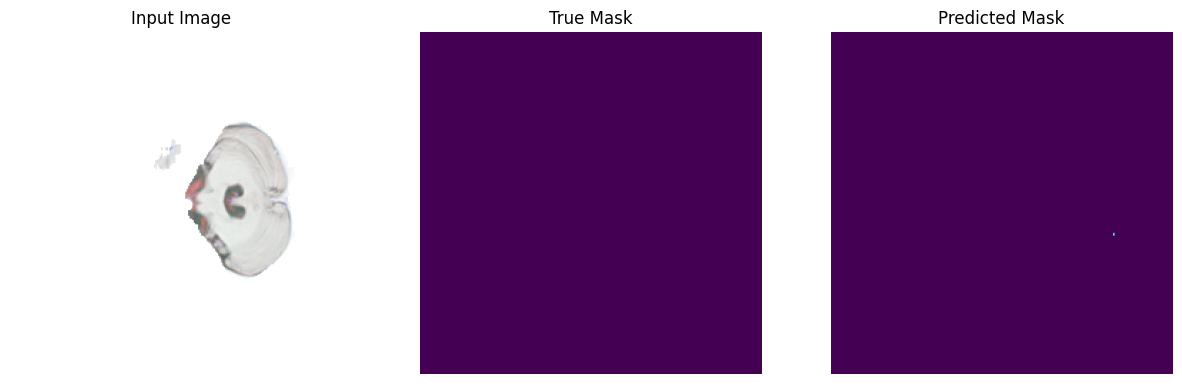

1/1 [==============================] - 0s 31ms/step


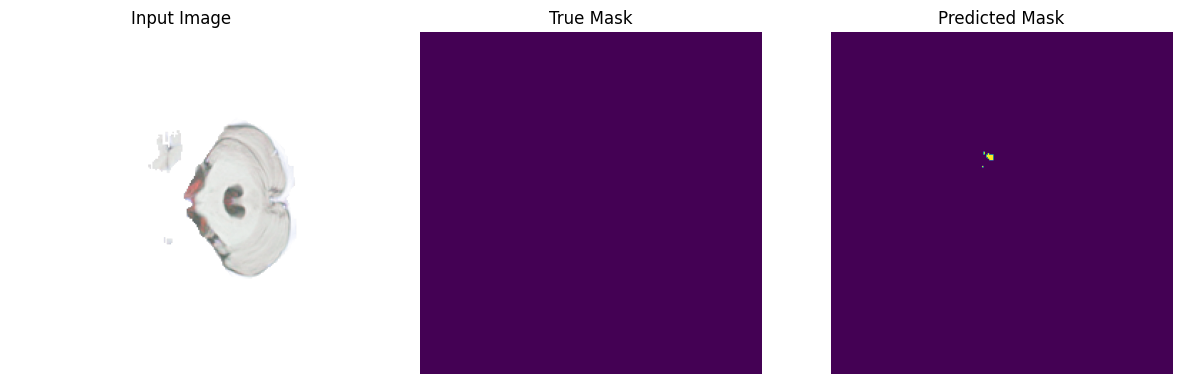

1/1 [==============================] - 0s 34ms/step


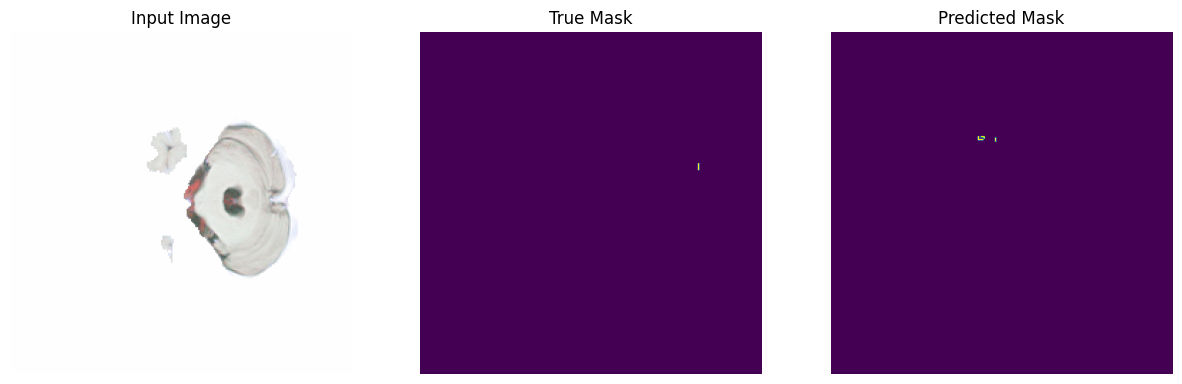

1/1 [==============================] - 0s 36ms/step


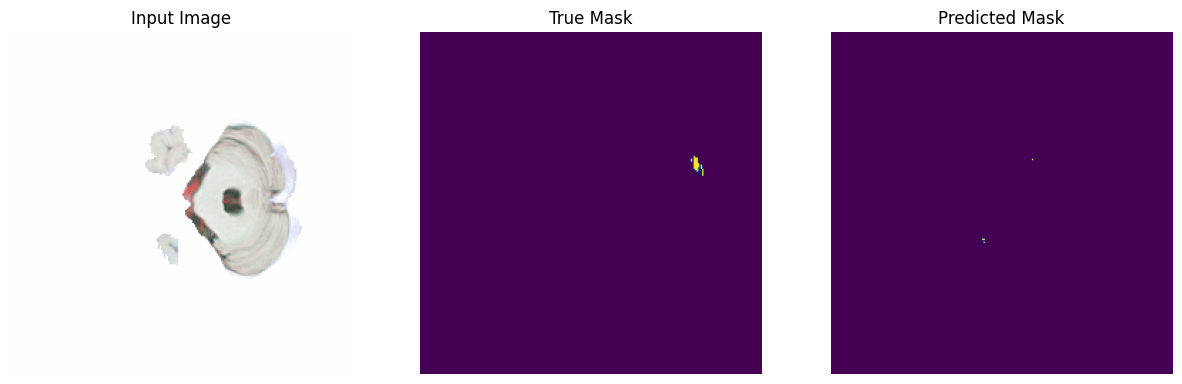

1/1 [==============================] - 0s 30ms/step


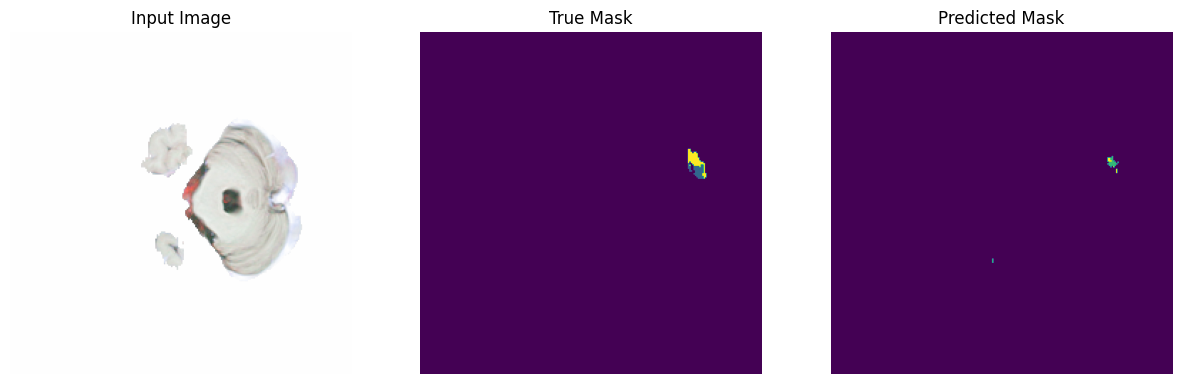

1/1 [==============================] - 0s 32ms/step


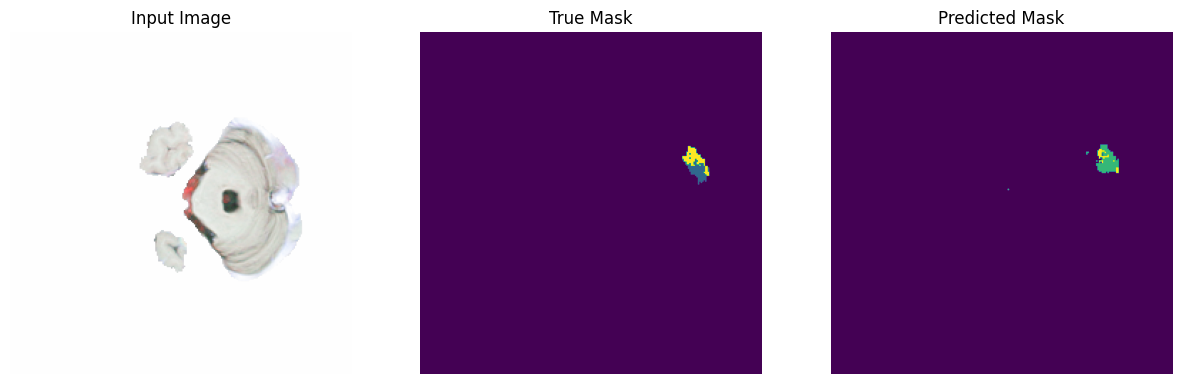

1/1 [==============================] - 0s 36ms/step


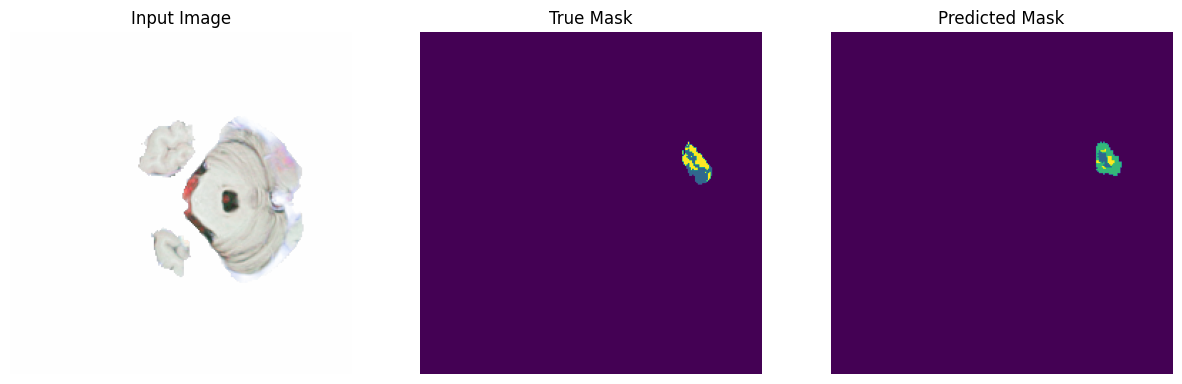

1/1 [==============================] - 0s 35ms/step


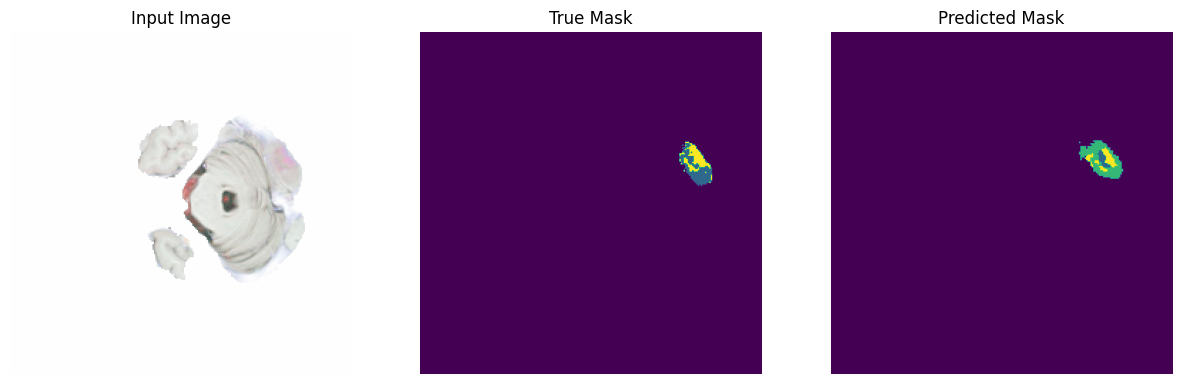

1/1 [==============================] - 0s 32ms/step


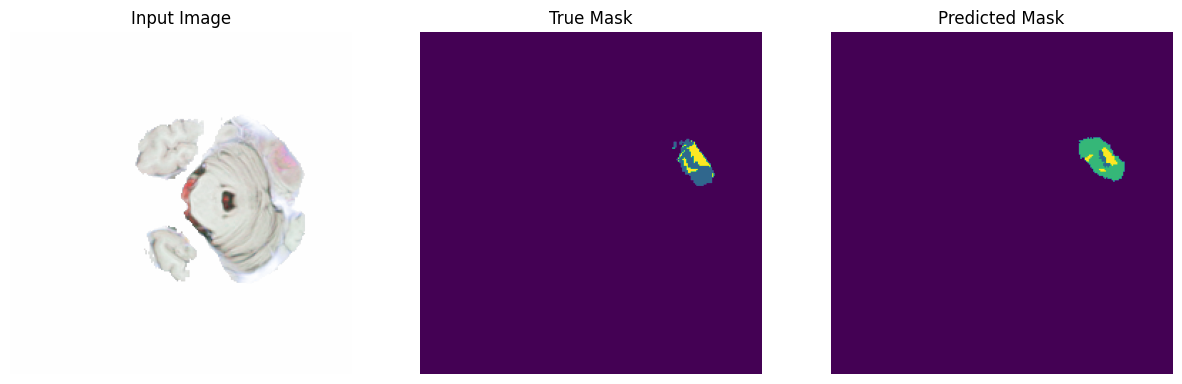

1/1 [==============================] - 0s 31ms/step


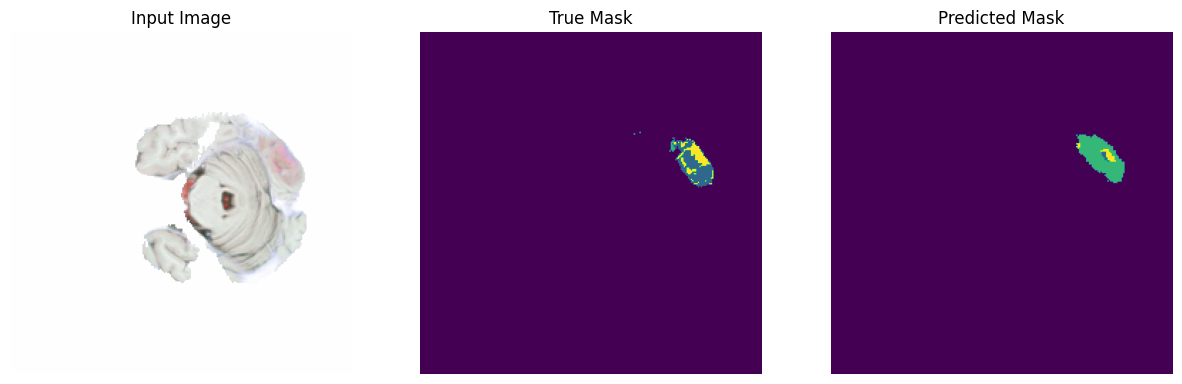

1/1 [==============================] - 0s 37ms/step


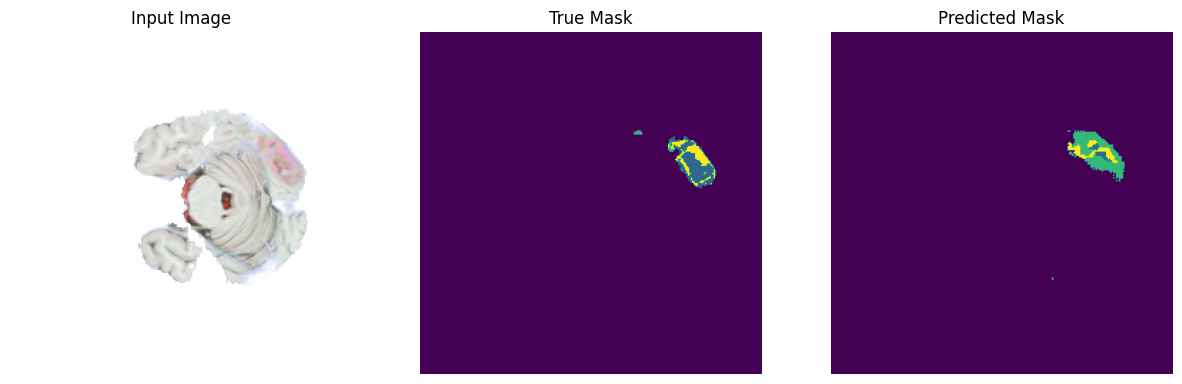

1/1 [==============================] - 0s 32ms/step


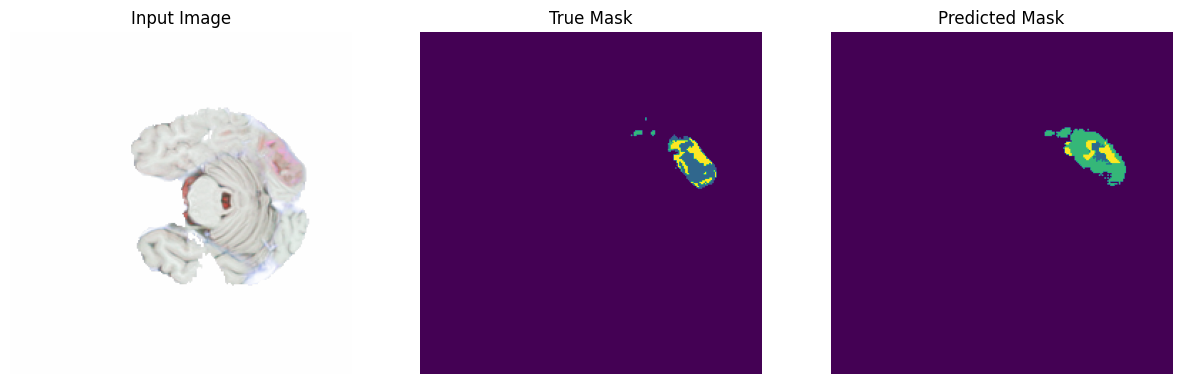

1/1 [==============================] - 0s 36ms/step


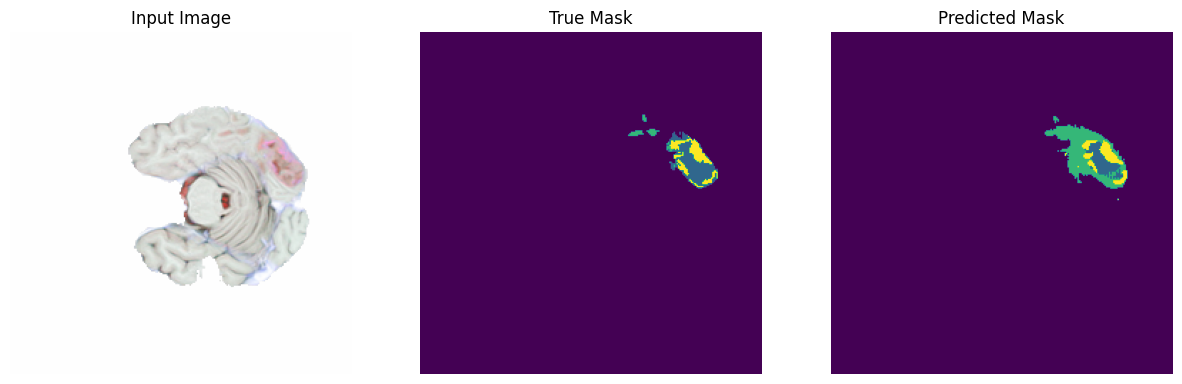

1/1 [==============================] - 0s 35ms/step


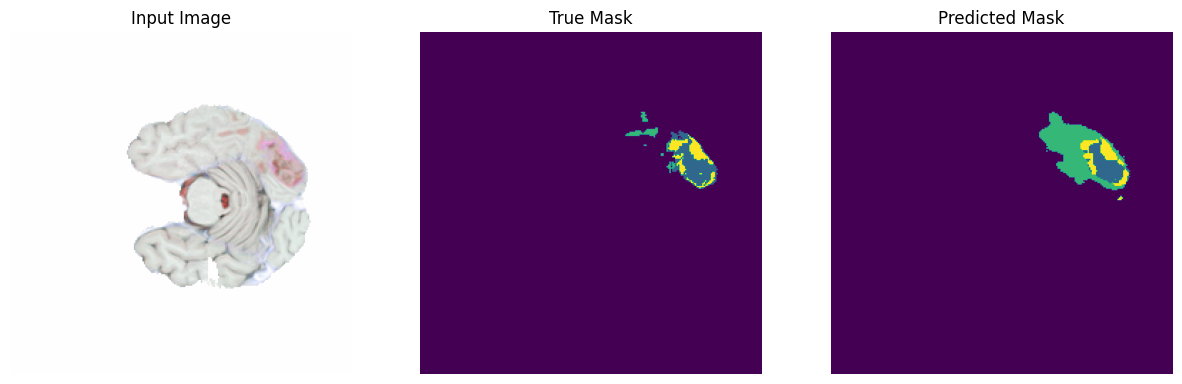

1/1 [==============================] - 0s 31ms/step


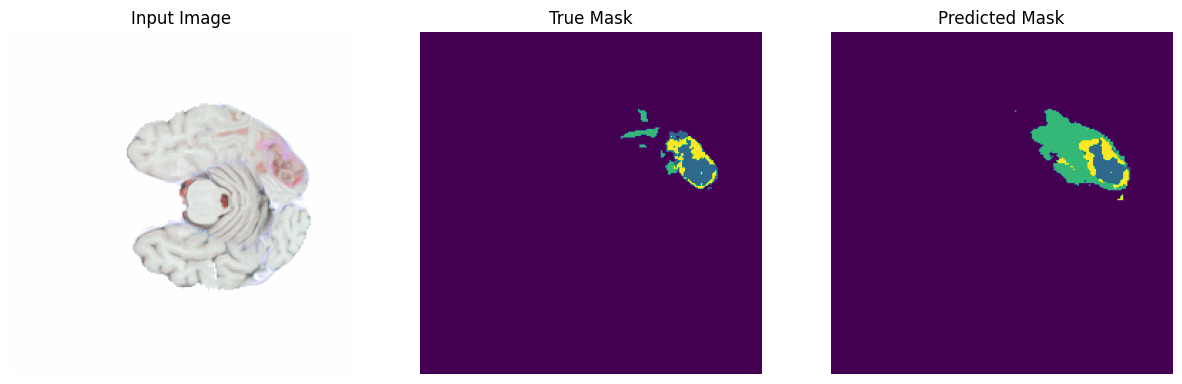

1/1 [==============================] - 0s 32ms/step


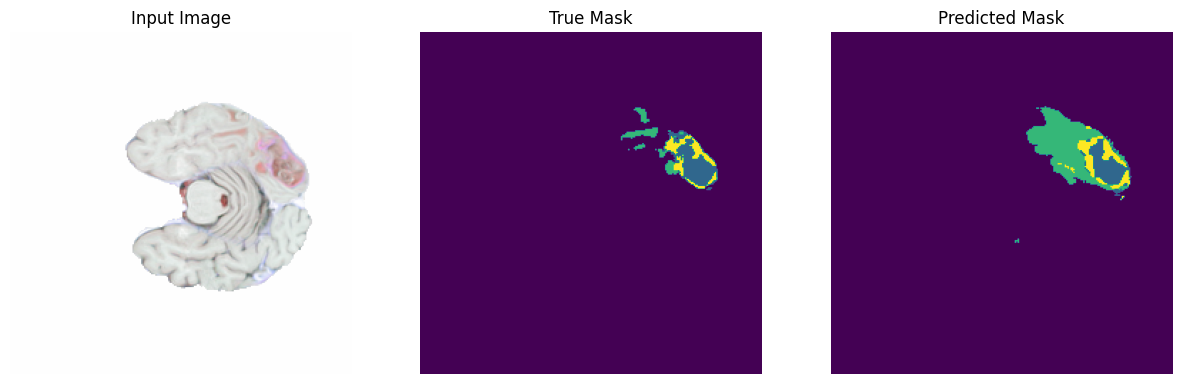

1/1 [==============================] - 0s 31ms/step


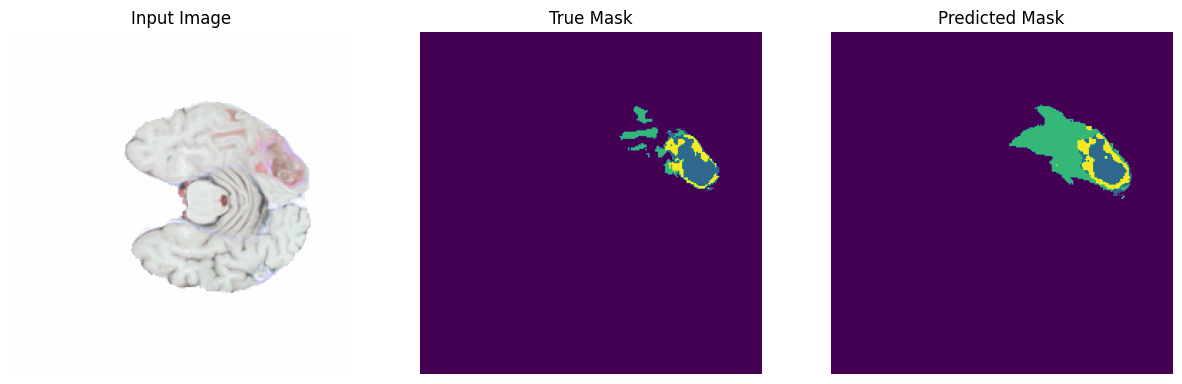

1/1 [==============================] - 0s 36ms/step


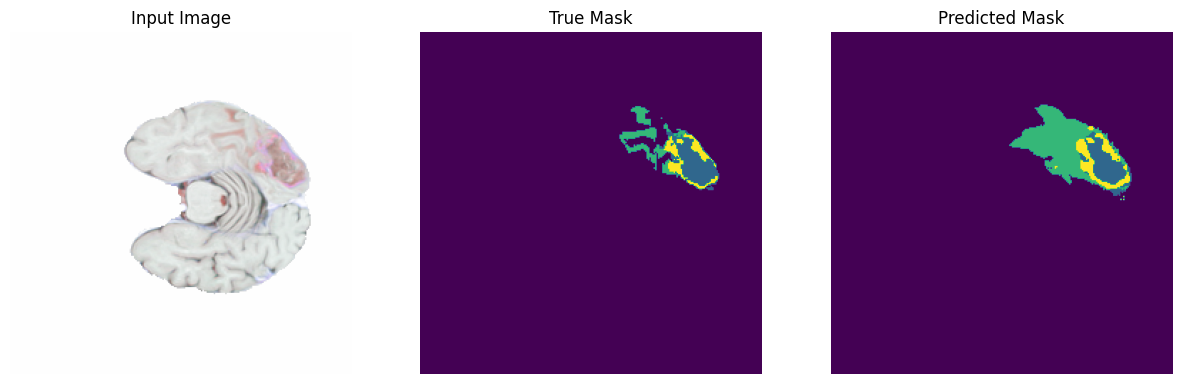

1/1 [==============================] - 0s 31ms/step


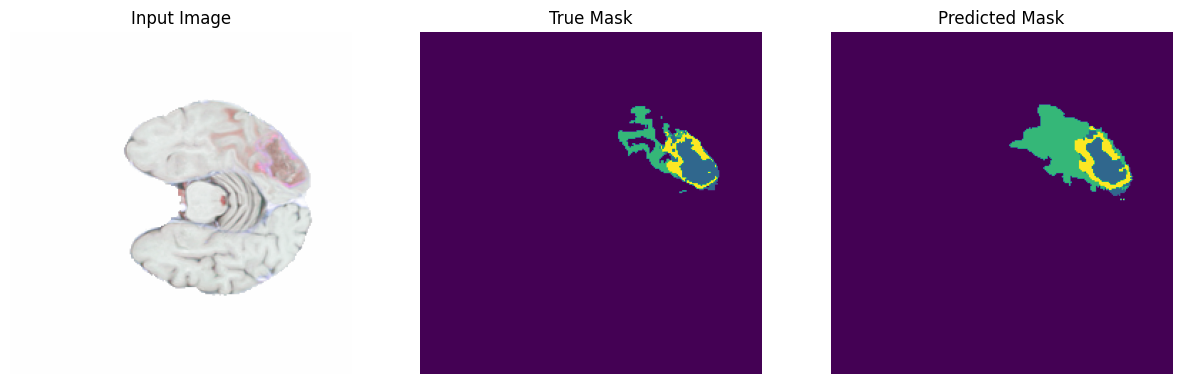

1/1 [==============================] - 0s 35ms/step


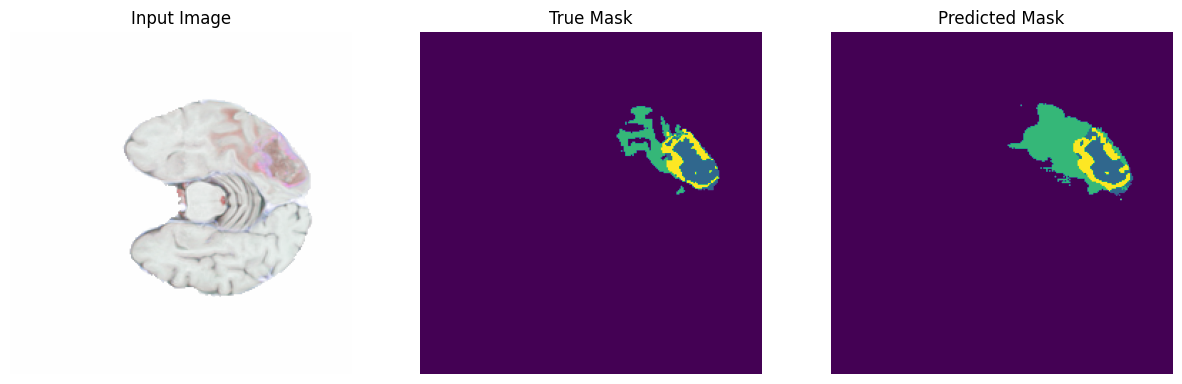

1/1 [==============================] - 0s 30ms/step


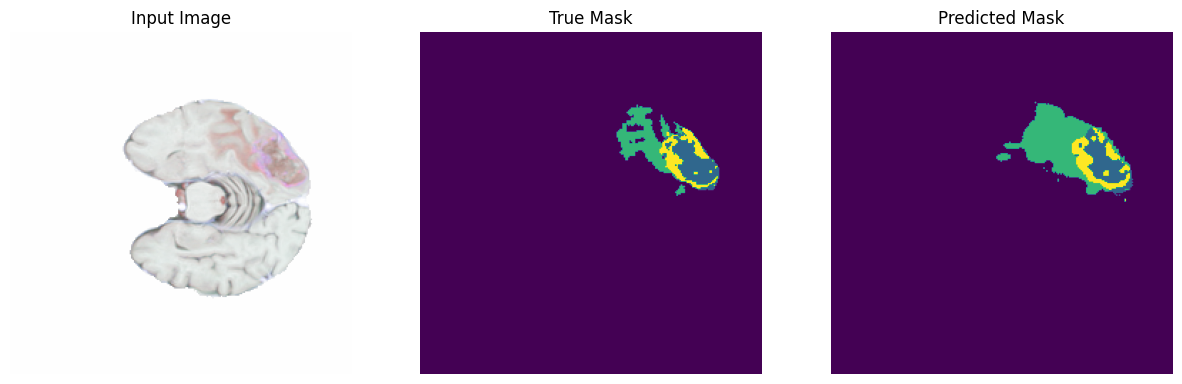

1/1 [==============================] - 0s 29ms/step


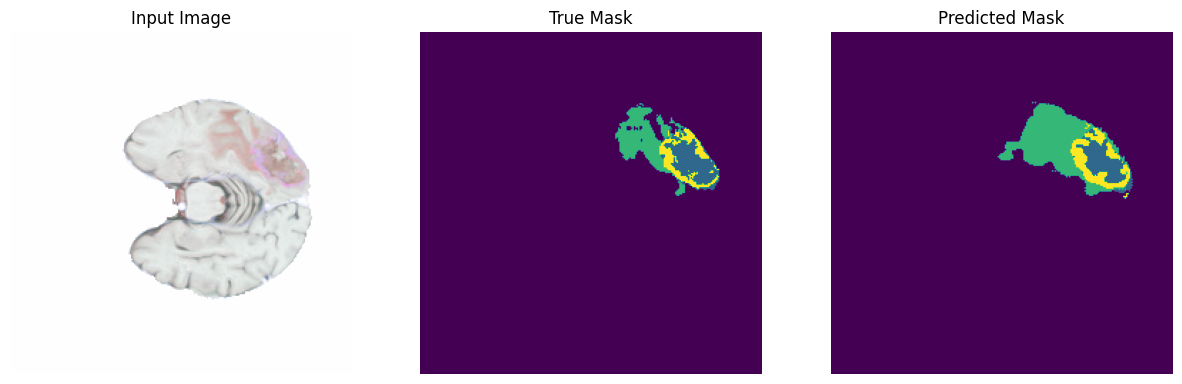

1/1 [==============================] - 0s 30ms/step


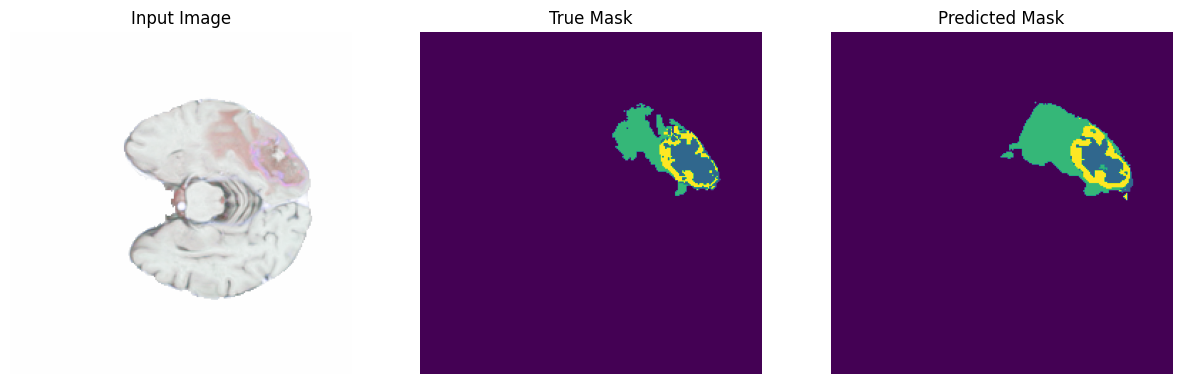

1/1 [==============================] - 0s 32ms/step


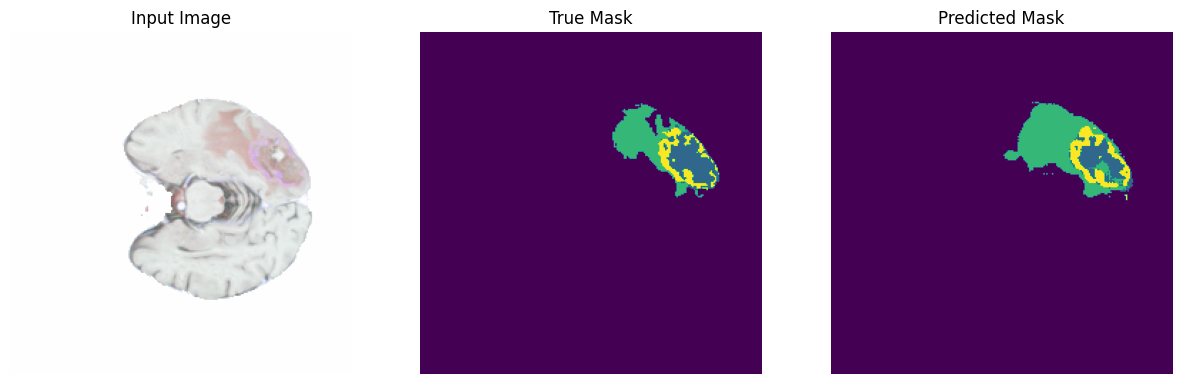

1/1 [==============================] - 0s 30ms/step


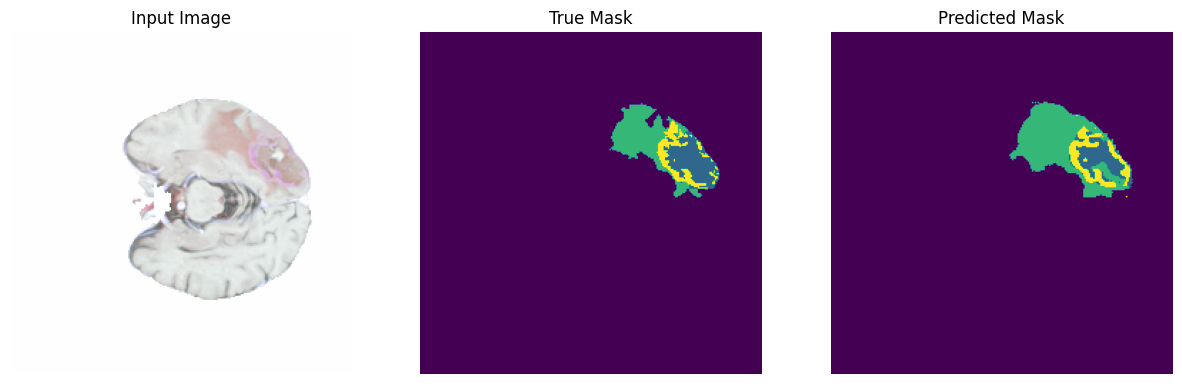

1/1 [==============================] - 0s 38ms/step


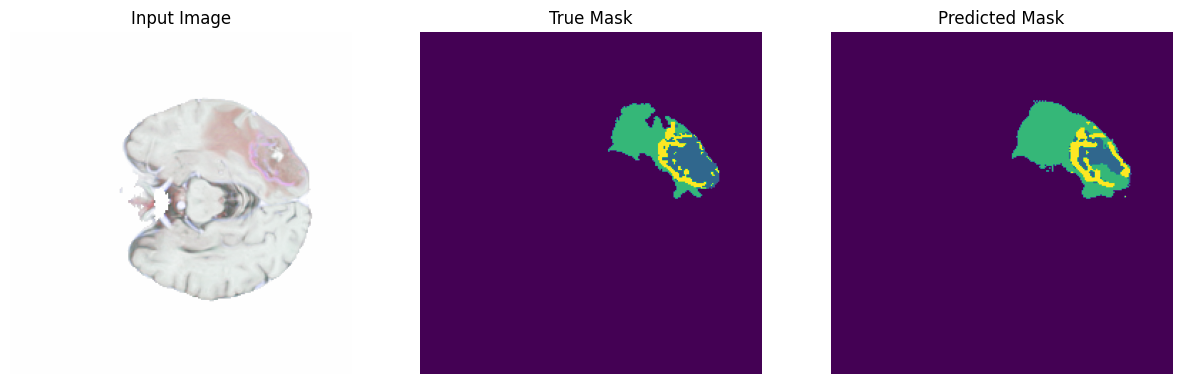

1/1 [==============================] - 0s 30ms/step


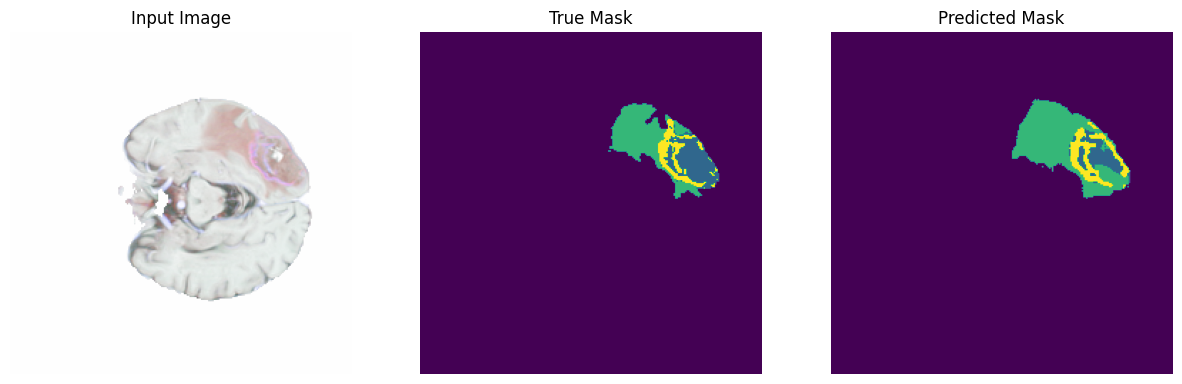

In [147]:
show_predictions_from_scratch(50)